# Part 1, Re-track IBB Index

If you have read the paper, you may notice that the first part of application in the paper is to select a subset of stocks from IBB Index to re-track the Index.


OK, let's start.

In [2]:
# Run some setup code for this notebook.
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

** Load data **

- `index_col = 0`: since first column is date (useless for training), let's keep it as index
- `dropna(axis=1, how='any')`: drop any stock with any n/a (missing) data
- `astype('float32')`: datatype

Finally we only have **83** stocks to use.

In [138]:
# Load data

# stock componenet data
stock = defaultdict(defaultdict)

stock_lp = pd.read_csv('data/IVW_clean/IVW_last_price.csv', \
                       index_col=0,skiprows=np.arange(1,1055),header=0).dropna(axis=1, how='any').astype('float32')
stock_lp.index = pd.to_datetime(stock_lp.index)
stock['calibrate']['lp'] = stock_lp.iloc[0:1007, :]
stock['validate']['lp'] = stock_lp.iloc[1007:, :]

stock_net = pd.read_csv('data/IVW_clean/IVW_net_change.csv', \
                        index_col=0,skiprows=np.arange(1,1055),header=0,\
                        usecols=np.append(stock_lp.columns.values,'date')).dropna(axis=1, how='any').astype('float32')
stock_net.index = pd.to_datetime(stock_net.index)
stock['calibrate']['net'] = stock_net.iloc[0:1007, :]
stock['validate']['net'] = stock_net.iloc[1007:, :]

stock_percentage = pd.read_csv('data/IVW_clean/IVW_percentage_change.csv', \
                               index_col=0,skiprows=np.arange(1,1055),header=0,\
                               usecols=np.append(stock_lp.columns.values,'date')).dropna(axis=1, how='any').astype('float32')
stock_percentage.index = pd.to_datetime(stock_percentage.index)
stock['calibrate']['percentage'] = stock_percentage.iloc[0:1007, :]
stock['validate']['percentage'] = stock_percentage.iloc[1007:, :]


# ibb data
ibb = defaultdict(defaultdict)
ibb_full = pd.read_csv('data/IVW_clean/IVW.csv',index_col=0,skiprows=np.arange(1,1055),header=0).astype('float32')
ibb_full.index = pd.to_datetime(ibb_full.index)
ibb_lp = ibb_full.iloc[:,0] # Series
ibb['calibrate']['lp'] = ibb_lp[0:1007]
ibb['validate']['lp'] = ibb_lp[1007:]

ibb_net = ibb_full.iloc[:,1] # Series
ibb['calibrate']['net'] = ibb_net[0:1007]
ibb['validate']['net'] = ibb_net[1007:]

ibb_percentage = ibb_full.iloc[:,2] # Series
ibb['calibrate']['percentage'] = ibb_percentage[0:1007]
ibb['validate']['percentage'] = ibb_percentage[1007:]

- calibrate : 2014 to 2017, 1007 rows x 289 stocks
- validate: 2018 to 2019, 456 rows × 289 stocks

# Phase 1. Auto-encoding

1. Train an auto-encoder model compressing market information.
2. Rank stocks by 2-norm difference then select subset of them as our portfolio.
3. Page 7 of the paper: ReLU + linear as activation functions
4. Weights $W = (W_1, W_2)$, L2 regularization


Some problems I did not figure out (or the paper did not mention about the details):
1. which weekly return/what data to be used? (what can represent best market information?)
2. How to do the data preprocessing?
3. How to perform 4-fold validation in Deep Learning?

In [ ]:
encoding_dim = 64 # 5 neurons
num_stock = len(stock_lp.columns) # Use 289 stocks as features

# connect all layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # see 'Stacked Auto-Encoders' in paper

# construct and compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder
data = stock['calibrate']['net']
autoencoder.fit(data, data, shuffle=False, epochs=20000, batch_size = 40)
autoencoder.save('model/retrack_autoencoder.h5')

# test/reconstruct market information matrix
reconstruct = autoencoder.predict(data)

Epoch 1/20000
1007/1007 [==============================] - 1s 580us/step - loss: 10.5039
Epoch 2/20000
1007/1007 [==============================] - 0s 62us/step - loss: 9.3182
Epoch 3/20000
1007/1007 [==============================] - 0s 54us/step - loss: 8.4842
Epoch 4/20000
1007/1007 [==============================] - 0s 51us/step - loss: 7.5888
Epoch 5/20000
1007/1007 [==============================] - 0s 54us/step - loss: 6.7967
Epoch 6/20000
1007/1007 [==============================] - 0s 57us/step - loss: 6.2282
Epoch 7/20000
1007/1007 [==============================] - 0s 53us/step - loss: 5.8460
Epoch 8/20000
1007/1007 [==============================] - 0s 55us/step - loss: 5.5732
Epoch 9/20000
1007/1007 [==============================] - 0s 55us/step - loss: 5.3618
Epoch 10/20000
1007/1007 [==============================] - 0s 53us/step - loss: 5.1875
Epoch 11/20000
1007/1007 [==============================] - 0s 52us/step - loss: 5.0389
Epoch 12/20000
1007/1007 [=============

1007/1007 [==============================] - 0s 53us/step - loss: 2.2382
Epoch 95/20000
1007/1007 [==============================] - 0s 53us/step - loss: 2.2277
Epoch 96/20000
1007/1007 [==============================] - 0s 51us/step - loss: 2.2175
Epoch 97/20000
1007/1007 [==============================] - 0s 51us/step - loss: 2.2074
Epoch 98/20000
1007/1007 [==============================] - 0s 49us/step - loss: 2.1974
Epoch 99/20000
1007/1007 [==============================] - 0s 51us/step - loss: 2.1876
Epoch 100/20000
1007/1007 [==============================] - 0s 51us/step - loss: 2.1780
Epoch 101/20000
1007/1007 [==============================] - 0s 51us/step - loss: 2.1685
Epoch 102/20000
1007/1007 [==============================] - 0s 50us/step - loss: 2.1591
Epoch 103/20000
1007/1007 [==============================] - 0s 52us/step - loss: 2.1499
Epoch 104/20000
1007/1007 [==============================] - 0s 51us/step - loss: 2.1408
Epoch 105/20000
1007/1007 [===============

1007/1007 [==============================] - 0s 56us/step - loss: 1.6993
Epoch 187/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.6963
Epoch 188/20000
1007/1007 [==============================] - 0s 56us/step - loss: 1.6933
Epoch 189/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.6904
Epoch 190/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.6874
Epoch 191/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.6846
Epoch 192/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.6817
Epoch 193/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.6789
Epoch 194/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.6761
Epoch 195/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.6734
Epoch 196/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.6706
Epoch 197/20000
1007/1007 [==========

1007/1007 [==============================] - 0s 49us/step - loss: 1.5255
Epoch 279/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.5244
Epoch 280/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.5233
Epoch 281/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.5223
Epoch 282/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.5212
Epoch 283/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.5201
Epoch 284/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.5191
Epoch 285/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.5181
Epoch 286/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.5170
Epoch 287/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.5160
Epoch 288/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.5150
Epoch 289/20000
1007/1007 [==========

1007/1007 [==============================] - 0s 50us/step - loss: 1.4587
Epoch 371/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.4582
Epoch 372/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.4578
Epoch 373/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.4573
Epoch 374/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.4569
Epoch 375/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4564
Epoch 376/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4560
Epoch 377/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.4556
Epoch 378/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4552
Epoch 379/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.4547
Epoch 380/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4543
Epoch 381/20000
1007/1007 [==========

1007/1007 [==============================] - 0s 50us/step - loss: 1.4293
Epoch 463/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.4291
Epoch 464/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.4289
Epoch 465/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4287
Epoch 466/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.4285
Epoch 467/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.4282
Epoch 468/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4280
Epoch 469/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.4278
Epoch 470/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4276
Epoch 471/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.4274
Epoch 472/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.4272
Epoch 473/20000
1007/1007 [==========

1007/1007 [==============================] - 0s 51us/step - loss: 1.4141
Epoch 555/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.4140
Epoch 556/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4139
Epoch 557/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4138
Epoch 558/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4136
Epoch 559/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4135
Epoch 560/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4134
Epoch 561/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4133
Epoch 562/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.4132
Epoch 563/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4130
Epoch 564/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.4129
Epoch 565/20000
1007/1007 [==========

1007/1007 [==============================] - 0s 53us/step - loss: 1.4049
Epoch 647/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4048
Epoch 648/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4047
Epoch 649/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.4046
Epoch 650/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.4046
Epoch 651/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.4045
Epoch 652/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4044
Epoch 653/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.4043
Epoch 654/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.4043
Epoch 655/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.4042
Epoch 656/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.4041
Epoch 657/20000
1007/1007 [==========

1007/1007 [==============================] - 0s 51us/step - loss: 1.3986
Epoch 739/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3985
Epoch 740/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3985
Epoch 741/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3984
Epoch 742/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3984
Epoch 743/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3983
Epoch 744/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3983
Epoch 745/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3982
Epoch 746/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3981
Epoch 747/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3981
Epoch 748/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3980
Epoch 749/20000
1007/1007 [==========

1007/1007 [==============================] - 0s 51us/step - loss: 1.3938
Epoch 831/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3937
Epoch 832/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3937
Epoch 833/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3936
Epoch 834/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3936
Epoch 835/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3935
Epoch 836/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3935
Epoch 837/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3935
Epoch 838/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.3934
Epoch 839/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3934
Epoch 840/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3933
Epoch 841/20000
1007/1007 [==========

1007/1007 [==============================] - 0s 52us/step - loss: 1.3897
Epoch 923/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3897
Epoch 924/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.3896
Epoch 925/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3896
Epoch 926/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.3896
Epoch 927/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3895
Epoch 928/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.3895
Epoch 929/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3894
Epoch 930/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3894
Epoch 931/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3894
Epoch 932/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3893
Epoch 933/20000
1007/1007 [==========

1007/1007 [==============================] - 0s 53us/step - loss: 1.3863
Epoch 1015/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3862
Epoch 1016/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3862
Epoch 1017/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3862
Epoch 1018/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3861
Epoch 1019/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3861
Epoch 1020/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3860
Epoch 1021/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3860
Epoch 1022/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3860
Epoch 1023/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3859
Epoch 1024/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.3859
Epoch 1025/20000
1007/1007 

1007/1007 [==============================] - 0s 52us/step - loss: 1.3832
Epoch 1106/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3832
Epoch 1107/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.3832
Epoch 1108/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3831
Epoch 1109/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3831
Epoch 1110/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3831
Epoch 1111/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3830
Epoch 1112/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3830
Epoch 1113/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3830
Epoch 1114/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.3829
Epoch 1115/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3829
Epoch 1116/20000
1007/1007 

1007/1007 [==============================] - 0s 51us/step - loss: 1.3805
Epoch 1197/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3805
Epoch 1198/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.3804
Epoch 1199/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.3804
Epoch 1200/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3804
Epoch 1201/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3804
Epoch 1202/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3803
Epoch 1203/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3803
Epoch 1204/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3803
Epoch 1205/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3802
Epoch 1206/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3802
Epoch 1207/20000
1007/1007 

1007/1007 [==============================] - 0s 52us/step - loss: 1.3780
Epoch 1288/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3780
Epoch 1289/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3780
Epoch 1290/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3779
Epoch 1291/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3779
Epoch 1292/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3779
Epoch 1293/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3779
Epoch 1294/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.3778
Epoch 1295/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3778
Epoch 1296/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3778
Epoch 1297/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3777
Epoch 1298/20000
1007/1007 

1007/1007 [==============================] - 0s 51us/step - loss: 1.3757
Epoch 1379/20000
1007/1007 [==============================] - 0s 54us/step - loss: 1.3756
Epoch 1380/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3756
Epoch 1381/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3756
Epoch 1382/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3756
Epoch 1383/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3755
Epoch 1384/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3755
Epoch 1385/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3755
Epoch 1386/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3755
Epoch 1387/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3754
Epoch 1388/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3754
Epoch 1389/20000
1007/1007 

1007/1007 [==============================] - 0s 50us/step - loss: 1.3734
Epoch 1470/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3734
Epoch 1471/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3734
Epoch 1472/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3734
Epoch 1473/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3733
Epoch 1474/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3733
Epoch 1475/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3733
Epoch 1476/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3733
Epoch 1477/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3732
Epoch 1478/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3732
Epoch 1479/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3732
Epoch 1480/20000
1007/1007 

1007/1007 [==============================] - 0s 52us/step - loss: 1.3713
Epoch 1561/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3713
Epoch 1562/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3712
Epoch 1563/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3712
Epoch 1564/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3712
Epoch 1565/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.3712
Epoch 1566/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3712
Epoch 1567/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3711
Epoch 1568/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3711
Epoch 1569/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3711
Epoch 1570/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3711
Epoch 1571/20000
1007/1007 

1007/1007 [==============================] - 0s 51us/step - loss: 1.3693
Epoch 1652/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3693
Epoch 1653/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3692
Epoch 1654/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3692
Epoch 1655/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.3692
Epoch 1656/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.3692
Epoch 1657/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3692
Epoch 1658/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3691
Epoch 1659/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3691
Epoch 1660/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3691
Epoch 1661/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3691
Epoch 1662/20000
1007/1007 

1007/1007 [==============================] - 0s 51us/step - loss: 1.3673
Epoch 1743/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3673
Epoch 1744/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.3673
Epoch 1745/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3673
Epoch 1746/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3673
Epoch 1747/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3672
Epoch 1748/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3672
Epoch 1749/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3672
Epoch 1750/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3672
Epoch 1751/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3672
Epoch 1752/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3671
Epoch 1753/20000
1007/1007 

1007/1007 [==============================] - 0s 50us/step - loss: 1.3655
Epoch 1834/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3654
Epoch 1835/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3654
Epoch 1836/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3654
Epoch 1837/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3654
Epoch 1838/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3654
Epoch 1839/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3653
Epoch 1840/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.3653
Epoch 1841/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3653
Epoch 1842/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3653
Epoch 1843/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3653
Epoch 1844/20000
1007/1007 

1007/1007 [==============================] - 0s 51us/step - loss: 1.3636
Epoch 1925/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3636
Epoch 1926/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3636
Epoch 1927/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3636
Epoch 1928/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3635
Epoch 1929/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3635
Epoch 1930/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3635
Epoch 1931/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3635
Epoch 1932/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3635
Epoch 1933/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3634
Epoch 1934/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3634
Epoch 1935/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.3618
Epoch 2016/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3618
Epoch 2017/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3618
Epoch 2018/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3617
Epoch 2019/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3617
Epoch 2020/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3617
Epoch 2021/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3617
Epoch 2022/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3617
Epoch 2023/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3616
Epoch 2024/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3616
Epoch 2025/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3616
Epoch 2026/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.3600
Epoch 2107/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3600
Epoch 2108/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3600
Epoch 2109/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3599
Epoch 2110/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3599
Epoch 2111/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3599
Epoch 2112/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3599
Epoch 2113/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3599
Epoch 2114/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3598
Epoch 2115/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3598
Epoch 2116/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3598
Epoch 2117/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.3582
Epoch 2198/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3582
Epoch 2199/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3582
Epoch 2200/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3581
Epoch 2201/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3581
Epoch 2202/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3581
Epoch 2203/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3581
Epoch 2204/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3581
Epoch 2205/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3580
Epoch 2206/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3580
Epoch 2207/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3580
Epoch 2208/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3564
Epoch 2289/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3564
Epoch 2290/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3564
Epoch 2291/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3564
Epoch 2292/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3564
Epoch 2293/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3563
Epoch 2294/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3563
Epoch 2295/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3563
Epoch 2296/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3563
Epoch 2297/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3563
Epoch 2298/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3563
Epoch 2299/20000
1007/1007 

1007/1007 [==============================] - 0s 45us/step - loss: 1.3547
Epoch 2380/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3547
Epoch 2381/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3547
Epoch 2382/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3546
Epoch 2383/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3546
Epoch 2384/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3546
Epoch 2385/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3546
Epoch 2386/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3546
Epoch 2387/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3545
Epoch 2388/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3545
Epoch 2389/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3545
Epoch 2390/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3529
Epoch 2471/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3529
Epoch 2472/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3529
Epoch 2473/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3529
Epoch 2474/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3529
Epoch 2475/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3528
Epoch 2476/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3528
Epoch 2477/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3528
Epoch 2478/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3528
Epoch 2479/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3528
Epoch 2480/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3527
Epoch 2481/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3511
Epoch 2562/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3511
Epoch 2563/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3511
Epoch 2564/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3511
Epoch 2565/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3511
Epoch 2566/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3510
Epoch 2567/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3510
Epoch 2568/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3510
Epoch 2569/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3510
Epoch 2570/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3510
Epoch 2571/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3509
Epoch 2572/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.3494
Epoch 2653/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3493
Epoch 2654/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3493
Epoch 2655/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3493
Epoch 2656/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3493
Epoch 2657/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3493
Epoch 2658/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3492
Epoch 2659/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3492
Epoch 2660/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3492
Epoch 2661/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3492
Epoch 2662/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3492
Epoch 2663/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3476
Epoch 2744/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3476
Epoch 2745/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3476
Epoch 2746/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3475
Epoch 2747/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3475
Epoch 2748/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3475
Epoch 2749/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3475
Epoch 2750/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3475
Epoch 2751/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3474
Epoch 2752/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3474
Epoch 2753/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3474
Epoch 2754/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3458
Epoch 2835/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3458
Epoch 2836/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3458
Epoch 2837/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3458
Epoch 2838/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3458
Epoch 2839/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3457
Epoch 2840/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3457
Epoch 2841/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3457
Epoch 2842/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3457
Epoch 2843/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3457
Epoch 2844/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3456
Epoch 2845/20000
1007/1007 

1007/1007 [==============================] - 0s 48us/step - loss: 1.3441
Epoch 2926/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3441
Epoch 2927/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3441
Epoch 2928/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3440
Epoch 2929/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3440
Epoch 2930/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3440
Epoch 2931/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3440
Epoch 2932/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3440
Epoch 2933/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3439
Epoch 2934/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3439
Epoch 2935/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3439
Epoch 2936/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3423
Epoch 3017/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3423
Epoch 3018/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3423
Epoch 3019/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3423
Epoch 3020/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3422
Epoch 3021/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3422
Epoch 3022/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3422
Epoch 3023/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3422
Epoch 3024/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3422
Epoch 3025/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3421
Epoch 3026/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3421
Epoch 3027/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3405
Epoch 3108/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3405
Epoch 3109/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3405
Epoch 3110/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3405
Epoch 3111/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3404
Epoch 3112/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3404
Epoch 3113/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3404
Epoch 3114/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3404
Epoch 3115/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3404
Epoch 3116/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3403
Epoch 3117/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3403
Epoch 3118/20000
1007/1007 

1007/1007 [==============================] - 0s 48us/step - loss: 1.3387
Epoch 3199/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3387
Epoch 3200/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3387
Epoch 3201/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3387
Epoch 3202/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3386
Epoch 3203/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3386
Epoch 3204/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3386
Epoch 3205/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3386
Epoch 3206/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3386
Epoch 3207/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3385
Epoch 3208/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3385
Epoch 3209/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3370
Epoch 3290/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3369
Epoch 3291/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3369
Epoch 3292/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3369
Epoch 3293/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3369
Epoch 3294/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3369
Epoch 3295/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3368
Epoch 3296/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3368
Epoch 3297/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3368
Epoch 3298/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3368
Epoch 3299/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3368
Epoch 3300/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3352
Epoch 3381/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3352
Epoch 3382/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3351
Epoch 3383/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3351
Epoch 3384/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3351
Epoch 3385/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3351
Epoch 3386/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3351
Epoch 3387/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3350
Epoch 3388/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3350
Epoch 3389/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3350
Epoch 3390/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3350
Epoch 3391/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3333
Epoch 3472/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3333
Epoch 3473/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3333
Epoch 3474/20000
1007/1007 [==============================] - 0s 63us/step - loss: 1.3333
Epoch 3475/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.3332
Epoch 3476/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.3332
Epoch 3477/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3332
Epoch 3478/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3332
Epoch 3479/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3332
Epoch 3480/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3331
Epoch 3481/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3331
Epoch 3482/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.3315
Epoch 3563/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3315
Epoch 3564/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3315
Epoch 3565/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3315
Epoch 3566/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3314
Epoch 3567/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3314
Epoch 3568/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3314
Epoch 3569/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3314
Epoch 3570/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3314
Epoch 3571/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.3313
Epoch 3572/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3313
Epoch 3573/20000
1007/1007 

1007/1007 [==============================] - 0s 48us/step - loss: 1.3297
Epoch 3654/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3297
Epoch 3655/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3297
Epoch 3656/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3297
Epoch 3657/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3296
Epoch 3658/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3296
Epoch 3659/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3296
Epoch 3660/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3296
Epoch 3661/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3296
Epoch 3662/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3295
Epoch 3663/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3295
Epoch 3664/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3279
Epoch 3745/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3279
Epoch 3746/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3279
Epoch 3747/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3278
Epoch 3748/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3278
Epoch 3749/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3278
Epoch 3750/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3278
Epoch 3751/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3278
Epoch 3752/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3277
Epoch 3753/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3277
Epoch 3754/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3277
Epoch 3755/20000
1007/1007 

1007/1007 [==============================] - 0s 52us/step - loss: 1.3261
Epoch 3836/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.3261
Epoch 3837/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3260
Epoch 3838/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3260
Epoch 3839/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3260
Epoch 3840/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3260
Epoch 3841/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3260
Epoch 3842/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3259
Epoch 3843/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3259
Epoch 3844/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3259
Epoch 3845/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3259
Epoch 3846/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.3243
Epoch 3927/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3242
Epoch 3928/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3242
Epoch 3929/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3242
Epoch 3930/20000
1007/1007 [==============================] - 0s 53us/step - loss: 1.3242
Epoch 3931/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.3242
Epoch 3932/20000
1007/1007 [==============================] - 0s 59us/step - loss: 1.3241
Epoch 3933/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.3241
Epoch 3934/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3241
Epoch 3935/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3241
Epoch 3936/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3241
Epoch 3937/20000
1007/1007 

1007/1007 [==============================] - 0s 58us/step - loss: 1.3224
Epoch 4018/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3224
Epoch 4019/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3224
Epoch 4020/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3223
Epoch 4021/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3223
Epoch 4022/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3223
Epoch 4023/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3223
Epoch 4024/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3223
Epoch 4025/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3222
Epoch 4026/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3222
Epoch 4027/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3222
Epoch 4028/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3205
Epoch 4109/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3205
Epoch 4110/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3205
Epoch 4111/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3205
Epoch 4112/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3205
Epoch 4113/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3204
Epoch 4114/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3204
Epoch 4115/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3204
Epoch 4116/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3204
Epoch 4117/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3204
Epoch 4118/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3203
Epoch 4119/20000
1007/1007 

1007/1007 [==============================] - 0s 45us/step - loss: 1.3187
Epoch 4200/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3187
Epoch 4201/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3186
Epoch 4202/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3186
Epoch 4203/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3186
Epoch 4204/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3186
Epoch 4205/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3186
Epoch 4206/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3186
Epoch 4207/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3185
Epoch 4208/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3185
Epoch 4209/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3185
Epoch 4210/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.3168
Epoch 4291/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3168
Epoch 4292/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3168
Epoch 4293/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3168
Epoch 4294/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3168
Epoch 4295/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3167
Epoch 4296/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3167
Epoch 4297/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3167
Epoch 4298/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3167
Epoch 4299/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3167
Epoch 4300/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3166
Epoch 4301/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3150
Epoch 4382/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3150
Epoch 4383/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3150
Epoch 4384/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3149
Epoch 4385/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3149
Epoch 4386/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3149
Epoch 4387/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3149
Epoch 4388/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3148
Epoch 4389/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3148
Epoch 4390/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3148
Epoch 4391/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3148
Epoch 4392/20000
1007/1007 

1007/1007 [==============================] - 0s 48us/step - loss: 1.3131
Epoch 4473/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3131
Epoch 4474/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3131
Epoch 4475/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3130
Epoch 4476/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3130
Epoch 4477/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3130
Epoch 4478/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.3130
Epoch 4479/20000
1007/1007 [==============================] - 0s 57us/step - loss: 1.3130
Epoch 4480/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3129
Epoch 4481/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3129
Epoch 4482/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3129
Epoch 4483/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3112
Epoch 4564/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3112
Epoch 4565/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3112
Epoch 4566/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3111
Epoch 4567/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3111
Epoch 4568/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3111
Epoch 4569/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3111
Epoch 4570/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3111
Epoch 4571/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3111
Epoch 4572/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3110
Epoch 4573/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3110
Epoch 4574/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3093
Epoch 4655/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3093
Epoch 4656/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3093
Epoch 4657/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3093
Epoch 4658/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3092
Epoch 4659/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3092
Epoch 4660/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3092
Epoch 4661/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3092
Epoch 4662/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3092
Epoch 4663/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3091
Epoch 4664/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3091
Epoch 4665/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.3075
Epoch 4746/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3074
Epoch 4747/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3074
Epoch 4748/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3074
Epoch 4749/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3074
Epoch 4750/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3074
Epoch 4751/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3073
Epoch 4752/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3073
Epoch 4753/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3073
Epoch 4754/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3073
Epoch 4755/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3073
Epoch 4756/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3056
Epoch 4837/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3056
Epoch 4838/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3056
Epoch 4839/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3055
Epoch 4840/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3055
Epoch 4841/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3055
Epoch 4842/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3055
Epoch 4843/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3055
Epoch 4844/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3054
Epoch 4845/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3054
Epoch 4846/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3054
Epoch 4847/20000
1007/1007 

1007/1007 [==============================] - 0s 44us/step - loss: 1.3038
Epoch 4928/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.3037
Epoch 4929/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3037
Epoch 4930/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3037
Epoch 4931/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3037
Epoch 4932/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3037
Epoch 4933/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3036
Epoch 4934/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3036
Epoch 4935/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3036
Epoch 4936/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3036
Epoch 4937/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.3036
Epoch 4938/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.3019
Epoch 5019/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3019
Epoch 5020/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3019
Epoch 5021/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3018
Epoch 5022/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3018
Epoch 5023/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.3018
Epoch 5024/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3018
Epoch 5025/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3017
Epoch 5026/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3017
Epoch 5027/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.3017
Epoch 5028/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3017
Epoch 5029/20000
1007/1007 

1007/1007 [==============================] - 0s 45us/step - loss: 1.3000
Epoch 5110/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3000
Epoch 5111/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.3000
Epoch 5112/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.3000
Epoch 5113/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.3000
Epoch 5114/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2999
Epoch 5115/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2999
Epoch 5116/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2999
Epoch 5117/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2999
Epoch 5118/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2998
Epoch 5119/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2998
Epoch 5120/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2982
Epoch 5201/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2982
Epoch 5202/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2982
Epoch 5203/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2981
Epoch 5204/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2981
Epoch 5205/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2981
Epoch 5206/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2981
Epoch 5207/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2981
Epoch 5208/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2980
Epoch 5209/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2980
Epoch 5210/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2980
Epoch 5211/20000
1007/1007 

1007/1007 [==============================] - 0s 48us/step - loss: 1.2964
Epoch 5292/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2963
Epoch 5293/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2963
Epoch 5294/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2963
Epoch 5295/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2963
Epoch 5296/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2963
Epoch 5297/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2962
Epoch 5298/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2962
Epoch 5299/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2962
Epoch 5300/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2962
Epoch 5301/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2962
Epoch 5302/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2946
Epoch 5383/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2946
Epoch 5384/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2945
Epoch 5385/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2945
Epoch 5386/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2945
Epoch 5387/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2945
Epoch 5388/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2945
Epoch 5389/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2944
Epoch 5390/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2944
Epoch 5391/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2944
Epoch 5392/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2944
Epoch 5393/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2928
Epoch 5474/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2928
Epoch 5475/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2928
Epoch 5476/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2927
Epoch 5477/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2927
Epoch 5478/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2927
Epoch 5479/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2927
Epoch 5480/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2927
Epoch 5481/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2926
Epoch 5482/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2926
Epoch 5483/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2926
Epoch 5484/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2910
Epoch 5565/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2910
Epoch 5566/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2910
Epoch 5567/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2910
Epoch 5568/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2909
Epoch 5569/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2909
Epoch 5570/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2909
Epoch 5571/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2909
Epoch 5572/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2908
Epoch 5573/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2908
Epoch 5574/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2908
Epoch 5575/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.2892
Epoch 5656/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2892
Epoch 5657/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2892
Epoch 5658/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2892
Epoch 5659/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2892
Epoch 5660/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2891
Epoch 5661/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2891
Epoch 5662/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2891
Epoch 5663/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2891
Epoch 5664/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2891
Epoch 5665/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2890
Epoch 5666/20000
1007/1007 

1007/1007 [==============================] - 0s 45us/step - loss: 1.2875
Epoch 5747/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2874
Epoch 5748/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2874
Epoch 5749/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2874
Epoch 5750/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2874
Epoch 5751/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2873
Epoch 5752/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2873
Epoch 5753/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2873
Epoch 5754/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2873
Epoch 5755/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2873
Epoch 5756/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2873
Epoch 5757/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2857
Epoch 5838/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2856
Epoch 5839/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2856
Epoch 5840/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2856
Epoch 5841/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2856
Epoch 5842/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2856
Epoch 5843/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2855
Epoch 5844/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2855
Epoch 5845/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2855
Epoch 5846/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2855
Epoch 5847/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2855
Epoch 5848/20000
1007/1007 

1007/1007 [==============================] - 0s 49us/step - loss: 1.2839
Epoch 5929/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2839
Epoch 5930/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2839
Epoch 5931/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2839
Epoch 5932/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2838
Epoch 5933/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2838
Epoch 5934/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2838
Epoch 5935/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2838
Epoch 5936/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2838
Epoch 5937/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2837
Epoch 5938/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2837
Epoch 5939/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.2822
Epoch 6020/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2822
Epoch 6021/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2821
Epoch 6022/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2821
Epoch 6023/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2821
Epoch 6024/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2821
Epoch 6025/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2821
Epoch 6026/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2821
Epoch 6027/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2820
Epoch 6028/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2820
Epoch 6029/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2820
Epoch 6030/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2805
Epoch 6111/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2805
Epoch 6112/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2804
Epoch 6113/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2804
Epoch 6114/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2804
Epoch 6115/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2804
Epoch 6116/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2804
Epoch 6117/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2804
Epoch 6118/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2803
Epoch 6119/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2803
Epoch 6120/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2803
Epoch 6121/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2788
Epoch 6202/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2788
Epoch 6203/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2788
Epoch 6204/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2787
Epoch 6205/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2787
Epoch 6206/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2787
Epoch 6207/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2787
Epoch 6208/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2787
Epoch 6209/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2786
Epoch 6210/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2786
Epoch 6211/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2786
Epoch 6212/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2771
Epoch 6293/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2771
Epoch 6294/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2771
Epoch 6295/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2771
Epoch 6296/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2770
Epoch 6297/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2770
Epoch 6298/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2770
Epoch 6299/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2770
Epoch 6300/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2770
Epoch 6301/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2769
Epoch 6302/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2769
Epoch 6303/20000
1007/1007 

1007/1007 [==============================] - 0s 45us/step - loss: 1.2755
Epoch 6384/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2755
Epoch 6385/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2754
Epoch 6386/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2754
Epoch 6387/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2754
Epoch 6388/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2754
Epoch 6389/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2754
Epoch 6390/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2753
Epoch 6391/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2753
Epoch 6392/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2753
Epoch 6393/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2753
Epoch 6394/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2738
Epoch 6475/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2738
Epoch 6476/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2738
Epoch 6477/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2738
Epoch 6478/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2738
Epoch 6479/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2737
Epoch 6480/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2737
Epoch 6481/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2737
Epoch 6482/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2737
Epoch 6483/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2737
Epoch 6484/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2736
Epoch 6485/20000
1007/1007 

1007/1007 [==============================] - 0s 48us/step - loss: 1.2722
Epoch 6566/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2722
Epoch 6567/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2722
Epoch 6568/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2721
Epoch 6569/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2721
Epoch 6570/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2721
Epoch 6571/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2721
Epoch 6572/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2721
Epoch 6573/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2720
Epoch 6574/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2720
Epoch 6575/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2720
Epoch 6576/20000
1007/1007 

1007/1007 [==============================] - 0s 48us/step - loss: 1.2706
Epoch 6657/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2706
Epoch 6658/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2705
Epoch 6659/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2705
Epoch 6660/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2705
Epoch 6661/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2705
Epoch 6662/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2705
Epoch 6663/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2704
Epoch 6664/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2704
Epoch 6665/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2704
Epoch 6666/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2704
Epoch 6667/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.2689
Epoch 6748/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2689
Epoch 6749/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2689
Epoch 6750/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2689
Epoch 6751/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2689
Epoch 6752/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2689
Epoch 6753/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2688
Epoch 6754/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2688
Epoch 6755/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2688
Epoch 6756/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2688
Epoch 6757/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2688
Epoch 6758/20000
1007/1007 

1007/1007 [==============================] - 0s 45us/step - loss: 1.2673
Epoch 6839/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2673
Epoch 6840/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2673
Epoch 6841/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2673
Epoch 6842/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2673
Epoch 6843/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2673
Epoch 6844/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2672
Epoch 6845/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2672
Epoch 6846/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2672
Epoch 6847/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2672
Epoch 6848/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2672
Epoch 6849/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2658
Epoch 6930/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2658
Epoch 6931/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2658
Epoch 6932/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2657
Epoch 6933/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2657
Epoch 6934/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2657
Epoch 6935/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2657
Epoch 6936/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2657
Epoch 6937/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2656
Epoch 6938/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2656
Epoch 6939/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2656
Epoch 6940/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2643
Epoch 7021/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2642
Epoch 7022/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2642
Epoch 7023/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2642
Epoch 7024/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2642
Epoch 7025/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2642
Epoch 7026/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2642
Epoch 7027/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2641
Epoch 7028/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2641
Epoch 7029/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2641
Epoch 7030/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2641
Epoch 7031/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.2627
Epoch 7112/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2627
Epoch 7113/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2627
Epoch 7114/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2627
Epoch 7115/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2627
Epoch 7116/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2626
Epoch 7117/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2626
Epoch 7118/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2626
Epoch 7119/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2626
Epoch 7120/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2626
Epoch 7121/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2626
Epoch 7122/20000
1007/1007 

1007/1007 [==============================] - 0s 45us/step - loss: 1.2612
Epoch 7203/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2612
Epoch 7204/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2612
Epoch 7205/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2612
Epoch 7206/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2611
Epoch 7207/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2611
Epoch 7208/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2611
Epoch 7209/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2611
Epoch 7210/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2611
Epoch 7211/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2611
Epoch 7212/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2611
Epoch 7213/20000
1007/1007 

1007/1007 [==============================] - 0s 45us/step - loss: 1.2597
Epoch 7294/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2597
Epoch 7295/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2597
Epoch 7296/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2597
Epoch 7297/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2597
Epoch 7298/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2596
Epoch 7299/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2596
Epoch 7300/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2596
Epoch 7301/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.2596
Epoch 7302/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2596
Epoch 7303/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2596
Epoch 7304/20000
1007/1007 

1007/1007 [==============================] - 0s 48us/step - loss: 1.2582
Epoch 7385/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2582
Epoch 7386/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2582
Epoch 7387/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2582
Epoch 7388/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2582
Epoch 7389/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2582
Epoch 7390/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2581
Epoch 7391/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2581
Epoch 7392/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2581
Epoch 7393/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2581
Epoch 7394/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2581
Epoch 7395/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.2568
Epoch 7476/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2568
Epoch 7477/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2567
Epoch 7478/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2567
Epoch 7479/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2567
Epoch 7480/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2567
Epoch 7481/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2567
Epoch 7482/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2567
Epoch 7483/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2566
Epoch 7484/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2566
Epoch 7485/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2566
Epoch 7486/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2553
Epoch 7567/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2553
Epoch 7568/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2553
Epoch 7569/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2553
Epoch 7570/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2553
Epoch 7571/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2552
Epoch 7572/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2552
Epoch 7573/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2552
Epoch 7574/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2552
Epoch 7575/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2552
Epoch 7576/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2552
Epoch 7577/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2539
Epoch 7658/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2539
Epoch 7659/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2539
Epoch 7660/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2538
Epoch 7661/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2538
Epoch 7662/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2538
Epoch 7663/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2538
Epoch 7664/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2538
Epoch 7665/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2538
Epoch 7666/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2538
Epoch 7667/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2537
Epoch 7668/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2525
Epoch 7749/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2525
Epoch 7750/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2525
Epoch 7751/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2525
Epoch 7752/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2524
Epoch 7753/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2524
Epoch 7754/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2524
Epoch 7755/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2524
Epoch 7756/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2524
Epoch 7757/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2524
Epoch 7758/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2524
Epoch 7759/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.2511
Epoch 7840/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2511
Epoch 7841/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2511
Epoch 7842/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2511
Epoch 7843/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2511
Epoch 7844/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2511
Epoch 7845/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2510
Epoch 7846/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2510
Epoch 7847/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2510
Epoch 7848/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2510
Epoch 7849/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2510
Epoch 7850/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.2498
Epoch 7931/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2498
Epoch 7932/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2498
Epoch 7933/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2497
Epoch 7934/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2497
Epoch 7935/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2497
Epoch 7936/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2497
Epoch 7937/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2497
Epoch 7938/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2497
Epoch 7939/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2497
Epoch 7940/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2496
Epoch 7941/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2485
Epoch 8022/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2484
Epoch 8023/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2484
Epoch 8024/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2484
Epoch 8025/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2484
Epoch 8026/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2484
Epoch 8027/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2484
Epoch 8028/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2484
Epoch 8029/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2483
Epoch 8030/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2483
Epoch 8031/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2483
Epoch 8032/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.2472
Epoch 8113/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2471
Epoch 8114/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2471
Epoch 8115/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2471
Epoch 8116/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2471
Epoch 8117/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2471
Epoch 8118/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2471
Epoch 8119/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2471
Epoch 8120/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2470
Epoch 8121/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2470
Epoch 8122/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2470
Epoch 8123/20000
1007/1007 

1007/1007 [==============================] - 0s 45us/step - loss: 1.2459
Epoch 8204/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2459
Epoch 8205/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2459
Epoch 8206/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2458
Epoch 8207/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2458
Epoch 8208/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2458
Epoch 8209/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2458
Epoch 8210/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2458
Epoch 8211/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2458
Epoch 8212/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2458
Epoch 8213/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2457
Epoch 8214/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2446
Epoch 8295/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2446
Epoch 8296/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2446
Epoch 8297/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2446
Epoch 8298/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2446
Epoch 8299/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2445
Epoch 8300/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2445
Epoch 8301/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2445
Epoch 8302/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2445
Epoch 8303/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2445
Epoch 8304/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2445
Epoch 8305/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2434
Epoch 8386/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2434
Epoch 8387/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2434
Epoch 8388/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2433
Epoch 8389/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2433
Epoch 8390/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2433
Epoch 8391/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2433
Epoch 8392/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2433
Epoch 8393/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2433
Epoch 8394/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2433
Epoch 8395/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2432
Epoch 8396/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2422
Epoch 8477/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2422
Epoch 8478/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2422
Epoch 8479/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2421
Epoch 8480/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2421
Epoch 8481/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2421
Epoch 8482/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2421
Epoch 8483/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2421
Epoch 8484/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2421
Epoch 8485/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2421
Epoch 8486/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2421
Epoch 8487/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2410
Epoch 8568/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2410
Epoch 8569/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2410
Epoch 8570/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2410
Epoch 8571/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2410
Epoch 8572/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2409
Epoch 8573/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2409
Epoch 8574/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2409
Epoch 8575/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2409
Epoch 8576/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2409
Epoch 8577/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2409
Epoch 8578/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.2399
Epoch 8659/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2399
Epoch 8660/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2398
Epoch 8661/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2398
Epoch 8662/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2398
Epoch 8663/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2398
Epoch 8664/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2398
Epoch 8665/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2398
Epoch 8666/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2398
Epoch 8667/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2398
Epoch 8668/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2398
Epoch 8669/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.2388
Epoch 8750/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2388
Epoch 8751/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2387
Epoch 8752/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2387
Epoch 8753/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2387
Epoch 8754/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2387
Epoch 8755/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2387
Epoch 8756/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2387
Epoch 8757/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2387
Epoch 8758/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2387
Epoch 8759/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2386
Epoch 8760/20000
1007/1007 

1007/1007 [==============================] - 0s 45us/step - loss: 1.2377
Epoch 8841/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2377
Epoch 8842/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2377
Epoch 8843/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2377
Epoch 8844/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2376
Epoch 8845/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2376
Epoch 8846/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2376
Epoch 8847/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2376
Epoch 8848/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2376
Epoch 8849/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2376
Epoch 8850/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2376
Epoch 8851/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2366
Epoch 8932/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2366
Epoch 8933/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2366
Epoch 8934/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2366
Epoch 8935/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2366
Epoch 8936/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2366
Epoch 8937/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2366
Epoch 8938/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2365
Epoch 8939/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2365
Epoch 8940/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2365
Epoch 8941/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2365
Epoch 8942/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.2356
Epoch 9023/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2356
Epoch 9024/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2355
Epoch 9025/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2355
Epoch 9026/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2355
Epoch 9027/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2355
Epoch 9028/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2355
Epoch 9029/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2355
Epoch 9030/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2355
Epoch 9031/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2355
Epoch 9032/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2355
Epoch 9033/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.2346
Epoch 9114/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2345
Epoch 9115/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2345
Epoch 9116/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2345
Epoch 9117/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2345
Epoch 9118/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2345
Epoch 9119/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2345
Epoch 9120/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2345
Epoch 9121/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2345
Epoch 9122/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2345
Epoch 9123/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2344
Epoch 9124/20000
1007/1007 

1007/1007 [==============================] - 0s 48us/step - loss: 1.2336
Epoch 9205/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2335
Epoch 9206/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2335
Epoch 9207/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2335
Epoch 9208/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2335
Epoch 9209/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2335
Epoch 9210/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2335
Epoch 9211/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2335
Epoch 9212/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2335
Epoch 9213/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2335
Epoch 9214/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2334
Epoch 9215/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.2326
Epoch 9296/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2325
Epoch 9297/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2325
Epoch 9298/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2325
Epoch 9299/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2325
Epoch 9300/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2325
Epoch 9301/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2325
Epoch 9302/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2325
Epoch 9303/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2325
Epoch 9304/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2325
Epoch 9305/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2325
Epoch 9306/20000
1007/1007 

1007/1007 [==============================] - 0s 48us/step - loss: 1.2316
Epoch 9387/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2316
Epoch 9388/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2316
Epoch 9389/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2316
Epoch 9390/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2316
Epoch 9391/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2315
Epoch 9392/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2315
Epoch 9393/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2315
Epoch 9394/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2315
Epoch 9395/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2315
Epoch 9396/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2315
Epoch 9397/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2306
Epoch 9478/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2306
Epoch 9479/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2306
Epoch 9480/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2306
Epoch 9481/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2306
Epoch 9482/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2306
Epoch 9483/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2306
Epoch 9484/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2306
Epoch 9485/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2306
Epoch 9486/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2306
Epoch 9487/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2305
Epoch 9488/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2297
Epoch 9569/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2297
Epoch 9570/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2297
Epoch 9571/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2297
Epoch 9572/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2297
Epoch 9573/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2297
Epoch 9574/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2297
Epoch 9575/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2296
Epoch 9576/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2296
Epoch 9577/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2296
Epoch 9578/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2296
Epoch 9579/20000
1007/1007 

1007/1007 [==============================] - 0s 51us/step - loss: 1.2288
Epoch 9660/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2288
Epoch 9661/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2288
Epoch 9662/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2288
Epoch 9663/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2288
Epoch 9664/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2288
Epoch 9665/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2287
Epoch 9666/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2287
Epoch 9667/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2287
Epoch 9668/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2287
Epoch 9669/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2287
Epoch 9670/20000
1007/1007 

1007/1007 [==============================] - 0s 47us/step - loss: 1.2279
Epoch 9751/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2279
Epoch 9752/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2279
Epoch 9753/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2279
Epoch 9754/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2279
Epoch 9755/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2279
Epoch 9756/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2279
Epoch 9757/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2278
Epoch 9758/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2278
Epoch 9759/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2278
Epoch 9760/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2278
Epoch 9761/20000
1007/1007 

1007/1007 [==============================] - 0s 46us/step - loss: 1.2270
Epoch 9842/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2270
Epoch 9843/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2270
Epoch 9844/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2270
Epoch 9845/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2270
Epoch 9846/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2270
Epoch 9847/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2270
Epoch 9848/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2270
Epoch 9849/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2270
Epoch 9850/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2270
Epoch 9851/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2270
Epoch 9852/20000
1007/1007 

1007/1007 [==============================] - 0s 48us/step - loss: 1.2262
Epoch 9933/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2262
Epoch 9934/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2262
Epoch 9935/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2262
Epoch 9936/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2262
Epoch 9937/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2261
Epoch 9938/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2261
Epoch 9939/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2261
Epoch 9940/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2261
Epoch 9941/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2261
Epoch 9942/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2261
Epoch 9943/20000
1007/1007 

Epoch 10023/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2254
Epoch 10024/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2254
Epoch 10025/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2253
Epoch 10026/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2253
Epoch 10027/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2253
Epoch 10028/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2253
Epoch 10029/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2253
Epoch 10030/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2253
Epoch 10031/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2253
Epoch 10032/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2253
Epoch 10033/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2253

1007/1007 [==============================] - 0s 47us/step - loss: 1.2246
Epoch 10114/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2245
Epoch 10115/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2245
Epoch 10116/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2245
Epoch 10117/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2245
Epoch 10118/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2245
Epoch 10119/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2245
Epoch 10120/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2245
Epoch 10121/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2245
Epoch 10122/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2245
Epoch 10123/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2245
Epoch 10124/20000

1007/1007 [==============================] - 0s 46us/step - loss: 1.2238
Epoch 10204/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2238
Epoch 10205/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2237
Epoch 10206/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2237
Epoch 10207/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2237
Epoch 10208/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2237
Epoch 10209/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2237
Epoch 10210/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2237
Epoch 10211/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2237
Epoch 10212/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2237
Epoch 10213/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2237
Epoch 10214/20000

1007/1007 [==============================] - 0s 45us/step - loss: 1.2230
Epoch 10294/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2230
Epoch 10295/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2230
Epoch 10296/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2229
Epoch 10297/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2229
Epoch 10298/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2229
Epoch 10299/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2229
Epoch 10300/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2229
Epoch 10301/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2229
Epoch 10302/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2229
Epoch 10303/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2229
Epoch 10304/20000

1007/1007 [==============================] - 0s 45us/step - loss: 1.2222
Epoch 10384/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2222
Epoch 10385/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2222
Epoch 10386/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2222
Epoch 10387/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2222
Epoch 10388/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2222
Epoch 10389/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2222
Epoch 10390/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2221
Epoch 10391/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2221
Epoch 10392/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2221
Epoch 10393/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2221
Epoch 10394/20000

1007/1007 [==============================] - 0s 46us/step - loss: 1.2214
Epoch 10474/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2214
Epoch 10475/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2214
Epoch 10476/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2214
Epoch 10477/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2214
Epoch 10478/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2214
Epoch 10479/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2214
Epoch 10480/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2214
Epoch 10481/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2214
Epoch 10482/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2214
Epoch 10483/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2214
Epoch 10484/20000

1007/1007 [==============================] - 0s 47us/step - loss: 1.2207
Epoch 10564/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2207
Epoch 10565/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2207
Epoch 10566/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2207
Epoch 10567/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2206
Epoch 10568/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2206
Epoch 10569/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2206
Epoch 10570/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2206
Epoch 10571/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2206
Epoch 10572/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2206
Epoch 10573/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2206
Epoch 10574/20000

1007/1007 [==============================] - 0s 46us/step - loss: 1.2199
Epoch 10654/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2199
Epoch 10655/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2199
Epoch 10656/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2199
Epoch 10657/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2199
Epoch 10658/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2199
Epoch 10659/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2199
Epoch 10660/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2199
Epoch 10661/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2199
Epoch 10662/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2198
Epoch 10663/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2198
Epoch 10664/20000

1007/1007 [==============================] - 0s 46us/step - loss: 1.2192
Epoch 10744/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2192
Epoch 10745/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2192
Epoch 10746/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2191
Epoch 10747/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2191
Epoch 10748/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2191
Epoch 10749/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2191
Epoch 10750/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2191
Epoch 10751/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2191
Epoch 10752/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2191
Epoch 10753/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2191
Epoch 10754/20000

1007/1007 [==============================] - 0s 45us/step - loss: 1.2184
Epoch 10834/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2184
Epoch 10835/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2184
Epoch 10836/20000
1007/1007 [==============================] - 0s 42us/step - loss: 1.2184
Epoch 10837/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2184
Epoch 10838/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.2184
Epoch 10839/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2184
Epoch 10840/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2184
Epoch 10841/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2184
Epoch 10842/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2184
Epoch 10843/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2184
Epoch 10844/20000

1007/1007 [==============================] - 0s 55us/step - loss: 1.2177
Epoch 10924/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2177
Epoch 10925/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2177
Epoch 10926/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2177
Epoch 10927/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2177
Epoch 10928/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2176
Epoch 10929/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2176
Epoch 10930/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2176
Epoch 10931/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2176
Epoch 10932/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2176
Epoch 10933/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2176
Epoch 10934/20000

1007/1007 [==============================] - 0s 49us/step - loss: 1.2170
Epoch 11014/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2169
Epoch 11015/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2169
Epoch 11016/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2169
Epoch 11017/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2169
Epoch 11018/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2169
Epoch 11019/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2169
Epoch 11020/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2169
Epoch 11021/20000
1007/1007 [==============================] - 0s 58us/step - loss: 1.2169
Epoch 11022/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2169
Epoch 11023/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2169
Epoch 11024/20000

1007/1007 [==============================] - 0s 49us/step - loss: 1.2162
Epoch 11104/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2162
Epoch 11105/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2162
Epoch 11106/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2162
Epoch 11107/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2162
Epoch 11108/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2162
Epoch 11109/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2162
Epoch 11110/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2162
Epoch 11111/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2162
Epoch 11112/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2162
Epoch 11113/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2162
Epoch 11114/20000

1007/1007 [==============================] - 0s 45us/step - loss: 1.2155
Epoch 11194/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2155
Epoch 11195/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2155
Epoch 11196/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2155
Epoch 11197/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2155
Epoch 11198/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2155
Epoch 11199/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2155
Epoch 11200/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2155
Epoch 11201/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2155
Epoch 11202/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2155
Epoch 11203/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2155
Epoch 11204/20000

1007/1007 [==============================] - 0s 46us/step - loss: 1.2148
Epoch 11284/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2148
Epoch 11285/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2148
Epoch 11286/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2148
Epoch 11287/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2148
Epoch 11288/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.2148
Epoch 11289/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2148
Epoch 11290/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2148
Epoch 11291/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2148
Epoch 11292/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2148
Epoch 11293/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2148
Epoch 11294/20000

1007/1007 [==============================] - 0s 47us/step - loss: 1.2142
Epoch 11374/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2142
Epoch 11375/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2141
Epoch 11376/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2141
Epoch 11377/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2141
Epoch 11378/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2141
Epoch 11379/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2141
Epoch 11380/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2141
Epoch 11381/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2141
Epoch 11382/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2141
Epoch 11383/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2141
Epoch 11384/20000

1007/1007 [==============================] - 0s 47us/step - loss: 1.2135
Epoch 11464/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2135
Epoch 11465/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2135
Epoch 11466/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2135
Epoch 11467/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2134
Epoch 11468/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2134
Epoch 11469/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2134
Epoch 11470/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2134
Epoch 11471/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2134
Epoch 11472/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2134
Epoch 11473/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2134
Epoch 11474/20000

1007/1007 [==============================] - 0s 47us/step - loss: 1.2128
Epoch 11554/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2128
Epoch 11555/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2128
Epoch 11556/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2128
Epoch 11557/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2128
Epoch 11558/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2128
Epoch 11559/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2128
Epoch 11560/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2128
Epoch 11561/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2128
Epoch 11562/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2128
Epoch 11563/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2128
Epoch 11564/20000

1007/1007 [==============================] - 0s 46us/step - loss: 1.2122
Epoch 11644/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2122
Epoch 11645/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2121
Epoch 11646/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2121
Epoch 11647/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2121
Epoch 11648/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2121
Epoch 11649/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2121
Epoch 11650/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2121
Epoch 11651/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2121
Epoch 11652/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2121
Epoch 11653/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2121
Epoch 11654/20000

1007/1007 [==============================] - 0s 50us/step - loss: 1.2115
Epoch 11734/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2115
Epoch 11735/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2115
Epoch 11736/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2115
Epoch 11737/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2115
Epoch 11738/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2115
Epoch 11739/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2115
Epoch 11740/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2115
Epoch 11741/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2115
Epoch 11742/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2115
Epoch 11743/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2115
Epoch 11744/20000

1007/1007 [==============================] - 0s 48us/step - loss: 1.2109
Epoch 11824/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2109
Epoch 11825/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2109
Epoch 11826/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2109
Epoch 11827/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2109
Epoch 11828/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2109
Epoch 11829/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2109
Epoch 11830/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2108
Epoch 11831/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2108
Epoch 11832/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2108
Epoch 11833/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2108
Epoch 11834/20000

1007/1007 [==============================] - 0s 47us/step - loss: 1.2103
Epoch 11914/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2103
Epoch 11915/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2103
Epoch 11916/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2103
Epoch 11917/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2102
Epoch 11918/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2102
Epoch 11919/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2102
Epoch 11920/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2102
Epoch 11921/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2102
Epoch 11922/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2102
Epoch 11923/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2102
Epoch 11924/20000

1007/1007 [==============================] - 0s 51us/step - loss: 1.2097
Epoch 12004/20000
1007/1007 [==============================] - 0s 51us/step - loss: 1.2097
Epoch 12005/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2097
Epoch 12006/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2096
Epoch 12007/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2096
Epoch 12008/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2096
Epoch 12009/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2096
Epoch 12010/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2096
Epoch 12011/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2096
Epoch 12012/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2096
Epoch 12013/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2096
Epoch 12014/20000

1007/1007 [==============================] - 0s 47us/step - loss: 1.2091
Epoch 12094/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2091
Epoch 12095/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2090
Epoch 12096/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2090
Epoch 12097/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2090
Epoch 12098/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2090
Epoch 12099/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2090
Epoch 12100/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2090
Epoch 12101/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2090
Epoch 12102/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2090
Epoch 12103/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2090
Epoch 12104/20000

1007/1007 [==============================] - 0s 46us/step - loss: 1.2085
Epoch 12184/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2085
Epoch 12185/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2085
Epoch 12186/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2084
Epoch 12187/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2084
Epoch 12188/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2084
Epoch 12189/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2084
Epoch 12190/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2084
Epoch 12191/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2084
Epoch 12192/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2084
Epoch 12193/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2084
Epoch 12194/20000

1007/1007 [==============================] - 0s 50us/step - loss: 1.2079
Epoch 12274/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2079
Epoch 12275/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2079
Epoch 12276/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2079
Epoch 12277/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2079
Epoch 12278/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2078
Epoch 12279/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2078
Epoch 12280/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2078
Epoch 12281/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2078
Epoch 12282/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2078
Epoch 12283/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2078
Epoch 12284/20000

1007/1007 [==============================] - 0s 47us/step - loss: 1.2073
Epoch 12364/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2073
Epoch 12365/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2073
Epoch 12366/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2073
Epoch 12367/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2073
Epoch 12368/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2073
Epoch 12369/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2073
Epoch 12370/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2073
Epoch 12371/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2072
Epoch 12372/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2072
Epoch 12373/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2072
Epoch 12374/20000

1007/1007 [==============================] - 0s 47us/step - loss: 1.2067
Epoch 12454/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2067
Epoch 12455/20000
1007/1007 [==============================] - 0s 49us/step - loss: 1.2067
Epoch 12456/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2067
Epoch 12457/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2067
Epoch 12458/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2067
Epoch 12459/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2067
Epoch 12460/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2067
Epoch 12461/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2067
Epoch 12462/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2067
Epoch 12463/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2067
Epoch 12464/20000

1007/1007 [==============================] - 0s 48us/step - loss: 1.2062
Epoch 12544/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2062
Epoch 12545/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.2062
Epoch 12546/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2062
Epoch 12547/20000
1007/1007 [==============================] - 0s 50us/step - loss: 1.2061
Epoch 12548/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2061
Epoch 12549/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2061
Epoch 12550/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2061
Epoch 12551/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2061
Epoch 12552/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2061
Epoch 12553/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2061
Epoch 12554/20000

1007/1007 [==============================] - 0s 47us/step - loss: 1.2056
Epoch 12634/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2056
Epoch 12635/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2056
Epoch 12636/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2056
Epoch 12637/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2056
Epoch 12638/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2056
Epoch 12639/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2056
Epoch 12640/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2056
Epoch 12641/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2056
Epoch 12642/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2056
Epoch 12643/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2055
Epoch 12644/20000

1007/1007 [==============================] - 0s 48us/step - loss: 1.2051
Epoch 12724/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2051
Epoch 12725/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2050
Epoch 12726/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2050
Epoch 12727/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2050
Epoch 12728/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2050
Epoch 12729/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2050
Epoch 12730/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2050
Epoch 12731/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2050
Epoch 12732/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2050
Epoch 12733/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2050
Epoch 12734/20000

1007/1007 [==============================] - 0s 47us/step - loss: 1.2045
Epoch 12814/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2045
Epoch 12815/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2045
Epoch 12816/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2045
Epoch 12817/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2045
Epoch 12818/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2045
Epoch 12819/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2045
Epoch 12820/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2045
Epoch 12821/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2045
Epoch 12822/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2045
Epoch 12823/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2045
Epoch 12824/20000

1007/1007 [==============================] - 0s 47us/step - loss: 1.2040
Epoch 12904/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2040
Epoch 12905/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2040
Epoch 12906/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2039
Epoch 12907/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2039
Epoch 12908/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2039
Epoch 12909/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2039
Epoch 12910/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2039
Epoch 12911/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2039
Epoch 12912/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2039
Epoch 12913/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2039
Epoch 12914/20000

1007/1007 [==============================] - 0s 46us/step - loss: 1.2034
Epoch 12994/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2034
Epoch 12995/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2034
Epoch 12996/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2034
Epoch 12997/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2034
Epoch 12998/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2034
Epoch 12999/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2034
Epoch 13000/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2034
Epoch 13001/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2034
Epoch 13002/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2034
Epoch 13003/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2034
Epoch 13004/20000

1007/1007 [==============================] - 0s 48us/step - loss: 1.2029
Epoch 13084/20000
1007/1007 [==============================] - 0s 48us/step - loss: 1.2029
Epoch 13085/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2029
Epoch 13086/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2029
Epoch 13087/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2029
Epoch 13088/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2029
Epoch 13089/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2029
Epoch 13090/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2029
Epoch 13091/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2029
Epoch 13092/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2028
Epoch 13093/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2029
Epoch 13094/20000

1007/1007 [==============================] - 0s 46us/step - loss: 1.2024
Epoch 13174/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2024
Epoch 13175/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2024
Epoch 13176/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2024
Epoch 13177/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2024
Epoch 13178/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2024
Epoch 13179/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2024
Epoch 13180/20000
1007/1007 [==============================] - 0s 47us/step - loss: 1.2024
Epoch 13181/20000
1007/1007 [==============================] - 0s 45us/step - loss: 1.2023
Epoch 13182/20000
1007/1007 [==============================] - 0s 44us/step - loss: 1.2023
Epoch 13183/20000
1007/1007 [==============================] - 0s 46us/step - loss: 1.2023
Epoch 13184/20000

1007/1007 [==============================] - 0s 72us/step - loss: 1.2019
Epoch 13264/20000
1007/1007 [==============================] - 0s 106us/step - loss: 1.2019
Epoch 13265/20000
1007/1007 [==============================] - 0s 113us/step - loss: 1.2019
Epoch 13266/20000
1007/1007 [==============================] - 0s 99us/step - loss: 1.2019
Epoch 13267/20000
1007/1007 [==============================] - 0s 104us/step - loss: 1.2019
Epoch 13268/20000
1007/1007 [==============================] - 0s 78us/step - loss: 1.2019
Epoch 13269/20000
1007/1007 [==============================] - 0s 94us/step - loss: 1.2019
Epoch 13270/20000
1007/1007 [==============================] - 0s 93us/step - loss: 1.2018
Epoch 13271/20000
1007/1007 [==============================] - 0s 93us/step - loss: 1.2018
Epoch 13272/20000
1007/1007 [==============================] - 0s 84us/step - loss: 1.2018
Epoch 13273/20000
1007/1007 [==============================] - 0s 92us/step - loss: 1.2018
Epoch 13274/20

1007/1007 [==============================] - 0s 56us/step - loss: 1.2014
Epoch 13354/20000
1007/1007 [==============================] - 0s 67us/step - loss: 1.2014
Epoch 13355/20000
1007/1007 [==============================] - 0s 67us/step - loss: 1.2014
Epoch 13356/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.2014
Epoch 13357/20000
1007/1007 [==============================] - 0s 67us/step - loss: 1.2014
Epoch 13358/20000
1007/1007 [==============================] - 0s 52us/step - loss: 1.2014
Epoch 13359/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.2014
Epoch 13360/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2014
Epoch 13361/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2013
Epoch 13362/20000
1007/1007 [==============================] - 0s 67us/step - loss: 1.2013
Epoch 13363/20000
1007/1007 [==============================] - 0s 70us/step - loss: 1.2013
Epoch 13364/20000

1007/1007 [==============================] - 0s 64us/step - loss: 1.2009
Epoch 13444/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.2009
Epoch 13445/20000
1007/1007 [==============================] - 0s 60us/step - loss: 1.2009
Epoch 13446/20000
1007/1007 [==============================] - 0s 69us/step - loss: 1.2009
Epoch 13447/20000
1007/1007 [==============================] - 0s 78us/step - loss: 1.2009
Epoch 13448/20000
1007/1007 [==============================] - 0s 70us/step - loss: 1.2009
Epoch 13449/20000
1007/1007 [==============================] - 0s 71us/step - loss: 1.2009
Epoch 13450/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.2009
Epoch 13451/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.2009
Epoch 13452/20000
1007/1007 [==============================] - 0s 55us/step - loss: 1.2008
Epoch 13453/20000
1007/1007 [==============================] - 0s 62us/step - loss: 1.2008
Epoch 13454/20000

1007/1007 [==============================] - 0s 64us/step - loss: 1.2004
Epoch 13534/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2004
Epoch 13535/20000
1007/1007 [==============================] - 0s 68us/step - loss: 1.2004
Epoch 13536/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2004
Epoch 13537/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.2004
Epoch 13538/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.2004
Epoch 13539/20000
1007/1007 [==============================] - 0s 66us/step - loss: 1.2004
Epoch 13540/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.2004
Epoch 13541/20000
1007/1007 [==============================] - 0s 64us/step - loss: 1.2004
Epoch 13542/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.2004
Epoch 13543/20000
1007/1007 [==============================] - 0s 65us/step - loss: 1.2004
Epoch 13544/20000

** Communal Information **

- Compute $||X - \hat{X}||$ as 2 norm difference
- The least 2 norm difference a stock has, the more important role it plays in the compressed market auto-encoder
- The paper says that, AMGN should be the best, and BCRX should be the worst. (But I didn't achieve this result.)

In [165]:
communal_information = []

for i in range(0,num_stock):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print('{:<9s}{:<10s}{:<10s}'.format("stock #", "2-norm", "stock name"))
ranking = np.array(communal_information).argsort()
for stock_index in ranking:

    print('{:<9d}{:<10.2f}{:<10s}'.format(stock_index, np.round(communal_information[stock_index],2), stock['calibrate']['net'].iloc[:,stock_index].name)) # print stock name from lowest different to highest

stock #  2-norm    stock name
239      3.13      AMCR      
228      4.46      DRE       
275      5.23      WU        
256      5.40      HST       
264      5.70      ROL       
229      6.40      UDR       
124      6.48      FAST      
56       6.91      BSX       
10       7.18      PFE       
9        7.37      CSCO      
125      7.49      PGR       
241      7.55      LNT       
85       7.70      AMD       
157      7.78      XEL       
227      7.97      AIV       
204      7.98      CDNS      
34       7.99      USB       
30       8.01      KO        
207      8.02      CMS       
190      8.06      CPRT      
32       8.31      CMCSA     
138      9.06      HCP       
214      9.10      MRO       
252      9.10      MAS       
230      9.20      RSG       
52       9.42      FISV      
194      9.42      AJG       
111      9.85      SCHW      
38       10.08     TJX       
16       10.27     INTC      
139      10.55     CHD       
192      10.67     HRL       
18       1

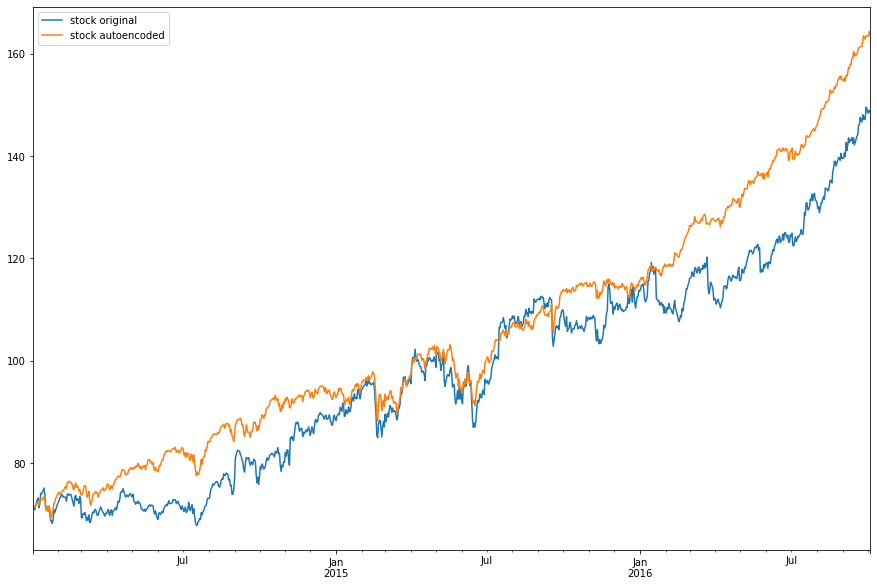

In [166]:
which_stock = 55

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].values, index=pd.date_range(start='2014/1/2', periods=1007, freq='d')).plot(figsize=(15,10),label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='2014/1/2', periods = 1007,freq='d')).plot(label='stock autoencoded', legend=True)

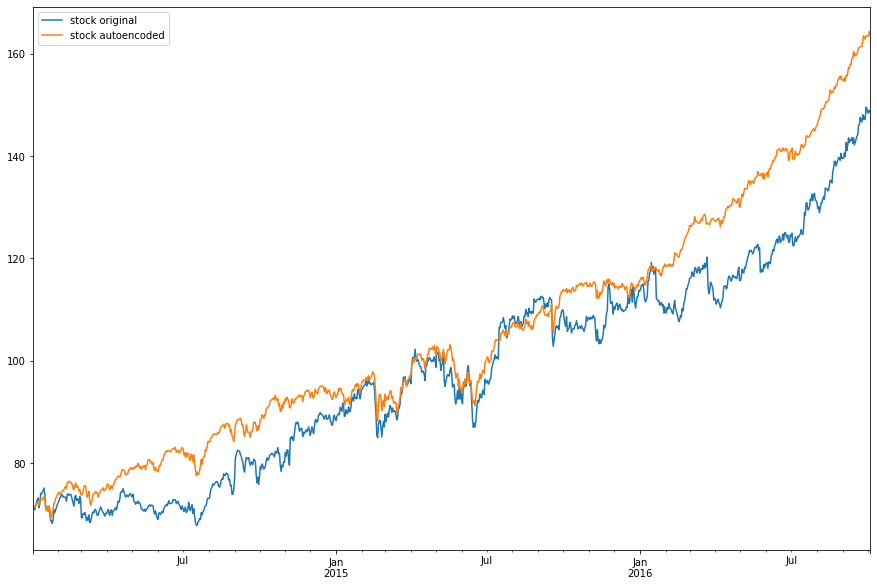

In [166]:
which_stock = 55

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].values, index=pd.date_range(start='2014/1/2', periods=1007, freq='d')).plot(figsize=(15,10),label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='2014/1/2', periods = 1007,freq='d')).plot(label='stock autoencoded', legend=True)

Let's have a look on how well this auto-encoder works on a certain stock.

# Phase 2: Calibrating

In [15]:
np.concatenate((ranking[0:10], ranking[-25:])) 

array([68, 65, 38, 76, 66, 79, 81, 77, 71, 52, 29, 70, 43, 12,  4, 35, 33,
       39, 22,  5,  8, 20, 30, 10,  2,  3,  6, 14, 11, 16,  0, 36,  9, 27,
        1])

In [17]:
ibb['calibrate']['percentage']

Date
6/1/2012      0.000000
13/1/2012     4.794329
20/1/2012     0.578549
27/1/2012     2.884956
3/2/2012      3.767418
                ...   
29/11/2013    1.599964
6/12/2013    -0.959136
13/12/2013   -2.936805
20/12/2013    3.809922
27/12/2013    0.992401
Name: % Change, Length: 104, dtype: float32

In [9]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 10)    # fit the model
    deep_learner.save('model/retrack_s' + str(s) + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - ibb['calibrate']['lp']))

Epoch 1/500
104/104 [==============================] - 0s 4ms/step - loss: 4.4957
Epoch 2/500
104/104 [==============================] - 0s 135us/step - loss: 2.5571
Epoch 3/500
104/104 [==============================] - 0s 108us/step - loss: 1.9356
Epoch 4/500
104/104 [==============================] - 0s 103us/step - loss: 1.5793
Epoch 5/500
104/104 [==============================] - 0s 103us/step - loss: 1.3418
Epoch 6/500
104/104 [==============================] - 0s 95us/step - loss: 1.1671
Epoch 7/500
104/104 [==============================] - 0s 98us/step - loss: 1.0384
Epoch 8/500
104/104 [==============================] - 0s 101us/step - loss: 0.9431
Epoch 9/500
104/104 [==============================] - 0s 95us/step - loss: 0.8720
Epoch 10/500
104/104 [==============================] - 0s 98us/step - loss: 0.8168
Epoch 11/500
104/104 [==============================] - 0s 96us/step - loss: 0.7725
Epoch 12/500
104/104 [==============================] - 0s 96us/step - loss: 0.73

104/104 [==============================] - 0s 95us/step - loss: 0.2889
Epoch 195/500
104/104 [==============================] - 0s 97us/step - loss: 0.2880
Epoch 196/500
104/104 [==============================] - 0s 98us/step - loss: 0.2875
Epoch 197/500
104/104 [==============================] - 0s 98us/step - loss: 0.2869
Epoch 198/500
104/104 [==============================] - 0s 94us/step - loss: 0.2871
Epoch 199/500
104/104 [==============================] - 0s 98us/step - loss: 0.2862
Epoch 200/500
104/104 [==============================] - 0s 93us/step - loss: 0.2861
Epoch 201/500
104/104 [==============================] - 0s 91us/step - loss: 0.2859
Epoch 202/500
104/104 [==============================] - 0s 92us/step - loss: 0.2853
Epoch 203/500
104/104 [==============================] - 0s 96us/step - loss: 0.2847
Epoch 204/500
104/104 [==============================] - 0s 92us/step - loss: 0.2847
Epoch 205/500
104/104 [==============================] - 0s 93us/step - loss: 0

104/104 [==============================] - 0s 93us/step - loss: 0.2395
Epoch 387/500
104/104 [==============================] - 0s 93us/step - loss: 0.2390
Epoch 388/500
104/104 [==============================] - 0s 89us/step - loss: 0.2394
Epoch 389/500
104/104 [==============================] - 0s 90us/step - loss: 0.2382
Epoch 390/500
104/104 [==============================] - 0s 94us/step - loss: 0.2384
Epoch 391/500
104/104 [==============================] - 0s 92us/step - loss: 0.2381
Epoch 392/500
104/104 [==============================] - 0s 90us/step - loss: 0.2371
Epoch 393/500
104/104 [==============================] - 0s 92us/step - loss: 0.2376
Epoch 394/500
104/104 [==============================] - 0s 91us/step - loss: 0.2368
Epoch 395/500
104/104 [==============================] - 0s 91us/step - loss: 0.2367
Epoch 396/500
104/104 [==============================] - 0s 90us/step - loss: 0.2368
Epoch 397/500
104/104 [==============================] - 0s 90us/step - loss: 0

104/104 [==============================] - 0s 97us/step - loss: 0.1906
Epoch 80/500
104/104 [==============================] - 0s 101us/step - loss: 0.1894
Epoch 81/500
104/104 [==============================] - 0s 95us/step - loss: 0.1884
Epoch 82/500
104/104 [==============================] - 0s 94us/step - loss: 0.1874
Epoch 83/500
104/104 [==============================] - 0s 97us/step - loss: 0.1863
Epoch 84/500
104/104 [==============================] - 0s 98us/step - loss: 0.1844
Epoch 85/500
104/104 [==============================] - 0s 93us/step - loss: 0.1849
Epoch 86/500
104/104 [==============================] - 0s 97us/step - loss: 0.1839
Epoch 87/500
104/104 [==============================] - 0s 95us/step - loss: 0.1829
Epoch 88/500
104/104 [==============================] - 0s 97us/step - loss: 0.1820
Epoch 89/500
104/104 [==============================] - 0s 96us/step - loss: 0.1812
Epoch 90/500
104/104 [==============================] - 0s 93us/step - loss: 0.1792
Epoc

104/104 [==============================] - 0s 100us/step - loss: 0.1011
Epoch 272/500
104/104 [==============================] - 0s 99us/step - loss: 0.1009
Epoch 273/500
104/104 [==============================] - 0s 99us/step - loss: 0.1007
Epoch 274/500
104/104 [==============================] - 0s 100us/step - loss: 0.1006
Epoch 275/500
104/104 [==============================] - 0s 100us/step - loss: 0.1003
Epoch 276/500
104/104 [==============================] - 0s 101us/step - loss: 0.1001
Epoch 277/500
104/104 [==============================] - 0s 102us/step - loss: 0.0998
Epoch 278/500
104/104 [==============================] - 0s 101us/step - loss: 0.0997
Epoch 279/500
104/104 [==============================] - 0s 99us/step - loss: 0.0995
Epoch 280/500
104/104 [==============================] - 0s 96us/step - loss: 0.0993
Epoch 281/500
104/104 [==============================] - 0s 94us/step - loss: 0.0991
Epoch 282/500
104/104 [==============================] - 0s 93us/step - l

104/104 [==============================] - 0s 101us/step - loss: 0.0844
Epoch 464/500
104/104 [==============================] - 0s 101us/step - loss: 0.0844
Epoch 465/500
104/104 [==============================] - 0s 102us/step - loss: 0.0844
Epoch 466/500
104/104 [==============================] - 0s 106us/step - loss: 0.0843
Epoch 467/500
104/104 [==============================] - 0s 104us/step - loss: 0.0843
Epoch 468/500
104/104 [==============================] - 0s 104us/step - loss: 0.0844
Epoch 469/500
104/104 [==============================] - 0s 103us/step - loss: 0.0842
Epoch 470/500
104/104 [==============================] - 0s 103us/step - loss: 0.0842
Epoch 471/500
104/104 [==============================] - 0s 100us/step - loss: 0.0843
Epoch 472/500
104/104 [==============================] - 0s 102us/step - loss: 0.0841
Epoch 473/500
104/104 [==============================] - 0s 103us/step - loss: 0.0841
Epoch 474/500
104/104 [==============================] - 0s 100us/st

104/104 [==============================] - 0s 96us/step - loss: 0.1391
Epoch 61/500
104/104 [==============================] - 0s 98us/step - loss: 0.1379
Epoch 62/500
104/104 [==============================] - 0s 95us/step - loss: 0.1367
Epoch 63/500
104/104 [==============================] - 0s 95us/step - loss: 0.1357
Epoch 64/500
104/104 [==============================] - 0s 97us/step - loss: 0.1345
Epoch 65/500
104/104 [==============================] - 0s 97us/step - loss: 0.1335
Epoch 66/500
104/104 [==============================] - 0s 97us/step - loss: 0.1326
Epoch 67/500
104/104 [==============================] - 0s 96us/step - loss: 0.1315
Epoch 68/500
104/104 [==============================] - 0s 98us/step - loss: 0.1305
Epoch 69/500
104/104 [==============================] - 0s 98us/step - loss: 0.1298
Epoch 70/500
104/104 [==============================] - 0s 94us/step - loss: 0.1286
Epoch 71/500
104/104 [==============================] - 0s 94us/step - loss: 0.1279
Epoch

Epoch 157/500
104/104 [==============================] - 0s 97us/step - loss: 0.0982
Epoch 158/500
104/104 [==============================] - 0s 98us/step - loss: 0.0982
Epoch 159/500
104/104 [==============================] - 0s 99us/step - loss: 0.0979
Epoch 160/500
104/104 [==============================] - 0s 97us/step - loss: 0.0978
Epoch 161/500
104/104 [==============================] - 0s 99us/step - loss: 0.0975
Epoch 162/500
104/104 [==============================] - 0s 100us/step - loss: 0.0974
Epoch 163/500
104/104 [==============================] - 0s 96us/step - loss: 0.0972
Epoch 164/500
104/104 [==============================] - 0s 96us/step - loss: 0.0970
Epoch 165/500
104/104 [==============================] - 0s 95us/step - loss: 0.0968
Epoch 166/500
104/104 [==============================] - 0s 93us/step - loss: 0.0967
Epoch 167/500
104/104 [==============================] - 0s 95us/step - loss: 0.0964
Epoch 168/500
104/104 [==============================] - 0s 98us

104/104 [==============================] - 0s 100us/step - loss: 0.0773
Epoch 350/500
104/104 [==============================] - 0s 102us/step - loss: 0.0773
Epoch 351/500
104/104 [==============================] - 0s 100us/step - loss: 0.0772
Epoch 352/500
104/104 [==============================] - 0s 94us/step - loss: 0.0770
Epoch 353/500
104/104 [==============================] - 0s 100us/step - loss: 0.0771
Epoch 354/500
104/104 [==============================] - 0s 98us/step - loss: 0.0770
Epoch 355/500
104/104 [==============================] - 0s 95us/step - loss: 0.0771
Epoch 356/500
104/104 [==============================] - 0s 96us/step - loss: 0.0769
Epoch 357/500
104/104 [==============================] - 0s 97us/step - loss: 0.0768
Epoch 358/500
104/104 [==============================] - 0s 98us/step - loss: 0.0767
Epoch 359/500
104/104 [==============================] - 0s 97us/step - loss: 0.0766
Epoch 360/500
104/104 [==============================] - 0s 99us/step - los

104/104 [==============================] - 0s 111us/step - loss: 0.0721
Epoch 446/500
104/104 [==============================] - 0s 104us/step - loss: 0.0720
Epoch 447/500
104/104 [==============================] - 0s 99us/step - loss: 0.0721
Epoch 448/500
104/104 [==============================] - 0s 96us/step - loss: 0.0720
Epoch 449/500
104/104 [==============================] - 0s 99us/step - loss: 0.0720
Epoch 450/500
104/104 [==============================] - 0s 95us/step - loss: 0.0719
Epoch 451/500
104/104 [==============================] - 0s 97us/step - loss: 0.0719
Epoch 452/500
104/104 [==============================] - 0s 97us/step - loss: 0.0718
Epoch 453/500
104/104 [==============================] - 0s 97us/step - loss: 0.0719
Epoch 454/500
104/104 [==============================] - 0s 99us/step - loss: 0.0717
Epoch 455/500
104/104 [==============================] - 0s 99us/step - loss: 0.0717
Epoch 456/500
104/104 [==============================] - 0s 101us/step - loss

Now we would like to see how similar these 3 portfolios perform as the original IBB Index does on training dates.

S25 2-norm difference:  13.322672
S45 2-norm difference:  14.25769
S65 2-norm difference:  1.4467665


/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


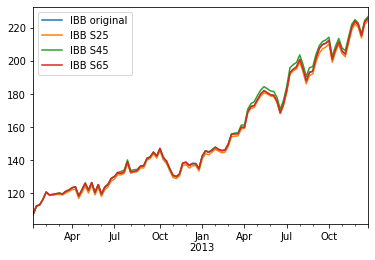

In [9]:
# plot results and 2-norm differences 
pd.Series(ibb['calibrate']['lp'].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='IBB original', legend=True)

for s in [25, 45, 65]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    
    


# Phase 3: Validating

In [10]:
for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/retrack_s' + str(s) + '.h5')
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))

Again, we would like to see how similar these 3 portfolios perform as the original IBB Index does, but on test dates.

/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


S25 2-norm difference:  354.84158
S45 2-norm difference:  546.2681
S65 2-norm difference:  282.7063


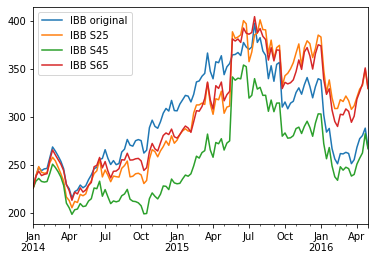

In [11]:
# plot results and 2-norm differences
pd.Series(ibb['validate']['lp'].as_matrix(), index=pd.date_range(start='01/03/2014', periods=122, freq='W')).plot(label='IBB original', legend=True) 

for s in [25, 45, 65]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='01/03/2014', periods = 122,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['validate'][s])  

# Phase 4: Verifying

- x-axis: 2-norm error  
- y-axis: # of stocks in the portfolios: 10, 11, 12, ..., 

From my perspective, Efficient Deep Frontier has nothing to do with the one in Modern Portfolio Theory. It just reflects the trade-off between more stocks in the portfolios and higher MSE.

In [12]:
error = []
for non_communal in range(5, 79, 1):  
    
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index


    # training
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x_train = stock['calibrate']['percentage'].iloc[:, stock_index]
    y_train = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=500, batch_size = 10)    # fit the model


    # testing
    x_test = stock['validate']['percentage'].iloc[:, stock_index]
    y_test = ibb['validate']['percentage']

    x_test = dl_scaler[s].transform(x_test)  
    
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    error.append(np.linalg.norm((predict_curve - ibb['validate']['lp'])))    

Epoch 1/500
104/104 [==============================] - 1s 5ms/step - loss: 4.8297
Epoch 2/500
104/104 [==============================] - 0s 100us/step - loss: 3.7927
Epoch 3/500
104/104 [==============================] - 0s 94us/step - loss: 3.1699
Epoch 4/500
104/104 [==============================] - 0s 97us/step - loss: 2.7247
Epoch 5/500
104/104 [==============================] - 0s 96us/step - loss: 2.4304
Epoch 6/500
104/104 [==============================] - 0s 94us/step - loss: 2.2416
Epoch 7/500
104/104 [==============================] - 0s 95us/step - loss: 2.1033
Epoch 8/500
104/104 [==============================] - 0s 93us/step - loss: 1.9926
Epoch 9/500
104/104 [==============================] - 0s 95us/step - loss: 1.8973
Epoch 10/500
104/104 [==============================] - 0s 102us/step - loss: 1.8157
Epoch 11/500
104/104 [==============================] - 0s 95us/step - loss: 1.7418
Epoch 12/500
104/104 [==============================] - 0s 99us/step - loss: 1.6743


104/104 [==============================] - 0s 101us/step - loss: 0.6659
Epoch 195/500
104/104 [==============================] - 0s 97us/step - loss: 0.6653
Epoch 196/500
104/104 [==============================] - 0s 98us/step - loss: 0.6628
Epoch 197/500
104/104 [==============================] - 0s 98us/step - loss: 0.6642
Epoch 198/500
104/104 [==============================] - 0s 97us/step - loss: 0.6636
Epoch 199/500
104/104 [==============================] - 0s 101us/step - loss: 0.6609
Epoch 200/500
104/104 [==============================] - 0s 99us/step - loss: 0.6627
Epoch 201/500
104/104 [==============================] - 0s 97us/step - loss: 0.6612
Epoch 202/500
104/104 [==============================] - 0s 99us/step - loss: 0.6596
Epoch 203/500
104/104 [==============================] - 0s 99us/step - loss: 0.6609
Epoch 204/500
104/104 [==============================] - 0s 97us/step - loss: 0.6598
Epoch 205/500
104/104 [==============================] - 0s 99us/step - loss:

104/104 [==============================] - 0s 100us/step - loss: 0.6128
Epoch 387/500
104/104 [==============================] - 0s 96us/step - loss: 0.6147
Epoch 388/500
104/104 [==============================] - 0s 100us/step - loss: 0.6140
Epoch 389/500
104/104 [==============================] - 0s 97us/step - loss: 0.6155
Epoch 390/500
104/104 [==============================] - 0s 94us/step - loss: 0.6130
Epoch 391/500
104/104 [==============================] - 0s 97us/step - loss: 0.6135
Epoch 392/500
104/104 [==============================] - 0s 96us/step - loss: 0.6142
Epoch 393/500
104/104 [==============================] - 0s 94us/step - loss: 0.6150
Epoch 394/500
104/104 [==============================] - 0s 97us/step - loss: 0.6131
Epoch 395/500
104/104 [==============================] - 0s 95us/step - loss: 0.6127
Epoch 396/500
104/104 [==============================] - 0s 98us/step - loss: 0.6132
Epoch 397/500
104/104 [==============================] - 0s 97us/step - loss:

104/104 [==============================] - 0s 100us/step - loss: 0.6103
Epoch 483/500
104/104 [==============================] - 0s 103us/step - loss: 0.6100
Epoch 484/500
104/104 [==============================] - 0s 97us/step - loss: 0.6110
Epoch 485/500
104/104 [==============================] - 0s 99us/step - loss: 0.6085
Epoch 486/500
104/104 [==============================] - 0s 103us/step - loss: 0.6100
Epoch 487/500
104/104 [==============================] - 0s 97us/step - loss: 0.6116
Epoch 488/500
104/104 [==============================] - 0s 101us/step - loss: 0.6096
Epoch 489/500
104/104 [==============================] - 0s 107us/step - loss: 0.6103
Epoch 490/500
104/104 [==============================] - 0s 100us/step - loss: 0.6095
Epoch 491/500
104/104 [==============================] - 0s 101us/step - loss: 0.6100
Epoch 492/500
104/104 [==============================] - 0s 96us/step - loss: 0.6103
Epoch 493/500
104/104 [==============================] - 0s 96us/step - 

104/104 [==============================] - 0s 102us/step - loss: 0.7158
Epoch 176/500
104/104 [==============================] - 0s 104us/step - loss: 0.7133
Epoch 177/500
104/104 [==============================] - 0s 95us/step - loss: 0.7125
Epoch 178/500
104/104 [==============================] - 0s 92us/step - loss: 0.7107
Epoch 179/500
104/104 [==============================] - 0s 96us/step - loss: 0.7109
Epoch 180/500
104/104 [==============================] - 0s 94us/step - loss: 0.7092
Epoch 181/500
104/104 [==============================] - 0s 92us/step - loss: 0.7067
Epoch 182/500
104/104 [==============================] - 0s 95us/step - loss: 0.7080
Epoch 183/500
104/104 [==============================] - 0s 93us/step - loss: 0.7060
Epoch 184/500
104/104 [==============================] - 0s 95us/step - loss: 0.7041
Epoch 185/500
104/104 [==============================] - 0s 101us/step - loss: 0.7050
Epoch 186/500
104/104 [==============================] - 0s 95us/step - loss

104/104 [==============================] - 0s 112us/step - loss: 0.6229
Epoch 366/500
104/104 [==============================] - 0s 108us/step - loss: 0.6252
Epoch 367/500
104/104 [==============================] - 0s 105us/step - loss: 0.6235
Epoch 368/500
104/104 [==============================] - 0s 102us/step - loss: 0.6261
Epoch 369/500
104/104 [==============================] - 0s 109us/step - loss: 0.6234
Epoch 370/500
104/104 [==============================] - 0s 117us/step - loss: 0.6232
Epoch 371/500
104/104 [==============================] - 0s 109us/step - loss: 0.6228
Epoch 372/500
104/104 [==============================] - 0s 102us/step - loss: 0.6232
Epoch 373/500
104/104 [==============================] - 0s 110us/step - loss: 0.6235
Epoch 374/500
104/104 [==============================] - 0s 108us/step - loss: 0.6220
Epoch 375/500
104/104 [==============================] - 0s 103us/step - loss: 0.6227
Epoch 376/500
104/104 [==============================] - 0s 103us/st

104/104 [==============================] - 0s 107us/step - loss: 0.8877
Epoch 57/500
104/104 [==============================] - 0s 103us/step - loss: 0.8792
Epoch 58/500
104/104 [==============================] - 0s 102us/step - loss: 0.8739
Epoch 59/500
104/104 [==============================] - 0s 99us/step - loss: 0.8689
Epoch 60/500
104/104 [==============================] - 0s 105us/step - loss: 0.8650
Epoch 61/500
104/104 [==============================] - 0s 108us/step - loss: 0.8581
Epoch 62/500
104/104 [==============================] - 0s 100us/step - loss: 0.8541
Epoch 63/500
104/104 [==============================] - 0s 103us/step - loss: 0.8490
Epoch 64/500
104/104 [==============================] - 0s 100us/step - loss: 0.8453
Epoch 65/500
104/104 [==============================] - 0s 101us/step - loss: 0.8413
Epoch 66/500
104/104 [==============================] - 0s 101us/step - loss: 0.8365
Epoch 67/500
104/104 [==============================] - 0s 106us/step - loss: 0

104/104 [==============================] - 0s 105us/step - loss: 0.6529
Epoch 153/500
104/104 [==============================] - 0s 108us/step - loss: 0.6500
Epoch 154/500
104/104 [==============================] - 0s 99us/step - loss: 0.6515
Epoch 155/500
104/104 [==============================] - 0s 97us/step - loss: 0.6499
Epoch 156/500
104/104 [==============================] - 0s 97us/step - loss: 0.6486
Epoch 157/500
104/104 [==============================] - 0s 108us/step - loss: 0.6480
Epoch 158/500
104/104 [==============================] - 0s 107us/step - loss: 0.6472
Epoch 159/500
104/104 [==============================] - 0s 97us/step - loss: 0.6473
Epoch 160/500
104/104 [==============================] - 0s 102us/step - loss: 0.6454
Epoch 161/500
104/104 [==============================] - 0s 100us/step - loss: 0.6460
Epoch 162/500
104/104 [==============================] - 0s 100us/step - loss: 0.6438
Epoch 163/500
104/104 [==============================] - 0s 100us/step -

104/104 [==============================] - 0s 116us/step - loss: 0.5806
Epoch 343/500
104/104 [==============================] - 0s 105us/step - loss: 0.5788
Epoch 344/500
104/104 [==============================] - 0s 104us/step - loss: 0.5769
Epoch 345/500
104/104 [==============================] - 0s 105us/step - loss: 0.5780
Epoch 346/500
104/104 [==============================] - 0s 100us/step - loss: 0.5771
Epoch 347/500
104/104 [==============================] - 0s 102us/step - loss: 0.5779
Epoch 348/500
104/104 [==============================] - 0s 104us/step - loss: 0.5771
Epoch 349/500
104/104 [==============================] - 0s 100us/step - loss: 0.5768
Epoch 350/500
104/104 [==============================] - 0s 111us/step - loss: 0.5757
Epoch 351/500
104/104 [==============================] - 0s 114us/step - loss: 0.5773
Epoch 352/500
104/104 [==============================] - 0s 107us/step - loss: 0.5768
Epoch 353/500
104/104 [==============================] - 0s 103us/st

Epoch 33/500
104/104 [==============================] - 0s 104us/step - loss: 0.8783
Epoch 34/500
104/104 [==============================] - 0s 102us/step - loss: 0.8729
Epoch 35/500
104/104 [==============================] - 0s 105us/step - loss: 0.8650
Epoch 36/500
104/104 [==============================] - 0s 105us/step - loss: 0.8606
Epoch 37/500
104/104 [==============================] - 0s 110us/step - loss: 0.8549
Epoch 38/500
104/104 [==============================] - 0s 111us/step - loss: 0.8481
Epoch 39/500
104/104 [==============================] - 0s 104us/step - loss: 0.8439
Epoch 40/500
104/104 [==============================] - 0s 108us/step - loss: 0.8369
Epoch 41/500
104/104 [==============================] - 0s 112us/step - loss: 0.8342
Epoch 42/500
104/104 [==============================] - 0s 111us/step - loss: 0.8291
Epoch 43/500
104/104 [==============================] - 0s 104us/step - loss: 0.8239
Epoch 44/500
104/104 [==============================] - 0s 109us/

104/104 [==============================] - 0s 103us/step - loss: 0.6220
Epoch 130/500
104/104 [==============================] - 0s 104us/step - loss: 0.6214
Epoch 131/500
104/104 [==============================] - 0s 104us/step - loss: 0.6213
Epoch 132/500
104/104 [==============================] - 0s 106us/step - loss: 0.6184
Epoch 133/500
104/104 [==============================] - 0s 109us/step - loss: 0.6169
Epoch 134/500
104/104 [==============================] - 0s 108us/step - loss: 0.6145
Epoch 135/500
104/104 [==============================] - 0s 106us/step - loss: 0.6137
Epoch 136/500
104/104 [==============================] - 0s 99us/step - loss: 0.6137
Epoch 137/500
104/104 [==============================] - 0s 101us/step - loss: 0.6112
Epoch 138/500
104/104 [==============================] - 0s 103us/step - loss: 0.6105
Epoch 139/500
104/104 [==============================] - 0s 102us/step - loss: 0.6098
Epoch 140/500
104/104 [==============================] - 0s 107us/ste

104/104 [==============================] - 0s 110us/step - loss: 0.4313
Epoch 320/500
104/104 [==============================] - 0s 110us/step - loss: 0.4302
Epoch 321/500
104/104 [==============================] - 0s 106us/step - loss: 0.4282
Epoch 322/500
104/104 [==============================] - 0s 109us/step - loss: 0.4321
Epoch 323/500
104/104 [==============================] - 0s 116us/step - loss: 0.4286
Epoch 324/500
104/104 [==============================] - 0s 114us/step - loss: 0.4296
Epoch 325/500
104/104 [==============================] - 0s 113us/step - loss: 0.4295
Epoch 326/500
104/104 [==============================] - 0s 113us/step - loss: 0.4304
Epoch 327/500
104/104 [==============================] - 0s 112us/step - loss: 0.4282
Epoch 328/500
104/104 [==============================] - 0s 112us/step - loss: 0.4301
Epoch 329/500
104/104 [==============================] - 0s 99us/step - loss: 0.4299
Epoch 330/500
104/104 [==============================] - 0s 103us/ste

104/104 [==============================] - 0s 118us/step - loss: 1.8196
Epoch 10/500
104/104 [==============================] - 0s 116us/step - loss: 1.6836
Epoch 11/500
104/104 [==============================] - 0s 109us/step - loss: 1.5695
Epoch 12/500
104/104 [==============================] - 0s 109us/step - loss: 1.4778
Epoch 13/500
104/104 [==============================] - 0s 120us/step - loss: 1.4011
Epoch 14/500
104/104 [==============================] - 0s 116us/step - loss: 1.3263
Epoch 15/500
104/104 [==============================] - 0s 107us/step - loss: 1.2635
Epoch 16/500
104/104 [==============================] - 0s 120us/step - loss: 1.2100
Epoch 17/500
104/104 [==============================] - 0s 119us/step - loss: 1.1683
Epoch 18/500
104/104 [==============================] - 0s 119us/step - loss: 1.1292
Epoch 19/500
104/104 [==============================] - 0s 116us/step - loss: 1.0942
Epoch 20/500
104/104 [==============================] - 0s 118us/step - loss: 

104/104 [==============================] - 0s 109us/step - loss: 0.3815
Epoch 201/500
104/104 [==============================] - 0s 123us/step - loss: 0.3803
Epoch 202/500
104/104 [==============================] - 0s 114us/step - loss: 0.3792
Epoch 203/500
104/104 [==============================] - 0s 108us/step - loss: 0.3781
Epoch 204/500
104/104 [==============================] - 0s 102us/step - loss: 0.3773
Epoch 205/500
104/104 [==============================] - 0s 103us/step - loss: 0.3768
Epoch 206/500
104/104 [==============================] - 0s 109us/step - loss: 0.3765
Epoch 207/500
104/104 [==============================] - 0s 111us/step - loss: 0.3744
Epoch 208/500
104/104 [==============================] - 0s 112us/step - loss: 0.3745
Epoch 209/500
104/104 [==============================] - 0s 105us/step - loss: 0.3732
Epoch 210/500
104/104 [==============================] - 0s 114us/step - loss: 0.3720
Epoch 211/500
104/104 [==============================] - 0s 111us/st

104/104 [==============================] - 0s 126us/step - loss: 0.2984
Epoch 391/500
104/104 [==============================] - 0s 126us/step - loss: 0.2979
Epoch 392/500
104/104 [==============================] - 0s 128us/step - loss: 0.2981
Epoch 393/500
104/104 [==============================] - 0s 128us/step - loss: 0.2979
Epoch 394/500
104/104 [==============================] - 0s 129us/step - loss: 0.2975
Epoch 395/500
104/104 [==============================] - 0s 139us/step - loss: 0.2974
Epoch 396/500
104/104 [==============================] - 0s 135us/step - loss: 0.2978
Epoch 397/500
104/104 [==============================] - 0s 121us/step - loss: 0.2968
Epoch 398/500
104/104 [==============================] - 0s 130us/step - loss: 0.2983
Epoch 399/500
104/104 [==============================] - 0s 125us/step - loss: 0.2977
Epoch 400/500
104/104 [==============================] - 0s 117us/step - loss: 0.2977
Epoch 401/500
104/104 [==============================] - 0s 123us/st

104/104 [==============================] - 0s 117us/step - loss: 0.4229
Epoch 82/500
104/104 [==============================] - 0s 116us/step - loss: 0.4217
Epoch 83/500
104/104 [==============================] - 0s 113us/step - loss: 0.4197
Epoch 84/500
104/104 [==============================] - 0s 109us/step - loss: 0.4165
Epoch 85/500
104/104 [==============================] - 0s 112us/step - loss: 0.4164
Epoch 86/500
104/104 [==============================] - 0s 110us/step - loss: 0.4142
Epoch 87/500
104/104 [==============================] - 0s 114us/step - loss: 0.4119
Epoch 88/500
104/104 [==============================] - 0s 114us/step - loss: 0.4107
Epoch 89/500
104/104 [==============================] - 0s 121us/step - loss: 0.4100
Epoch 90/500
104/104 [==============================] - 0s 115us/step - loss: 0.4068
Epoch 91/500
104/104 [==============================] - 0s 118us/step - loss: 0.4068
Epoch 92/500
104/104 [==============================] - 0s 115us/step - loss: 

104/104 [==============================] - 0s 113us/step - loss: 0.2842
Epoch 272/500
104/104 [==============================] - 0s 116us/step - loss: 0.2854
Epoch 273/500
104/104 [==============================] - 0s 115us/step - loss: 0.2839
Epoch 274/500
104/104 [==============================] - 0s 121us/step - loss: 0.2845
Epoch 275/500
104/104 [==============================] - 0s 113us/step - loss: 0.2837
Epoch 276/500
104/104 [==============================] - 0s 116us/step - loss: 0.2833
Epoch 277/500
104/104 [==============================] - 0s 117us/step - loss: 0.2844
Epoch 278/500
104/104 [==============================] - 0s 114us/step - loss: 0.2834
Epoch 279/500
104/104 [==============================] - 0s 112us/step - loss: 0.2834
Epoch 280/500
104/104 [==============================] - 0s 113us/step - loss: 0.2838
Epoch 281/500
104/104 [==============================] - 0s 121us/step - loss: 0.2818
Epoch 282/500
104/104 [==============================] - 0s 117us/st

104/104 [==============================] - 0s 118us/step - loss: 0.2692
Epoch 462/500
104/104 [==============================] - 0s 120us/step - loss: 0.2693
Epoch 463/500
104/104 [==============================] - 0s 119us/step - loss: 0.2690
Epoch 464/500
104/104 [==============================] - 0s 118us/step - loss: 0.2684
Epoch 465/500
104/104 [==============================] - 0s 113us/step - loss: 0.2691
Epoch 466/500
104/104 [==============================] - 0s 118us/step - loss: 0.2682
Epoch 467/500
104/104 [==============================] - 0s 116us/step - loss: 0.2688
Epoch 468/500
104/104 [==============================] - 0s 117us/step - loss: 0.2686
Epoch 469/500
104/104 [==============================] - 0s 115us/step - loss: 0.2679
Epoch 470/500
104/104 [==============================] - 0s 123us/step - loss: 0.2681
Epoch 471/500
104/104 [==============================] - 0s 118us/step - loss: 0.2683
Epoch 472/500
104/104 [==============================] - 0s 114us/st

104/104 [==============================] - 0s 119us/step - loss: 0.3392
Epoch 153/500
104/104 [==============================] - 0s 119us/step - loss: 0.3382
Epoch 154/500
104/104 [==============================] - 0s 120us/step - loss: 0.3365
Epoch 155/500
104/104 [==============================] - 0s 114us/step - loss: 0.3362
Epoch 156/500
104/104 [==============================] - 0s 115us/step - loss: 0.3348
Epoch 157/500
104/104 [==============================] - 0s 117us/step - loss: 0.3342
Epoch 158/500
104/104 [==============================] - 0s 116us/step - loss: 0.3335
Epoch 159/500
104/104 [==============================] - 0s 116us/step - loss: 0.3320
Epoch 160/500
104/104 [==============================] - 0s 121us/step - loss: 0.3318
Epoch 161/500
104/104 [==============================] - 0s 119us/step - loss: 0.3305
Epoch 162/500
104/104 [==============================] - 0s 118us/step - loss: 0.3298
Epoch 163/500
104/104 [==============================] - 0s 116us/st

104/104 [==============================] - 0s 117us/step - loss: 0.2740
Epoch 343/500
104/104 [==============================] - 0s 112us/step - loss: 0.2737
Epoch 344/500
104/104 [==============================] - 0s 121us/step - loss: 0.2733
Epoch 345/500
104/104 [==============================] - 0s 124us/step - loss: 0.2741
Epoch 346/500
104/104 [==============================] - 0s 126us/step - loss: 0.2731
Epoch 347/500
104/104 [==============================] - 0s 127us/step - loss: 0.2730
Epoch 348/500
104/104 [==============================] - 0s 126us/step - loss: 0.2728
Epoch 349/500
104/104 [==============================] - 0s 128us/step - loss: 0.2725
Epoch 350/500
104/104 [==============================] - 0s 120us/step - loss: 0.2726
Epoch 351/500
104/104 [==============================] - 0s 124us/step - loss: 0.2724
Epoch 352/500
104/104 [==============================] - 0s 123us/step - loss: 0.2722
Epoch 353/500
104/104 [==============================] - 0s 129us/st

Epoch 33/500
104/104 [==============================] - 0s 110us/step - loss: 0.6363
Epoch 34/500
104/104 [==============================] - 0s 109us/step - loss: 0.6260
Epoch 35/500
104/104 [==============================] - 0s 112us/step - loss: 0.6179
Epoch 36/500
104/104 [==============================] - 0s 115us/step - loss: 0.6091
Epoch 37/500
104/104 [==============================] - 0s 114us/step - loss: 0.6013
Epoch 38/500
104/104 [==============================] - 0s 105us/step - loss: 0.5933
Epoch 39/500
104/104 [==============================] - 0s 109us/step - loss: 0.5854
Epoch 40/500
104/104 [==============================] - 0s 114us/step - loss: 0.5802
Epoch 41/500
104/104 [==============================] - 0s 110us/step - loss: 0.5744
Epoch 42/500
104/104 [==============================] - 0s 109us/step - loss: 0.5691
Epoch 43/500
104/104 [==============================] - 0s 106us/step - loss: 0.5636
Epoch 44/500
104/104 [==============================] - 0s 113us/

104/104 [==============================] - 0s 115us/step - loss: 0.3743
Epoch 130/500
104/104 [==============================] - 0s 115us/step - loss: 0.3693
Epoch 131/500
104/104 [==============================] - 0s 113us/step - loss: 0.3653
Epoch 132/500
104/104 [==============================] - 0s 115us/step - loss: 0.3609
Epoch 133/500
104/104 [==============================] - 0s 115us/step - loss: 0.3597
Epoch 134/500
104/104 [==============================] - 0s 112us/step - loss: 0.3562
Epoch 135/500
104/104 [==============================] - 0s 115us/step - loss: 0.3542
Epoch 136/500
104/104 [==============================] - 0s 119us/step - loss: 0.3523
Epoch 137/500
104/104 [==============================] - 0s 118us/step - loss: 0.3513
Epoch 138/500
104/104 [==============================] - 0s 119us/step - loss: 0.3499
Epoch 139/500
104/104 [==============================] - 0s 111us/step - loss: 0.3480
Epoch 140/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 122us/step - loss: 0.3001
Epoch 320/500
104/104 [==============================] - 0s 116us/step - loss: 0.3006
Epoch 321/500
104/104 [==============================] - 0s 115us/step - loss: 0.3010
Epoch 322/500
104/104 [==============================] - 0s 113us/step - loss: 0.2998
Epoch 323/500
104/104 [==============================] - 0s 117us/step - loss: 0.2999
Epoch 324/500
104/104 [==============================] - 0s 118us/step - loss: 0.3001
Epoch 325/500
104/104 [==============================] - 0s 114us/step - loss: 0.2999
Epoch 326/500
104/104 [==============================] - 0s 112us/step - loss: 0.2992
Epoch 327/500
104/104 [==============================] - 0s 117us/step - loss: 0.3002
Epoch 328/500
104/104 [==============================] - 0s 119us/step - loss: 0.3000
Epoch 329/500
104/104 [==============================] - 0s 115us/step - loss: 0.2992
Epoch 330/500
104/104 [==============================] - 0s 112us/st

104/104 [==============================] - 0s 106us/step - loss: 1.3176
Epoch 10/500
104/104 [==============================] - 0s 108us/step - loss: 1.2435
Epoch 11/500
104/104 [==============================] - 0s 102us/step - loss: 1.1862
Epoch 12/500
104/104 [==============================] - 0s 101us/step - loss: 1.1400
Epoch 13/500
104/104 [==============================] - 0s 104us/step - loss: 1.1027
Epoch 14/500
104/104 [==============================] - 0s 109us/step - loss: 1.0597
Epoch 15/500
104/104 [==============================] - 0s 103us/step - loss: 1.0178
Epoch 16/500
104/104 [==============================] - 0s 104us/step - loss: 0.9797
Epoch 17/500
104/104 [==============================] - 0s 104us/step - loss: 0.9427
Epoch 18/500
104/104 [==============================] - 0s 101us/step - loss: 0.8953
Epoch 19/500
104/104 [==============================] - 0s 111us/step - loss: 0.8513
Epoch 20/500
104/104 [==============================] - 0s 110us/step - loss: 

104/104 [==============================] - 0s 121us/step - loss: 0.3095
Epoch 201/500
104/104 [==============================] - 0s 126us/step - loss: 0.3088
Epoch 202/500
104/104 [==============================] - 0s 119us/step - loss: 0.3091
Epoch 203/500
104/104 [==============================] - 0s 118us/step - loss: 0.3076
Epoch 204/500
104/104 [==============================] - 0s 124us/step - loss: 0.3074
Epoch 205/500
104/104 [==============================] - 0s 129us/step - loss: 0.3065
Epoch 206/500
104/104 [==============================] - 0s 126us/step - loss: 0.3062
Epoch 207/500
104/104 [==============================] - 0s 126us/step - loss: 0.3059
Epoch 208/500
104/104 [==============================] - 0s 124us/step - loss: 0.3046
Epoch 209/500
104/104 [==============================] - 0s 127us/step - loss: 0.3041
Epoch 210/500
104/104 [==============================] - 0s 126us/step - loss: 0.3038
Epoch 211/500
104/104 [==============================] - 0s 127us/st

104/104 [==============================] - 0s 121us/step - loss: 0.2367
Epoch 391/500
104/104 [==============================] - 0s 124us/step - loss: 0.2362
Epoch 392/500
104/104 [==============================] - 0s 117us/step - loss: 0.2359
Epoch 393/500
104/104 [==============================] - 0s 123us/step - loss: 0.2356
Epoch 394/500
104/104 [==============================] - 0s 124us/step - loss: 0.2360
Epoch 395/500
104/104 [==============================] - 0s 125us/step - loss: 0.2351
Epoch 396/500
104/104 [==============================] - 0s 120us/step - loss: 0.2355
Epoch 397/500
104/104 [==============================] - 0s 116us/step - loss: 0.2350
Epoch 398/500
104/104 [==============================] - 0s 123us/step - loss: 0.2347
Epoch 399/500
104/104 [==============================] - 0s 136us/step - loss: 0.2345
Epoch 400/500
104/104 [==============================] - 0s 133us/step - loss: 0.2345
Epoch 401/500
104/104 [==============================] - 0s 122us/st

104/104 [==============================] - 0s 120us/step - loss: 0.4551
Epoch 82/500
104/104 [==============================] - 0s 118us/step - loss: 0.4517
Epoch 83/500
104/104 [==============================] - 0s 113us/step - loss: 0.4500
Epoch 84/500
104/104 [==============================] - 0s 116us/step - loss: 0.4481
Epoch 85/500
104/104 [==============================] - 0s 115us/step - loss: 0.4457
Epoch 86/500
104/104 [==============================] - 0s 115us/step - loss: 0.4427
Epoch 87/500
104/104 [==============================] - 0s 110us/step - loss: 0.4410
Epoch 88/500
104/104 [==============================] - 0s 116us/step - loss: 0.4382
Epoch 89/500
104/104 [==============================] - 0s 116us/step - loss: 0.4358
Epoch 90/500
104/104 [==============================] - 0s 115us/step - loss: 0.4327
Epoch 91/500
104/104 [==============================] - 0s 110us/step - loss: 0.4314
Epoch 92/500
104/104 [==============================] - 0s 116us/step - loss: 

104/104 [==============================] - 0s 115us/step - loss: 0.2451
Epoch 272/500
104/104 [==============================] - 0s 120us/step - loss: 0.2445
Epoch 273/500
104/104 [==============================] - 0s 121us/step - loss: 0.2448
Epoch 274/500
104/104 [==============================] - 0s 119us/step - loss: 0.2436
Epoch 275/500
104/104 [==============================] - 0s 118us/step - loss: 0.2434
Epoch 276/500
104/104 [==============================] - 0s 121us/step - loss: 0.2433
Epoch 277/500
104/104 [==============================] - 0s 123us/step - loss: 0.2428
Epoch 278/500
104/104 [==============================] - 0s 121us/step - loss: 0.2419
Epoch 279/500
104/104 [==============================] - 0s 123us/step - loss: 0.2424
Epoch 280/500
104/104 [==============================] - 0s 117us/step - loss: 0.2418
Epoch 281/500
104/104 [==============================] - 0s 120us/step - loss: 0.2409
Epoch 282/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 115us/step - loss: 0.2103
Epoch 462/500
104/104 [==============================] - 0s 116us/step - loss: 0.2110
Epoch 463/500
104/104 [==============================] - 0s 124us/step - loss: 0.2100
Epoch 464/500
104/104 [==============================] - 0s 119us/step - loss: 0.2103
Epoch 465/500
104/104 [==============================] - 0s 119us/step - loss: 0.2102
Epoch 466/500
104/104 [==============================] - 0s 116us/step - loss: 0.2103
Epoch 467/500
104/104 [==============================] - 0s 120us/step - loss: 0.2091
Epoch 468/500
104/104 [==============================] - 0s 118us/step - loss: 0.2101
Epoch 469/500
104/104 [==============================] - 0s 119us/step - loss: 0.2107
Epoch 470/500
104/104 [==============================] - 0s 116us/step - loss: 0.2101
Epoch 471/500
104/104 [==============================] - 0s 119us/step - loss: 0.2096
Epoch 472/500
104/104 [==============================] - 0s 120us/st

104/104 [==============================] - 0s 115us/step - loss: 0.2742
Epoch 153/500
104/104 [==============================] - 0s 113us/step - loss: 0.2732
Epoch 154/500
104/104 [==============================] - 0s 116us/step - loss: 0.2722
Epoch 155/500
104/104 [==============================] - 0s 118us/step - loss: 0.2717
Epoch 156/500
104/104 [==============================] - 0s 117us/step - loss: 0.2708
Epoch 157/500
104/104 [==============================] - 0s 113us/step - loss: 0.2695
Epoch 158/500
104/104 [==============================] - 0s 114us/step - loss: 0.2679
Epoch 159/500
104/104 [==============================] - 0s 119us/step - loss: 0.2666
Epoch 160/500
104/104 [==============================] - 0s 115us/step - loss: 0.2656
Epoch 161/500
104/104 [==============================] - 0s 114us/step - loss: 0.2647
Epoch 162/500
104/104 [==============================] - 0s 113us/step - loss: 0.2635
Epoch 163/500
104/104 [==============================] - 0s 117us/st

104/104 [==============================] - 0s 120us/step - loss: 0.1885
Epoch 343/500
104/104 [==============================] - 0s 121us/step - loss: 0.1885
Epoch 344/500
104/104 [==============================] - 0s 118us/step - loss: 0.1881
Epoch 345/500
104/104 [==============================] - 0s 119us/step - loss: 0.1880
Epoch 346/500
104/104 [==============================] - 0s 117us/step - loss: 0.1881
Epoch 347/500
104/104 [==============================] - 0s 133us/step - loss: 0.1876
Epoch 348/500
104/104 [==============================] - 0s 135us/step - loss: 0.1876
Epoch 349/500
104/104 [==============================] - 0s 126us/step - loss: 0.1875
Epoch 350/500
104/104 [==============================] - 0s 124us/step - loss: 0.1874
Epoch 351/500
104/104 [==============================] - 0s 125us/step - loss: 0.1870
Epoch 352/500
104/104 [==============================] - 0s 117us/step - loss: 0.1872
Epoch 353/500
104/104 [==============================] - 0s 120us/st

Epoch 33/500
104/104 [==============================] - 0s 121us/step - loss: 0.5507
Epoch 34/500
104/104 [==============================] - 0s 119us/step - loss: 0.5428
Epoch 35/500
104/104 [==============================] - 0s 111us/step - loss: 0.5353
Epoch 36/500
104/104 [==============================] - 0s 113us/step - loss: 0.5279
Epoch 37/500
104/104 [==============================] - 0s 106us/step - loss: 0.5212
Epoch 38/500
104/104 [==============================] - 0s 107us/step - loss: 0.5144
Epoch 39/500
104/104 [==============================] - 0s 118us/step - loss: 0.5081
Epoch 40/500
104/104 [==============================] - 0s 117us/step - loss: 0.5023
Epoch 41/500
104/104 [==============================] - 0s 111us/step - loss: 0.4967
Epoch 42/500
104/104 [==============================] - 0s 108us/step - loss: 0.4913
Epoch 43/500
104/104 [==============================] - 0s 116us/step - loss: 0.4861
Epoch 44/500
104/104 [==============================] - 0s 113us/

104/104 [==============================] - 0s 116us/step - loss: 0.2911
Epoch 130/500
104/104 [==============================] - 0s 116us/step - loss: 0.2879
Epoch 131/500
104/104 [==============================] - 0s 119us/step - loss: 0.2871
Epoch 132/500
104/104 [==============================] - 0s 112us/step - loss: 0.2859
Epoch 133/500
104/104 [==============================] - 0s 116us/step - loss: 0.2840
Epoch 134/500
104/104 [==============================] - 0s 121us/step - loss: 0.2816
Epoch 135/500
104/104 [==============================] - 0s 116us/step - loss: 0.2821
Epoch 136/500
104/104 [==============================] - 0s 111us/step - loss: 0.2794
Epoch 137/500
104/104 [==============================] - 0s 116us/step - loss: 0.2780
Epoch 138/500
104/104 [==============================] - 0s 115us/step - loss: 0.2780
Epoch 139/500
104/104 [==============================] - 0s 116us/step - loss: 0.2758
Epoch 140/500
104/104 [==============================] - 0s 110us/st

104/104 [==============================] - 0s 115us/step - loss: 0.2131
Epoch 320/500
104/104 [==============================] - 0s 114us/step - loss: 0.2138
Epoch 321/500
104/104 [==============================] - 0s 116us/step - loss: 0.2126
Epoch 322/500
104/104 [==============================] - 0s 120us/step - loss: 0.2128
Epoch 323/500
104/104 [==============================] - 0s 118us/step - loss: 0.2125
Epoch 324/500
104/104 [==============================] - 0s 114us/step - loss: 0.2132
Epoch 325/500
104/104 [==============================] - 0s 114us/step - loss: 0.2124
Epoch 326/500
104/104 [==============================] - 0s 119us/step - loss: 0.2123
Epoch 327/500
104/104 [==============================] - 0s 118us/step - loss: 0.2121
Epoch 328/500
104/104 [==============================] - 0s 120us/step - loss: 0.2120
Epoch 329/500
104/104 [==============================] - 0s 115us/step - loss: 0.2128
Epoch 330/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 107us/step - loss: 0.8180
Epoch 10/500
104/104 [==============================] - 0s 104us/step - loss: 0.7697
Epoch 11/500
104/104 [==============================] - 0s 100us/step - loss: 0.7190
Epoch 12/500
104/104 [==============================] - 0s 108us/step - loss: 0.6781
Epoch 13/500
104/104 [==============================] - 0s 104us/step - loss: 0.6440
Epoch 14/500
104/104 [==============================] - 0s 101us/step - loss: 0.6164
Epoch 15/500
104/104 [==============================] - 0s 104us/step - loss: 0.5926
Epoch 16/500
104/104 [==============================] - 0s 106us/step - loss: 0.5731
Epoch 17/500
104/104 [==============================] - 0s 109us/step - loss: 0.5557
Epoch 18/500
104/104 [==============================] - 0s 108us/step - loss: 0.5411
Epoch 19/500
104/104 [==============================] - 0s 107us/step - loss: 0.5266
Epoch 20/500
104/104 [==============================] - 0s 104us/step - loss: 

104/104 [==============================] - 0s 124us/step - loss: 0.2238
Epoch 201/500
104/104 [==============================] - 0s 117us/step - loss: 0.2239
Epoch 202/500
104/104 [==============================] - 0s 113us/step - loss: 0.2232
Epoch 203/500
104/104 [==============================] - 0s 117us/step - loss: 0.2220
Epoch 204/500
104/104 [==============================] - 0s 118us/step - loss: 0.2229
Epoch 205/500
104/104 [==============================] - 0s 116us/step - loss: 0.2222
Epoch 206/500
104/104 [==============================] - 0s 113us/step - loss: 0.2220
Epoch 207/500
104/104 [==============================] - 0s 115us/step - loss: 0.2213
Epoch 208/500
104/104 [==============================] - 0s 120us/step - loss: 0.2204
Epoch 209/500
104/104 [==============================] - 0s 124us/step - loss: 0.2211
Epoch 210/500
104/104 [==============================] - 0s 116us/step - loss: 0.2203
Epoch 211/500
104/104 [==============================] - 0s 123us/st

104/104 [==============================] - 0s 117us/step - loss: 0.1943
Epoch 391/500
104/104 [==============================] - 0s 119us/step - loss: 0.1934
Epoch 392/500
104/104 [==============================] - 0s 120us/step - loss: 0.1940
Epoch 393/500
104/104 [==============================] - 0s 119us/step - loss: 0.1943
Epoch 394/500
104/104 [==============================] - 0s 116us/step - loss: 0.1928
Epoch 395/500
104/104 [==============================] - 0s 117us/step - loss: 0.1947
Epoch 396/500
104/104 [==============================] - 0s 121us/step - loss: 0.1939
Epoch 397/500
104/104 [==============================] - 0s 121us/step - loss: 0.1931
Epoch 398/500
104/104 [==============================] - 0s 117us/step - loss: 0.1940
Epoch 399/500
104/104 [==============================] - 0s 114us/step - loss: 0.1939
Epoch 400/500
104/104 [==============================] - 0s 125us/step - loss: 0.1926
Epoch 401/500
104/104 [==============================] - 0s 120us/st

104/104 [==============================] - 0s 111us/step - loss: 0.3698
Epoch 82/500
104/104 [==============================] - 0s 109us/step - loss: 0.3676
Epoch 83/500
104/104 [==============================] - 0s 109us/step - loss: 0.3669
Epoch 84/500
104/104 [==============================] - 0s 124us/step - loss: 0.3654
Epoch 85/500
104/104 [==============================] - 0s 122us/step - loss: 0.3639
Epoch 86/500
104/104 [==============================] - 0s 113us/step - loss: 0.3619
Epoch 87/500
104/104 [==============================] - 0s 109us/step - loss: 0.3612
Epoch 88/500
104/104 [==============================] - 0s 112us/step - loss: 0.3605
Epoch 89/500
104/104 [==============================] - 0s 115us/step - loss: 0.3590
Epoch 90/500
104/104 [==============================] - 0s 108us/step - loss: 0.3567
Epoch 91/500
104/104 [==============================] - 0s 107us/step - loss: 0.3561
Epoch 92/500
104/104 [==============================] - 0s 116us/step - loss: 

104/104 [==============================] - 0s 418us/step - loss: 0.2374
Epoch 272/500
104/104 [==============================] - 0s 273us/step - loss: 0.2372
Epoch 273/500
104/104 [==============================] - 0s 219us/step - loss: 0.2369
Epoch 274/500
104/104 [==============================] - 0s 259us/step - loss: 0.2371
Epoch 275/500
104/104 [==============================] - 0s 247us/step - loss: 0.2367
Epoch 276/500
104/104 [==============================] - 0s 218us/step - loss: 0.2359
Epoch 277/500
104/104 [==============================] - 0s 214us/step - loss: 0.2360
Epoch 278/500
104/104 [==============================] - 0s 209us/step - loss: 0.2369
Epoch 279/500
104/104 [==============================] - 0s 197us/step - loss: 0.2354
Epoch 280/500
104/104 [==============================] - 0s 216us/step - loss: 0.2354
Epoch 281/500
104/104 [==============================] - 0s 224us/step - loss: 0.2362
Epoch 282/500
104/104 [==============================] - 0s 222us/st

104/104 [==============================] - 0s 122us/step - loss: 0.1979
Epoch 462/500
104/104 [==============================] - 0s 125us/step - loss: 0.1984
Epoch 463/500
104/104 [==============================] - 0s 131us/step - loss: 0.1977
Epoch 464/500
104/104 [==============================] - 0s 120us/step - loss: 0.1973
Epoch 465/500
104/104 [==============================] - 0s 118us/step - loss: 0.1971
Epoch 466/500
104/104 [==============================] - 0s 127us/step - loss: 0.1974
Epoch 467/500
104/104 [==============================] - 0s 126us/step - loss: 0.1966
Epoch 468/500
104/104 [==============================] - 0s 124us/step - loss: 0.1973
Epoch 469/500
104/104 [==============================] - 0s 128us/step - loss: 0.1957
Epoch 470/500
104/104 [==============================] - 0s 124us/step - loss: 0.1970
Epoch 471/500
104/104 [==============================] - 0s 117us/step - loss: 0.1961
Epoch 472/500
104/104 [==============================] - 0s 120us/st

104/104 [==============================] - 0s 131us/step - loss: 0.2087
Epoch 153/500
104/104 [==============================] - 0s 126us/step - loss: 0.2084
Epoch 154/500
104/104 [==============================] - 0s 125us/step - loss: 0.2076
Epoch 155/500
104/104 [==============================] - 0s 121us/step - loss: 0.2073
Epoch 156/500
104/104 [==============================] - 0s 119us/step - loss: 0.2069
Epoch 157/500
104/104 [==============================] - 0s 123us/step - loss: 0.2061
Epoch 158/500
104/104 [==============================] - 0s 122us/step - loss: 0.2058
Epoch 159/500
104/104 [==============================] - 0s 127us/step - loss: 0.2053
Epoch 160/500
104/104 [==============================] - 0s 123us/step - loss: 0.2050
Epoch 161/500
104/104 [==============================] - 0s 121us/step - loss: 0.2043
Epoch 162/500
104/104 [==============================] - 0s 124us/step - loss: 0.2040
Epoch 163/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 118us/step - loss: 0.1663
Epoch 343/500
104/104 [==============================] - 0s 120us/step - loss: 0.1662
Epoch 344/500
104/104 [==============================] - 0s 125us/step - loss: 0.1661
Epoch 345/500
104/104 [==============================] - 0s 129us/step - loss: 0.1660
Epoch 346/500
104/104 [==============================] - 0s 121us/step - loss: 0.1658
Epoch 347/500
104/104 [==============================] - 0s 119us/step - loss: 0.1660
Epoch 348/500
104/104 [==============================] - 0s 126us/step - loss: 0.1657
Epoch 349/500
104/104 [==============================] - 0s 119us/step - loss: 0.1657
Epoch 350/500
104/104 [==============================] - 0s 119us/step - loss: 0.1655
Epoch 351/500
104/104 [==============================] - 0s 120us/step - loss: 0.1656
Epoch 352/500
104/104 [==============================] - 0s 117us/step - loss: 0.1652
Epoch 353/500
104/104 [==============================] - 0s 118us/st

Epoch 33/500
104/104 [==============================] - 0s 110us/step - loss: 0.5363
Epoch 34/500
104/104 [==============================] - 0s 111us/step - loss: 0.5224
Epoch 35/500
104/104 [==============================] - 0s 109us/step - loss: 0.5098
Epoch 36/500
104/104 [==============================] - 0s 104us/step - loss: 0.5006
Epoch 37/500
104/104 [==============================] - 0s 110us/step - loss: 0.4904
Epoch 38/500
104/104 [==============================] - 0s 111us/step - loss: 0.4815
Epoch 39/500
104/104 [==============================] - 0s 103us/step - loss: 0.4734
Epoch 40/500
104/104 [==============================] - 0s 105us/step - loss: 0.4655
Epoch 41/500
104/104 [==============================] - 0s 107us/step - loss: 0.4591
Epoch 42/500
104/104 [==============================] - 0s 106us/step - loss: 0.4518
Epoch 43/500
104/104 [==============================] - 0s 103us/step - loss: 0.4467
Epoch 44/500
104/104 [==============================] - 0s 112us/

104/104 [==============================] - 0s 115us/step - loss: 0.2780
Epoch 130/500
104/104 [==============================] - 0s 112us/step - loss: 0.2769
Epoch 131/500
104/104 [==============================] - 0s 109us/step - loss: 0.2761
Epoch 132/500
104/104 [==============================] - 0s 113us/step - loss: 0.2756
Epoch 133/500
104/104 [==============================] - 0s 110us/step - loss: 0.2745
Epoch 134/500
104/104 [==============================] - 0s 112us/step - loss: 0.2740
Epoch 135/500
104/104 [==============================] - 0s 111us/step - loss: 0.2728
Epoch 136/500
104/104 [==============================] - 0s 112us/step - loss: 0.2732
Epoch 137/500
104/104 [==============================] - 0s 113us/step - loss: 0.2715
Epoch 138/500
104/104 [==============================] - 0s 109us/step - loss: 0.2714
Epoch 139/500
104/104 [==============================] - 0s 113us/step - loss: 0.2700
Epoch 140/500
104/104 [==============================] - 0s 112us/st

104/104 [==============================] - 0s 116us/step - loss: 0.1743
Epoch 320/500
104/104 [==============================] - 0s 116us/step - loss: 0.1746
Epoch 321/500
104/104 [==============================] - 0s 111us/step - loss: 0.1740
Epoch 322/500
104/104 [==============================] - 0s 115us/step - loss: 0.1740
Epoch 323/500
104/104 [==============================] - 0s 114us/step - loss: 0.1733
Epoch 324/500
104/104 [==============================] - 0s 116us/step - loss: 0.1734
Epoch 325/500
104/104 [==============================] - 0s 115us/step - loss: 0.1732
Epoch 326/500
104/104 [==============================] - 0s 115us/step - loss: 0.1727
Epoch 327/500
104/104 [==============================] - 0s 118us/step - loss: 0.1723
Epoch 328/500
104/104 [==============================] - 0s 115us/step - loss: 0.1721
Epoch 329/500
104/104 [==============================] - 0s 114us/step - loss: 0.1722
Epoch 330/500
104/104 [==============================] - 0s 117us/st

104/104 [==============================] - 0s 102us/step - loss: 2.3699
Epoch 10/500
104/104 [==============================] - 0s 108us/step - loss: 2.2703
Epoch 11/500
104/104 [==============================] - 0s 105us/step - loss: 2.1848
Epoch 12/500
104/104 [==============================] - 0s 103us/step - loss: 2.1037
Epoch 13/500
104/104 [==============================] - 0s 106us/step - loss: 2.0248
Epoch 14/500
104/104 [==============================] - 0s 110us/step - loss: 1.9512
Epoch 15/500
104/104 [==============================] - 0s 104us/step - loss: 1.8827
Epoch 16/500
104/104 [==============================] - 0s 110us/step - loss: 1.8172
Epoch 17/500
104/104 [==============================] - 0s 105us/step - loss: 1.7566
Epoch 18/500
104/104 [==============================] - 0s 106us/step - loss: 1.7010
Epoch 19/500
104/104 [==============================] - 0s 105us/step - loss: 1.6461
Epoch 20/500
104/104 [==============================] - 0s 108us/step - loss: 

104/104 [==============================] - 0s 119us/step - loss: 0.3506
Epoch 201/500
104/104 [==============================] - 0s 114us/step - loss: 0.3496
Epoch 202/500
104/104 [==============================] - 0s 117us/step - loss: 0.3493
Epoch 203/500
104/104 [==============================] - 0s 117us/step - loss: 0.3475
Epoch 204/500
104/104 [==============================] - 0s 117us/step - loss: 0.3477
Epoch 205/500
104/104 [==============================] - 0s 119us/step - loss: 0.3478
Epoch 206/500
104/104 [==============================] - 0s 114us/step - loss: 0.3453
Epoch 207/500
104/104 [==============================] - 0s 118us/step - loss: 0.3456
Epoch 208/500
104/104 [==============================] - 0s 118us/step - loss: 0.3462
Epoch 209/500
104/104 [==============================] - 0s 117us/step - loss: 0.3428
Epoch 210/500
104/104 [==============================] - 0s 116us/step - loss: 0.3449
Epoch 211/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 124us/step - loss: 0.2567
Epoch 391/500
104/104 [==============================] - 0s 119us/step - loss: 0.2549
Epoch 392/500
104/104 [==============================] - 0s 120us/step - loss: 0.2552
Epoch 393/500
104/104 [==============================] - 0s 131us/step - loss: 0.2548
Epoch 394/500
104/104 [==============================] - 0s 128us/step - loss: 0.2520
Epoch 395/500
104/104 [==============================] - 0s 128us/step - loss: 0.2521
Epoch 396/500
104/104 [==============================] - 0s 118us/step - loss: 0.2522
Epoch 397/500
104/104 [==============================] - 0s 125us/step - loss: 0.2518
Epoch 398/500
104/104 [==============================] - 0s 126us/step - loss: 0.2496
Epoch 399/500
104/104 [==============================] - 0s 126us/step - loss: 0.2499
Epoch 400/500
104/104 [==============================] - 0s 126us/step - loss: 0.2481
Epoch 401/500
104/104 [==============================] - 0s 125us/st

104/104 [==============================] - 0s 151us/step - loss: 0.2741
Epoch 82/500
104/104 [==============================] - 0s 170us/step - loss: 0.2736
Epoch 83/500
104/104 [==============================] - 0s 148us/step - loss: 0.2721
Epoch 84/500
104/104 [==============================] - 0s 165us/step - loss: 0.2715
Epoch 85/500
104/104 [==============================] - 0s 140us/step - loss: 0.2692
Epoch 86/500
104/104 [==============================] - 0s 126us/step - loss: 0.2668
Epoch 87/500
104/104 [==============================] - 0s 119us/step - loss: 0.2676
Epoch 88/500
104/104 [==============================] - 0s 106us/step - loss: 0.2643
Epoch 89/500
104/104 [==============================] - 0s 108us/step - loss: 0.2637
Epoch 90/500
104/104 [==============================] - 0s 107us/step - loss: 0.2614
Epoch 91/500
104/104 [==============================] - 0s 114us/step - loss: 0.2612
Epoch 92/500
104/104 [==============================] - 0s 106us/step - loss: 

104/104 [==============================] - 0s 113us/step - loss: 0.1762
Epoch 272/500
104/104 [==============================] - 0s 119us/step - loss: 0.1758
Epoch 273/500
104/104 [==============================] - 0s 118us/step - loss: 0.1752
Epoch 274/500
104/104 [==============================] - 0s 118us/step - loss: 0.1753
Epoch 275/500
104/104 [==============================] - 0s 114us/step - loss: 0.1759
Epoch 276/500
104/104 [==============================] - 0s 120us/step - loss: 0.1749
Epoch 277/500
104/104 [==============================] - 0s 120us/step - loss: 0.1756
Epoch 278/500
104/104 [==============================] - 0s 117us/step - loss: 0.1745
Epoch 279/500
104/104 [==============================] - 0s 118us/step - loss: 0.1743
Epoch 280/500
104/104 [==============================] - 0s 115us/step - loss: 0.1751
Epoch 281/500
104/104 [==============================] - 0s 120us/step - loss: 0.1739
Epoch 282/500
104/104 [==============================] - 0s 118us/st

104/104 [==============================] - 0s 116us/step - loss: 0.1475
Epoch 462/500
104/104 [==============================] - 0s 119us/step - loss: 0.1476
Epoch 463/500
104/104 [==============================] - 0s 123us/step - loss: 0.1479
Epoch 464/500
104/104 [==============================] - 0s 122us/step - loss: 0.1477
Epoch 465/500
104/104 [==============================] - 0s 117us/step - loss: 0.1475
Epoch 466/500
104/104 [==============================] - 0s 113us/step - loss: 0.1476
Epoch 467/500
104/104 [==============================] - 0s 118us/step - loss: 0.1475
Epoch 468/500
104/104 [==============================] - 0s 120us/step - loss: 0.1472
Epoch 469/500
104/104 [==============================] - 0s 118us/step - loss: 0.1472
Epoch 470/500
104/104 [==============================] - 0s 115us/step - loss: 0.1471
Epoch 471/500
104/104 [==============================] - 0s 118us/step - loss: 0.1472
Epoch 472/500
104/104 [==============================] - 0s 116us/st

104/104 [==============================] - 0s 114us/step - loss: 0.2116
Epoch 153/500
104/104 [==============================] - 0s 116us/step - loss: 0.2111
Epoch 154/500
104/104 [==============================] - 0s 114us/step - loss: 0.2107
Epoch 155/500
104/104 [==============================] - 0s 109us/step - loss: 0.2102
Epoch 156/500
104/104 [==============================] - 0s 113us/step - loss: 0.2093
Epoch 157/500
104/104 [==============================] - 0s 115us/step - loss: 0.2095
Epoch 158/500
104/104 [==============================] - 0s 114us/step - loss: 0.2090
Epoch 159/500
104/104 [==============================] - 0s 116us/step - loss: 0.2086
Epoch 160/500
104/104 [==============================] - 0s 114us/step - loss: 0.2081
Epoch 161/500
104/104 [==============================] - 0s 115us/step - loss: 0.2077
Epoch 162/500
104/104 [==============================] - 0s 116us/step - loss: 0.2068
Epoch 163/500
104/104 [==============================] - 0s 112us/st

104/104 [==============================] - 0s 113us/step - loss: 0.1638
Epoch 343/500
104/104 [==============================] - 0s 119us/step - loss: 0.1636
Epoch 344/500
104/104 [==============================] - 0s 116us/step - loss: 0.1628
Epoch 345/500
104/104 [==============================] - 0s 119us/step - loss: 0.1634
Epoch 346/500
104/104 [==============================] - 0s 115us/step - loss: 0.1632
Epoch 347/500
104/104 [==============================] - 0s 114us/step - loss: 0.1631
Epoch 348/500
104/104 [==============================] - 0s 116us/step - loss: 0.1628
Epoch 349/500
104/104 [==============================] - 0s 116us/step - loss: 0.1622
Epoch 350/500
104/104 [==============================] - 0s 114us/step - loss: 0.1627
Epoch 351/500
104/104 [==============================] - 0s 112us/step - loss: 0.1625
Epoch 352/500
104/104 [==============================] - 0s 116us/step - loss: 0.1624
Epoch 353/500
104/104 [==============================] - 0s 115us/st

104/104 [==============================] - 0s 120us/step - loss: 0.4431
Epoch 33/500
104/104 [==============================] - 0s 106us/step - loss: 0.4379
Epoch 34/500
104/104 [==============================] - 0s 107us/step - loss: 0.4319
Epoch 35/500
104/104 [==============================] - 0s 108us/step - loss: 0.4279
Epoch 36/500
104/104 [==============================] - 0s 108us/step - loss: 0.4232
Epoch 37/500
104/104 [==============================] - 0s 105us/step - loss: 0.4186
Epoch 38/500
104/104 [==============================] - 0s 107us/step - loss: 0.4144
Epoch 39/500
104/104 [==============================] - 0s 110us/step - loss: 0.4108
Epoch 40/500
104/104 [==============================] - 0s 104us/step - loss: 0.4067
Epoch 41/500
104/104 [==============================] - 0s 106us/step - loss: 0.4031
Epoch 42/500
104/104 [==============================] - 0s 111us/step - loss: 0.3999
Epoch 43/500
104/104 [==============================] - 0s 103us/step - loss: 

104/104 [==============================] - 0s 118us/step - loss: 0.2655
Epoch 224/500
104/104 [==============================] - 0s 121us/step - loss: 0.2653
Epoch 225/500
104/104 [==============================] - 0s 116us/step - loss: 0.2652
Epoch 226/500
104/104 [==============================] - 0s 114us/step - loss: 0.2650
Epoch 227/500
104/104 [==============================] - 0s 116us/step - loss: 0.2648
Epoch 228/500
104/104 [==============================] - 0s 117us/step - loss: 0.2645
Epoch 229/500
104/104 [==============================] - 0s 118us/step - loss: 0.2643
Epoch 230/500
104/104 [==============================] - 0s 115us/step - loss: 0.2641
Epoch 231/500
104/104 [==============================] - 0s 115us/step - loss: 0.2639
Epoch 232/500
104/104 [==============================] - 0s 118us/step - loss: 0.2637
Epoch 233/500
104/104 [==============================] - 0s 118us/step - loss: 0.2636
Epoch 234/500
104/104 [==============================] - 0s 116us/st

104/104 [==============================] - 0s 116us/step - loss: 0.2449
Epoch 414/500
104/104 [==============================] - 0s 114us/step - loss: 0.2447
Epoch 415/500
104/104 [==============================] - 0s 121us/step - loss: 0.2447
Epoch 416/500
104/104 [==============================] - 0s 117us/step - loss: 0.2447
Epoch 417/500
104/104 [==============================] - 0s 117us/step - loss: 0.2447
Epoch 418/500
104/104 [==============================] - 0s 114us/step - loss: 0.2446
Epoch 419/500
104/104 [==============================] - 0s 118us/step - loss: 0.2446
Epoch 420/500
104/104 [==============================] - 0s 119us/step - loss: 0.2445
Epoch 421/500
104/104 [==============================] - 0s 118us/step - loss: 0.2445
Epoch 422/500
104/104 [==============================] - 0s 116us/step - loss: 0.2443
Epoch 423/500
104/104 [==============================] - 0s 118us/step - loss: 0.2444
Epoch 424/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 111us/step - loss: 0.2098
Epoch 105/500
104/104 [==============================] - 0s 115us/step - loss: 0.2091
Epoch 106/500
104/104 [==============================] - 0s 109us/step - loss: 0.2084
Epoch 107/500
104/104 [==============================] - 0s 106us/step - loss: 0.2071
Epoch 108/500
104/104 [==============================] - 0s 113us/step - loss: 0.2067
Epoch 109/500
104/104 [==============================] - 0s 109us/step - loss: 0.2059
Epoch 110/500
104/104 [==============================] - 0s 108us/step - loss: 0.2053
Epoch 111/500
104/104 [==============================] - 0s 111us/step - loss: 0.2046
Epoch 112/500
104/104 [==============================] - 0s 109us/step - loss: 0.2035
Epoch 113/500
104/104 [==============================] - 0s 113us/step - loss: 0.2034
Epoch 114/500
104/104 [==============================] - 0s 111us/step - loss: 0.2022
Epoch 115/500
104/104 [==============================] - 0s 116us/st

104/104 [==============================] - 0s 119us/step - loss: 0.1313
Epoch 295/500
104/104 [==============================] - 0s 118us/step - loss: 0.1310
Epoch 296/500
104/104 [==============================] - 0s 117us/step - loss: 0.1308
Epoch 297/500
104/104 [==============================] - 0s 122us/step - loss: 0.1302
Epoch 298/500
104/104 [==============================] - 0s 121us/step - loss: 0.1304
Epoch 299/500
104/104 [==============================] - 0s 119us/step - loss: 0.1302
Epoch 300/500
104/104 [==============================] - 0s 117us/step - loss: 0.1299
Epoch 301/500
104/104 [==============================] - 0s 117us/step - loss: 0.1294
Epoch 302/500
104/104 [==============================] - 0s 121us/step - loss: 0.1298
Epoch 303/500
104/104 [==============================] - 0s 119us/step - loss: 0.1300
Epoch 304/500
104/104 [==============================] - 0s 123us/step - loss: 0.1296
Epoch 305/500
104/104 [==============================] - 0s 118us/st

104/104 [==============================] - 0s 120us/step - loss: 0.1164
Epoch 485/500
104/104 [==============================] - 0s 125us/step - loss: 0.1163
Epoch 486/500
104/104 [==============================] - 0s 122us/step - loss: 0.1165
Epoch 487/500
104/104 [==============================] - 0s 118us/step - loss: 0.1164
Epoch 488/500
104/104 [==============================] - 0s 116us/step - loss: 0.1163
Epoch 489/500
104/104 [==============================] - 0s 119us/step - loss: 0.1165
Epoch 490/500
104/104 [==============================] - 0s 123us/step - loss: 0.1162
Epoch 491/500
104/104 [==============================] - 0s 119us/step - loss: 0.1164
Epoch 492/500
104/104 [==============================] - 0s 118us/step - loss: 0.1163
Epoch 493/500
104/104 [==============================] - 0s 116us/step - loss: 0.1162
Epoch 494/500
104/104 [==============================] - 0s 118us/step - loss: 0.1159
Epoch 495/500
104/104 [==============================] - 0s 117us/st

104/104 [==============================] - 0s 117us/step - loss: 0.1531
Epoch 176/500
104/104 [==============================] - 0s 115us/step - loss: 0.1530
Epoch 177/500
104/104 [==============================] - 0s 120us/step - loss: 0.1525
Epoch 178/500
104/104 [==============================] - 0s 114us/step - loss: 0.1523
Epoch 179/500
104/104 [==============================] - 0s 118us/step - loss: 0.1521
Epoch 180/500
104/104 [==============================] - 0s 116us/step - loss: 0.1517
Epoch 181/500
104/104 [==============================] - 0s 110us/step - loss: 0.1513
Epoch 182/500
104/104 [==============================] - 0s 114us/step - loss: 0.1512
Epoch 183/500
104/104 [==============================] - 0s 114us/step - loss: 0.1509
Epoch 184/500
104/104 [==============================] - 0s 116us/step - loss: 0.1506
Epoch 185/500
104/104 [==============================] - 0s 115us/step - loss: 0.1502
Epoch 186/500
104/104 [==============================] - 0s 115us/st

104/104 [==============================] - 0s 122us/step - loss: 0.1170
Epoch 366/500
104/104 [==============================] - 0s 118us/step - loss: 0.1169
Epoch 367/500
104/104 [==============================] - 0s 116us/step - loss: 0.1167
Epoch 368/500
104/104 [==============================] - 0s 118us/step - loss: 0.1167
Epoch 369/500
104/104 [==============================] - 0s 118us/step - loss: 0.1166
Epoch 370/500
104/104 [==============================] - 0s 116us/step - loss: 0.1165
Epoch 371/500
104/104 [==============================] - 0s 114us/step - loss: 0.1163
Epoch 372/500
104/104 [==============================] - 0s 120us/step - loss: 0.1163
Epoch 373/500
104/104 [==============================] - 0s 119us/step - loss: 0.1162
Epoch 374/500
104/104 [==============================] - 0s 119us/step - loss: 0.1161
Epoch 375/500
104/104 [==============================] - 0s 120us/step - loss: 0.1160
Epoch 376/500
104/104 [==============================] - 0s 117us/st

104/104 [==============================] - 0s 119us/step - loss: 0.2721
Epoch 57/500
104/104 [==============================] - 0s 116us/step - loss: 0.2711
Epoch 58/500
104/104 [==============================] - 0s 117us/step - loss: 0.2692
Epoch 59/500
104/104 [==============================] - 0s 118us/step - loss: 0.2666
Epoch 60/500
104/104 [==============================] - 0s 111us/step - loss: 0.2656
Epoch 61/500
104/104 [==============================] - 0s 109us/step - loss: 0.2630
Epoch 62/500
104/104 [==============================] - 0s 112us/step - loss: 0.2622
Epoch 63/500
104/104 [==============================] - 0s 113us/step - loss: 0.2606
Epoch 64/500
104/104 [==============================] - 0s 112us/step - loss: 0.2584
Epoch 65/500
104/104 [==============================] - 0s 110us/step - loss: 0.2573
Epoch 66/500
104/104 [==============================] - 0s 116us/step - loss: 0.2551
Epoch 67/500
104/104 [==============================] - 0s 116us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 126us/step - loss: 0.1760
Epoch 153/500
104/104 [==============================] - 0s 115us/step - loss: 0.1747
Epoch 154/500
104/104 [==============================] - 0s 111us/step - loss: 0.1736
Epoch 155/500
104/104 [==============================] - 0s 116us/step - loss: 0.1735
Epoch 156/500
104/104 [==============================] - 0s 116us/step - loss: 0.1723
Epoch 157/500
104/104 [==============================] - 0s 117us/step - loss: 0.1723
Epoch 158/500
104/104 [==============================] - 0s 113us/step - loss: 0.1707
Epoch 159/500
104/104 [==============================] - 0s 116us/step - loss: 0.1712
Epoch 160/500
104/104 [==============================] - 0s 115us/step - loss: 0.1702
Epoch 161/500
104/104 [==============================] - 0s 115us/step - loss: 0.1691
Epoch 162/500
104/104 [==============================] - 0s 112us/step - loss: 0.1692
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 122us/step - loss: 0.1234
Epoch 343/500
104/104 [==============================] - 0s 125us/step - loss: 0.1238
Epoch 344/500
104/104 [==============================] - 0s 122us/step - loss: 0.1239
Epoch 345/500
104/104 [==============================] - 0s 120us/step - loss: 0.1231
Epoch 346/500
104/104 [==============================] - 0s 119us/step - loss: 0.1235
Epoch 347/500
104/104 [==============================] - 0s 120us/step - loss: 0.1237
Epoch 348/500
104/104 [==============================] - 0s 122us/step - loss: 0.1228
Epoch 349/500
104/104 [==============================] - 0s 125us/step - loss: 0.1237
Epoch 350/500
104/104 [==============================] - 0s 121us/step - loss: 0.1231
Epoch 351/500
104/104 [==============================] - 0s 118us/step - loss: 0.1230
Epoch 352/500
104/104 [==============================] - 0s 119us/step - loss: 0.1231
Epoch 353/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 112us/step - loss: 0.3476
Epoch 33/500
104/104 [==============================] - 0s 111us/step - loss: 0.3426
Epoch 34/500
104/104 [==============================] - 0s 114us/step - loss: 0.3377
Epoch 35/500
104/104 [==============================] - 0s 110us/step - loss: 0.3331
Epoch 36/500
104/104 [==============================] - 0s 106us/step - loss: 0.3288
Epoch 37/500
104/104 [==============================] - 0s 110us/step - loss: 0.3245
Epoch 38/500
104/104 [==============================] - 0s 113us/step - loss: 0.3206
Epoch 39/500
104/104 [==============================] - 0s 109us/step - loss: 0.3168
Epoch 40/500
104/104 [==============================] - 0s 111us/step - loss: 0.3130
Epoch 41/500
104/104 [==============================] - 0s 120us/step - loss: 0.3093
Epoch 42/500
104/104 [==============================] - 0s 118us/step - loss: 0.3059
Epoch 43/500
104/104 [==============================] - 0s 112us/step - loss: 

104/104 [==============================] - 0s 117us/step - loss: 0.1264
Epoch 224/500
104/104 [==============================] - 0s 122us/step - loss: 0.1261
Epoch 225/500
104/104 [==============================] - 0s 121us/step - loss: 0.1259
Epoch 226/500
104/104 [==============================] - 0s 120us/step - loss: 0.1257
Epoch 227/500
104/104 [==============================] - 0s 118us/step - loss: 0.1254
Epoch 228/500
104/104 [==============================] - 0s 120us/step - loss: 0.1253
Epoch 229/500
104/104 [==============================] - 0s 124us/step - loss: 0.1251
Epoch 230/500
104/104 [==============================] - 0s 121us/step - loss: 0.1249
Epoch 231/500
104/104 [==============================] - 0s 119us/step - loss: 0.1247
Epoch 232/500
104/104 [==============================] - 0s 118us/step - loss: 0.1245
Epoch 233/500
104/104 [==============================] - 0s 125us/step - loss: 0.1243
Epoch 234/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 122us/step - loss: 0.1044
Epoch 414/500
104/104 [==============================] - 0s 119us/step - loss: 0.1044
Epoch 415/500
104/104 [==============================] - 0s 117us/step - loss: 0.1043
Epoch 416/500
104/104 [==============================] - 0s 120us/step - loss: 0.1043
Epoch 417/500
104/104 [==============================] - 0s 121us/step - loss: 0.1043
Epoch 418/500
104/104 [==============================] - 0s 122us/step - loss: 0.1042
Epoch 419/500
104/104 [==============================] - 0s 119us/step - loss: 0.1042
Epoch 420/500
104/104 [==============================] - 0s 122us/step - loss: 0.1041
Epoch 421/500
104/104 [==============================] - 0s 126us/step - loss: 0.1041
Epoch 422/500
104/104 [==============================] - 0s 131us/step - loss: 0.1040
Epoch 423/500
104/104 [==============================] - 0s 126us/step - loss: 0.1040
Epoch 424/500
104/104 [==============================] - 0s 124us/st

104/104 [==============================] - 0s 109us/step - loss: 0.1758
Epoch 105/500
104/104 [==============================] - 0s 113us/step - loss: 0.1755
Epoch 106/500
104/104 [==============================] - 0s 115us/step - loss: 0.1742
Epoch 107/500
104/104 [==============================] - 0s 125us/step - loss: 0.1740
Epoch 108/500
104/104 [==============================] - 0s 207us/step - loss: 0.1726
Epoch 109/500
104/104 [==============================] - 0s 151us/step - loss: 0.1724
Epoch 110/500
104/104 [==============================] - 0s 152us/step - loss: 0.1710
Epoch 111/500
104/104 [==============================] - 0s 131us/step - loss: 0.1710
Epoch 112/500
104/104 [==============================] - 0s 119us/step - loss: 0.1697
Epoch 113/500
104/104 [==============================] - 0s 118us/step - loss: 0.1693
Epoch 114/500
104/104 [==============================] - 0s 121us/step - loss: 0.1685
Epoch 115/500
104/104 [==============================] - 0s 121us/st

104/104 [==============================] - 0s 214us/step - loss: 0.1143
Epoch 295/500
104/104 [==============================] - 0s 148us/step - loss: 0.1147
Epoch 296/500
104/104 [==============================] - 0s 191us/step - loss: 0.1140
Epoch 297/500
104/104 [==============================] - 0s 185us/step - loss: 0.1146
Epoch 298/500
104/104 [==============================] - 0s 146us/step - loss: 0.1141
Epoch 299/500
104/104 [==============================] - 0s 231us/step - loss: 0.1143
Epoch 300/500
104/104 [==============================] - 0s 154us/step - loss: 0.1138
Epoch 301/500
104/104 [==============================] - 0s 186us/step - loss: 0.1142
Epoch 302/500
104/104 [==============================] - 0s 178us/step - loss: 0.1137
Epoch 303/500
104/104 [==============================] - 0s 146us/step - loss: 0.1140
Epoch 304/500
104/104 [==============================] - 0s 210us/step - loss: 0.1133
Epoch 305/500
104/104 [==============================] - 0s 153us/st

104/104 [==============================] - 0s 127us/step - loss: 0.1049
Epoch 485/500
104/104 [==============================] - 0s 123us/step - loss: 0.1050
Epoch 486/500
104/104 [==============================] - 0s 125us/step - loss: 0.1052
Epoch 487/500
104/104 [==============================] - 0s 126us/step - loss: 0.1049
Epoch 488/500
104/104 [==============================] - 0s 123us/step - loss: 0.1052
Epoch 489/500
104/104 [==============================] - 0s 124us/step - loss: 0.1047
Epoch 490/500
104/104 [==============================] - 0s 125us/step - loss: 0.1051
Epoch 491/500
104/104 [==============================] - 0s 121us/step - loss: 0.1047
Epoch 492/500
104/104 [==============================] - 0s 147us/step - loss: 0.1047
Epoch 493/500
104/104 [==============================] - 0s 136us/step - loss: 0.1051
Epoch 494/500
104/104 [==============================] - 0s 152us/step - loss: 0.1045
Epoch 495/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 132us/step - loss: 0.1266
Epoch 176/500
104/104 [==============================] - 0s 128us/step - loss: 0.1263
Epoch 177/500
104/104 [==============================] - 0s 128us/step - loss: 0.1261
Epoch 178/500
104/104 [==============================] - 0s 123us/step - loss: 0.1257
Epoch 179/500
104/104 [==============================] - 0s 127us/step - loss: 0.1256
Epoch 180/500
104/104 [==============================] - 0s 130us/step - loss: 0.1253
Epoch 181/500
104/104 [==============================] - 0s 130us/step - loss: 0.1252
Epoch 182/500
104/104 [==============================] - 0s 127us/step - loss: 0.1249
Epoch 183/500
104/104 [==============================] - 0s 128us/step - loss: 0.1245
Epoch 184/500
104/104 [==============================] - 0s 162us/step - loss: 0.1244
Epoch 185/500
104/104 [==============================] - 0s 128us/step - loss: 0.1240
Epoch 186/500
104/104 [==============================] - 0s 125us/st

104/104 [==============================] - 0s 128us/step - loss: 0.1036
Epoch 366/500
104/104 [==============================] - 0s 132us/step - loss: 0.1036
Epoch 367/500
104/104 [==============================] - 0s 127us/step - loss: 0.1036
Epoch 368/500
104/104 [==============================] - 0s 131us/step - loss: 0.1035
Epoch 369/500
104/104 [==============================] - 0s 135us/step - loss: 0.1035
Epoch 370/500
104/104 [==============================] - 0s 125us/step - loss: 0.1034
Epoch 371/500
104/104 [==============================] - 0s 128us/step - loss: 0.1034
Epoch 372/500
104/104 [==============================] - 0s 122us/step - loss: 0.1034
Epoch 373/500
104/104 [==============================] - 0s 122us/step - loss: 0.1032
Epoch 374/500
104/104 [==============================] - 0s 124us/step - loss: 0.1033
Epoch 375/500
104/104 [==============================] - 0s 122us/step - loss: 0.1031
Epoch 376/500
104/104 [==============================] - 0s 125us/st

104/104 [==============================] - 0s 110us/step - loss: 0.2123
Epoch 57/500
104/104 [==============================] - 0s 115us/step - loss: 0.2102
Epoch 58/500
104/104 [==============================] - 0s 117us/step - loss: 0.2066
Epoch 59/500
104/104 [==============================] - 0s 113us/step - loss: 0.2076
Epoch 60/500
104/104 [==============================] - 0s 112us/step - loss: 0.2056
Epoch 61/500
104/104 [==============================] - 0s 125us/step - loss: 0.2039
Epoch 62/500
104/104 [==============================] - 0s 125us/step - loss: 0.2010
Epoch 63/500
104/104 [==============================] - 0s 110us/step - loss: 0.2012
Epoch 64/500
104/104 [==============================] - 0s 108us/step - loss: 0.1998
Epoch 65/500
104/104 [==============================] - 0s 118us/step - loss: 0.1968
Epoch 66/500
104/104 [==============================] - 0s 121us/step - loss: 0.1973
Epoch 67/500
104/104 [==============================] - 0s 119us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 133us/step - loss: 0.1423
Epoch 153/500
104/104 [==============================] - 0s 148us/step - loss: 0.1419
Epoch 154/500
104/104 [==============================] - 0s 133us/step - loss: 0.1417
Epoch 155/500
104/104 [==============================] - 0s 131us/step - loss: 0.1412
Epoch 156/500
104/104 [==============================] - 0s 130us/step - loss: 0.1410
Epoch 157/500
104/104 [==============================] - 0s 136us/step - loss: 0.1398
Epoch 158/500
104/104 [==============================] - 0s 139us/step - loss: 0.1405
Epoch 159/500
104/104 [==============================] - 0s 145us/step - loss: 0.1400
Epoch 160/500
104/104 [==============================] - 0s 151us/step - loss: 0.1398
Epoch 161/500
104/104 [==============================] - 0s 135us/step - loss: 0.1396
Epoch 162/500
104/104 [==============================] - 0s 143us/step - loss: 0.1383
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 162us/step - loss: 0.1131
Epoch 343/500
104/104 [==============================] - 0s 139us/step - loss: 0.1130
Epoch 344/500
104/104 [==============================] - 0s 133us/step - loss: 0.1123
Epoch 345/500
104/104 [==============================] - 0s 126us/step - loss: 0.1130
Epoch 346/500
104/104 [==============================] - 0s 137us/step - loss: 0.1129
Epoch 347/500
104/104 [==============================] - 0s 127us/step - loss: 0.1128
Epoch 348/500
104/104 [==============================] - 0s 128us/step - loss: 0.1126
Epoch 349/500
104/104 [==============================] - 0s 139us/step - loss: 0.1120
Epoch 350/500
104/104 [==============================] - 0s 137us/step - loss: 0.1126
Epoch 351/500
104/104 [==============================] - 0s 126us/step - loss: 0.1126
Epoch 352/500
104/104 [==============================] - 0s 133us/step - loss: 0.1124
Epoch 353/500
104/104 [==============================] - 0s 140us/st

104/104 [==============================] - 0s 130us/step - loss: 0.2931
Epoch 33/500
104/104 [==============================] - 0s 138us/step - loss: 0.2898
Epoch 34/500
104/104 [==============================] - 0s 128us/step - loss: 0.2873
Epoch 35/500
104/104 [==============================] - 0s 121us/step - loss: 0.2847
Epoch 36/500
104/104 [==============================] - 0s 124us/step - loss: 0.2819
Epoch 37/500
104/104 [==============================] - 0s 121us/step - loss: 0.2789
Epoch 38/500
104/104 [==============================] - 0s 118us/step - loss: 0.2768
Epoch 39/500
104/104 [==============================] - 0s 126us/step - loss: 0.2743
Epoch 40/500
104/104 [==============================] - 0s 126us/step - loss: 0.2718
Epoch 41/500
104/104 [==============================] - 0s 118us/step - loss: 0.2699
Epoch 42/500
104/104 [==============================] - 0s 118us/step - loss: 0.2677
Epoch 43/500
104/104 [==============================] - 0s 122us/step - loss: 

104/104 [==============================] - 0s 137us/step - loss: 0.1470
Epoch 224/500
104/104 [==============================] - 0s 135us/step - loss: 0.1466
Epoch 225/500
104/104 [==============================] - 0s 136us/step - loss: 0.1460
Epoch 226/500
104/104 [==============================] - 0s 131us/step - loss: 0.1458
Epoch 227/500
104/104 [==============================] - 0s 132us/step - loss: 0.1453
Epoch 228/500
104/104 [==============================] - 0s 124us/step - loss: 0.1439
Epoch 229/500
104/104 [==============================] - 0s 124us/step - loss: 0.1448
Epoch 230/500
104/104 [==============================] - 0s 147us/step - loss: 0.1443
Epoch 231/500
104/104 [==============================] - 0s 129us/step - loss: 0.1438
Epoch 232/500
104/104 [==============================] - 0s 125us/step - loss: 0.1435
Epoch 233/500
104/104 [==============================] - 0s 125us/step - loss: 0.1430
Epoch 234/500
104/104 [==============================] - 0s 131us/st

104/104 [==============================] - 0s 122us/step - loss: 0.1089
Epoch 414/500
104/104 [==============================] - 0s 126us/step - loss: 0.1087
Epoch 415/500
104/104 [==============================] - 0s 121us/step - loss: 0.1088
Epoch 416/500
104/104 [==============================] - 0s 121us/step - loss: 0.1086
Epoch 417/500
104/104 [==============================] - 0s 127us/step - loss: 0.1086
Epoch 418/500
104/104 [==============================] - 0s 126us/step - loss: 0.1084
Epoch 419/500
104/104 [==============================] - 0s 124us/step - loss: 0.1085
Epoch 420/500
104/104 [==============================] - 0s 125us/step - loss: 0.1082
Epoch 421/500
104/104 [==============================] - 0s 122us/step - loss: 0.1083
Epoch 422/500
104/104 [==============================] - 0s 125us/step - loss: 0.1081
Epoch 423/500
104/104 [==============================] - 0s 122us/step - loss: 0.1082
Epoch 424/500
104/104 [==============================] - 0s 124us/st

104/104 [==============================] - 0s 122us/step - loss: 0.2219
Epoch 105/500
104/104 [==============================] - 0s 119us/step - loss: 0.2214
Epoch 106/500
104/104 [==============================] - 0s 114us/step - loss: 0.2205
Epoch 107/500
104/104 [==============================] - 0s 123us/step - loss: 0.2195
Epoch 108/500
104/104 [==============================] - 0s 129us/step - loss: 0.2190
Epoch 109/500
104/104 [==============================] - 0s 124us/step - loss: 0.2182
Epoch 110/500
104/104 [==============================] - 0s 122us/step - loss: 0.2173
Epoch 111/500
104/104 [==============================] - 0s 121us/step - loss: 0.2166
Epoch 112/500
104/104 [==============================] - 0s 123us/step - loss: 0.2159
Epoch 113/500
104/104 [==============================] - 0s 128us/step - loss: 0.2151
Epoch 114/500
104/104 [==============================] - 0s 132us/step - loss: 0.2142
Epoch 115/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 126us/step - loss: 0.1216
Epoch 295/500
104/104 [==============================] - 0s 126us/step - loss: 0.1214
Epoch 296/500
104/104 [==============================] - 0s 120us/step - loss: 0.1210
Epoch 297/500
104/104 [==============================] - 0s 119us/step - loss: 0.1209
Epoch 298/500
104/104 [==============================] - 0s 123us/step - loss: 0.1205
Epoch 299/500
104/104 [==============================] - 0s 128us/step - loss: 0.1204
Epoch 300/500
104/104 [==============================] - 0s 125us/step - loss: 0.1200
Epoch 301/500
104/104 [==============================] - 0s 126us/step - loss: 0.1199
Epoch 302/500
104/104 [==============================] - 0s 123us/step - loss: 0.1195
Epoch 303/500
104/104 [==============================] - 0s 126us/step - loss: 0.1193
Epoch 304/500
104/104 [==============================] - 0s 124us/step - loss: 0.1192
Epoch 305/500
104/104 [==============================] - 0s 123us/st

104/104 [==============================] - 0s 135us/step - loss: 0.0968
Epoch 485/500
104/104 [==============================] - 0s 124us/step - loss: 0.0967
Epoch 486/500
104/104 [==============================] - 0s 127us/step - loss: 0.0967
Epoch 487/500
104/104 [==============================] - 0s 125us/step - loss: 0.0966
Epoch 488/500
104/104 [==============================] - 0s 125us/step - loss: 0.0966
Epoch 489/500
104/104 [==============================] - 0s 121us/step - loss: 0.0965
Epoch 490/500
104/104 [==============================] - 0s 121us/step - loss: 0.0965
Epoch 491/500
104/104 [==============================] - 0s 137us/step - loss: 0.0964
Epoch 492/500
104/104 [==============================] - 0s 135us/step - loss: 0.0963
Epoch 493/500
104/104 [==============================] - 0s 137us/step - loss: 0.0963
Epoch 494/500
104/104 [==============================] - 0s 129us/step - loss: 0.0962
Epoch 495/500
104/104 [==============================] - 0s 127us/st

104/104 [==============================] - 0s 131us/step - loss: 0.1419
Epoch 176/500
104/104 [==============================] - 0s 135us/step - loss: 0.1413
Epoch 177/500
104/104 [==============================] - 0s 130us/step - loss: 0.1407
Epoch 178/500
104/104 [==============================] - 0s 138us/step - loss: 0.1403
Epoch 179/500
104/104 [==============================] - 0s 129us/step - loss: 0.1396
Epoch 180/500
104/104 [==============================] - 0s 129us/step - loss: 0.1402
Epoch 181/500
104/104 [==============================] - 0s 127us/step - loss: 0.1392
Epoch 182/500
104/104 [==============================] - 0s 133us/step - loss: 0.1389
Epoch 183/500
104/104 [==============================] - 0s 131us/step - loss: 0.1385
Epoch 184/500
104/104 [==============================] - 0s 130us/step - loss: 0.1378
Epoch 185/500
104/104 [==============================] - 0s 128us/step - loss: 0.1384
Epoch 186/500
104/104 [==============================] - 0s 135us/st

104/104 [==============================] - 0s 125us/step - loss: 0.1043
Epoch 366/500
104/104 [==============================] - 0s 127us/step - loss: 0.1044
Epoch 367/500
104/104 [==============================] - 0s 128us/step - loss: 0.1043
Epoch 368/500
104/104 [==============================] - 0s 126us/step - loss: 0.1041
Epoch 369/500
104/104 [==============================] - 0s 127us/step - loss: 0.1039
Epoch 370/500
104/104 [==============================] - 0s 124us/step - loss: 0.1040
Epoch 371/500
104/104 [==============================] - 0s 123us/step - loss: 0.1039
Epoch 372/500
104/104 [==============================] - 0s 135us/step - loss: 0.1036
Epoch 373/500
104/104 [==============================] - 0s 123us/step - loss: 0.1042
Epoch 374/500
104/104 [==============================] - 0s 132us/step - loss: 0.1041
Epoch 375/500
104/104 [==============================] - 0s 125us/step - loss: 0.1039
Epoch 376/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 117us/step - loss: 0.2258
Epoch 57/500
104/104 [==============================] - 0s 117us/step - loss: 0.2242
Epoch 58/500
104/104 [==============================] - 0s 116us/step - loss: 0.2225
Epoch 59/500
104/104 [==============================] - 0s 117us/step - loss: 0.2220
Epoch 60/500
104/104 [==============================] - 0s 119us/step - loss: 0.2204
Epoch 61/500
104/104 [==============================] - 0s 119us/step - loss: 0.2190
Epoch 62/500
104/104 [==============================] - 0s 117us/step - loss: 0.2177
Epoch 63/500
104/104 [==============================] - 0s 115us/step - loss: 0.2164
Epoch 64/500
104/104 [==============================] - 0s 119us/step - loss: 0.2150
Epoch 65/500
104/104 [==============================] - 0s 115us/step - loss: 0.2147
Epoch 66/500
104/104 [==============================] - 0s 116us/step - loss: 0.2134
Epoch 67/500
104/104 [==============================] - 0s 115us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 127us/step - loss: 0.1664
Epoch 153/500
104/104 [==============================] - 0s 122us/step - loss: 0.1660
Epoch 154/500
104/104 [==============================] - 0s 121us/step - loss: 0.1658
Epoch 155/500
104/104 [==============================] - 0s 120us/step - loss: 0.1653
Epoch 156/500
104/104 [==============================] - 0s 123us/step - loss: 0.1653
Epoch 157/500
104/104 [==============================] - 0s 125us/step - loss: 0.1653
Epoch 158/500
104/104 [==============================] - 0s 132us/step - loss: 0.1651
Epoch 159/500
104/104 [==============================] - 0s 124us/step - loss: 0.1647
Epoch 160/500
104/104 [==============================] - 0s 123us/step - loss: 0.1642
Epoch 161/500
104/104 [==============================] - 0s 134us/step - loss: 0.1639
Epoch 162/500
104/104 [==============================] - 0s 124us/step - loss: 0.1638
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 127us/step - loss: 0.1385
Epoch 343/500
104/104 [==============================] - 0s 126us/step - loss: 0.1383
Epoch 344/500
104/104 [==============================] - 0s 123us/step - loss: 0.1382
Epoch 345/500
104/104 [==============================] - 0s 128us/step - loss: 0.1381
Epoch 346/500
104/104 [==============================] - 0s 123us/step - loss: 0.1380
Epoch 347/500
104/104 [==============================] - 0s 125us/step - loss: 0.1380
Epoch 348/500
104/104 [==============================] - 0s 128us/step - loss: 0.1380
Epoch 349/500
104/104 [==============================] - 0s 130us/step - loss: 0.1378
Epoch 350/500
104/104 [==============================] - 0s 132us/step - loss: 0.1377
Epoch 351/500
104/104 [==============================] - 0s 132us/step - loss: 0.1376
Epoch 352/500
104/104 [==============================] - 0s 128us/step - loss: 0.1375
Epoch 353/500
104/104 [==============================] - 0s 128us/st

104/104 [==============================] - 0s 123us/step - loss: 0.2282
Epoch 33/500
104/104 [==============================] - 0s 129us/step - loss: 0.2242
Epoch 34/500
104/104 [==============================] - 0s 121us/step - loss: 0.2204
Epoch 35/500
104/104 [==============================] - 0s 121us/step - loss: 0.2170
Epoch 36/500
104/104 [==============================] - 0s 120us/step - loss: 0.2137
Epoch 37/500
104/104 [==============================] - 0s 123us/step - loss: 0.2103
Epoch 38/500
104/104 [==============================] - 0s 119us/step - loss: 0.2074
Epoch 39/500
104/104 [==============================] - 0s 122us/step - loss: 0.2044
Epoch 40/500
104/104 [==============================] - 0s 124us/step - loss: 0.2018
Epoch 41/500
104/104 [==============================] - 0s 130us/step - loss: 0.1990
Epoch 42/500
104/104 [==============================] - 0s 128us/step - loss: 0.1960
Epoch 43/500
104/104 [==============================] - 0s 130us/step - loss: 

104/104 [==============================] - 0s 120us/step - loss: 0.1080
Epoch 224/500
104/104 [==============================] - 0s 123us/step - loss: 0.1079
Epoch 225/500
104/104 [==============================] - 0s 123us/step - loss: 0.1079
Epoch 226/500
104/104 [==============================] - 0s 127us/step - loss: 0.1078
Epoch 227/500
104/104 [==============================] - 0s 125us/step - loss: 0.1077
Epoch 228/500
104/104 [==============================] - 0s 122us/step - loss: 0.1076
Epoch 229/500
104/104 [==============================] - 0s 130us/step - loss: 0.1073
Epoch 230/500
104/104 [==============================] - 0s 128us/step - loss: 0.1075
Epoch 231/500
104/104 [==============================] - 0s 122us/step - loss: 0.1072
Epoch 232/500
104/104 [==============================] - 0s 123us/step - loss: 0.1072
Epoch 233/500
104/104 [==============================] - 0s 121us/step - loss: 0.1070
Epoch 234/500
104/104 [==============================] - 0s 121us/st

104/104 [==============================] - 0s 123us/step - loss: 0.0966
Epoch 414/500
104/104 [==============================] - 0s 126us/step - loss: 0.0966
Epoch 415/500
104/104 [==============================] - 0s 129us/step - loss: 0.0965
Epoch 416/500
104/104 [==============================] - 0s 129us/step - loss: 0.0965
Epoch 417/500
104/104 [==============================] - 0s 130us/step - loss: 0.0963
Epoch 418/500
104/104 [==============================] - 0s 127us/step - loss: 0.0964
Epoch 419/500
104/104 [==============================] - 0s 124us/step - loss: 0.0963
Epoch 420/500
104/104 [==============================] - 0s 124us/step - loss: 0.0963
Epoch 421/500
104/104 [==============================] - 0s 125us/step - loss: 0.0962
Epoch 422/500
104/104 [==============================] - 0s 124us/step - loss: 0.0961
Epoch 423/500
104/104 [==============================] - 0s 125us/step - loss: 0.0962
Epoch 424/500
104/104 [==============================] - 0s 125us/st

104/104 [==============================] - 0s 121us/step - loss: 0.1317
Epoch 105/500
104/104 [==============================] - 0s 114us/step - loss: 0.1312
Epoch 106/500
104/104 [==============================] - 0s 113us/step - loss: 0.1307
Epoch 107/500
104/104 [==============================] - 0s 112us/step - loss: 0.1303
Epoch 108/500
104/104 [==============================] - 0s 122us/step - loss: 0.1298
Epoch 109/500
104/104 [==============================] - 0s 114us/step - loss: 0.1294
Epoch 110/500
104/104 [==============================] - 0s 119us/step - loss: 0.1290
Epoch 111/500
104/104 [==============================] - 0s 114us/step - loss: 0.1286
Epoch 112/500
104/104 [==============================] - 0s 117us/step - loss: 0.1281
Epoch 113/500
104/104 [==============================] - 0s 114us/step - loss: 0.1278
Epoch 114/500
104/104 [==============================] - 0s 116us/step - loss: 0.1273
Epoch 115/500
104/104 [==============================] - 0s 113us/st

104/104 [==============================] - 0s 125us/step - loss: 0.0942
Epoch 295/500
104/104 [==============================] - 0s 123us/step - loss: 0.0940
Epoch 296/500
104/104 [==============================] - 0s 125us/step - loss: 0.0940
Epoch 297/500
104/104 [==============================] - 0s 120us/step - loss: 0.0939
Epoch 298/500
104/104 [==============================] - 0s 121us/step - loss: 0.0939
Epoch 299/500
104/104 [==============================] - 0s 124us/step - loss: 0.0938
Epoch 300/500
104/104 [==============================] - 0s 122us/step - loss: 0.0937
Epoch 301/500
104/104 [==============================] - 0s 124us/step - loss: 0.0936
Epoch 302/500
104/104 [==============================] - 0s 124us/step - loss: 0.0935
Epoch 303/500
104/104 [==============================] - 0s 121us/step - loss: 0.0935
Epoch 304/500
104/104 [==============================] - 0s 124us/step - loss: 0.0934
Epoch 305/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 120us/step - loss: 0.0854
Epoch 485/500
104/104 [==============================] - 0s 123us/step - loss: 0.0854
Epoch 486/500
104/104 [==============================] - 0s 123us/step - loss: 0.0854
Epoch 487/500
104/104 [==============================] - 0s 120us/step - loss: 0.0853
Epoch 488/500
104/104 [==============================] - 0s 122us/step - loss: 0.0854
Epoch 489/500
104/104 [==============================] - 0s 125us/step - loss: 0.0853
Epoch 490/500
104/104 [==============================] - 0s 126us/step - loss: 0.0853
Epoch 491/500
104/104 [==============================] - 0s 123us/step - loss: 0.0852
Epoch 492/500
104/104 [==============================] - 0s 128us/step - loss: 0.0852
Epoch 493/500
104/104 [==============================] - 0s 124us/step - loss: 0.0852
Epoch 494/500
104/104 [==============================] - 0s 122us/step - loss: 0.0851
Epoch 495/500
104/104 [==============================] - 0s 137us/st

104/104 [==============================] - 0s 118us/step - loss: 0.1194
Epoch 176/500
104/104 [==============================] - 0s 124us/step - loss: 0.1192
Epoch 177/500
104/104 [==============================] - 0s 128us/step - loss: 0.1191
Epoch 178/500
104/104 [==============================] - 0s 116us/step - loss: 0.1190
Epoch 179/500
104/104 [==============================] - 0s 116us/step - loss: 0.1187
Epoch 180/500
104/104 [==============================] - 0s 115us/step - loss: 0.1185
Epoch 181/500
104/104 [==============================] - 0s 119us/step - loss: 0.1186
Epoch 182/500
104/104 [==============================] - 0s 116us/step - loss: 0.1183
Epoch 183/500
104/104 [==============================] - 0s 117us/step - loss: 0.1181
Epoch 184/500
104/104 [==============================] - 0s 119us/step - loss: 0.1181
Epoch 185/500
104/104 [==============================] - 0s 117us/step - loss: 0.1179
Epoch 186/500
104/104 [==============================] - 0s 118us/st

104/104 [==============================] - 0s 132us/step - loss: 0.1039
Epoch 366/500
104/104 [==============================] - 0s 132us/step - loss: 0.1038
Epoch 367/500
104/104 [==============================] - 0s 128us/step - loss: 0.1037
Epoch 368/500
104/104 [==============================] - 0s 124us/step - loss: 0.1036
Epoch 369/500
104/104 [==============================] - 0s 129us/step - loss: 0.1038
Epoch 370/500
104/104 [==============================] - 0s 138us/step - loss: 0.1037
Epoch 371/500
104/104 [==============================] - 0s 132us/step - loss: 0.1036
Epoch 372/500
104/104 [==============================] - 0s 134us/step - loss: 0.1036
Epoch 373/500
104/104 [==============================] - 0s 130us/step - loss: 0.1035
Epoch 374/500
104/104 [==============================] - 0s 135us/step - loss: 0.1036
Epoch 375/500
104/104 [==============================] - 0s 130us/step - loss: 0.1036
Epoch 376/500
104/104 [==============================] - 0s 127us/st

104/104 [==============================] - 0s 121us/step - loss: 0.1601
Epoch 57/500
104/104 [==============================] - 0s 121us/step - loss: 0.1585
Epoch 58/500
104/104 [==============================] - 0s 117us/step - loss: 0.1567
Epoch 59/500
104/104 [==============================] - 0s 120us/step - loss: 0.1548
Epoch 60/500
104/104 [==============================] - 0s 116us/step - loss: 0.1530
Epoch 61/500
104/104 [==============================] - 0s 116us/step - loss: 0.1512
Epoch 62/500
104/104 [==============================] - 0s 115us/step - loss: 0.1495
Epoch 63/500
104/104 [==============================] - 0s 115us/step - loss: 0.1479
Epoch 64/500
104/104 [==============================] - 0s 118us/step - loss: 0.1464
Epoch 65/500
104/104 [==============================] - 0s 115us/step - loss: 0.1449
Epoch 66/500
104/104 [==============================] - 0s 115us/step - loss: 0.1434
Epoch 67/500
104/104 [==============================] - 0s 116us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 128us/step - loss: 0.0995
Epoch 153/500
104/104 [==============================] - 0s 137us/step - loss: 0.0994
Epoch 154/500
104/104 [==============================] - 0s 136us/step - loss: 0.0992
Epoch 155/500
104/104 [==============================] - 0s 131us/step - loss: 0.0990
Epoch 156/500
104/104 [==============================] - 0s 135us/step - loss: 0.0988
Epoch 157/500
104/104 [==============================] - 0s 132us/step - loss: 0.0986
Epoch 158/500
104/104 [==============================] - 0s 128us/step - loss: 0.0984
Epoch 159/500
104/104 [==============================] - 0s 127us/step - loss: 0.0982
Epoch 160/500
104/104 [==============================] - 0s 125us/step - loss: 0.0980
Epoch 161/500
104/104 [==============================] - 0s 128us/step - loss: 0.0978
Epoch 162/500
104/104 [==============================] - 0s 128us/step - loss: 0.0976
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 131us/step - loss: 0.0812
Epoch 343/500
104/104 [==============================] - 0s 140us/step - loss: 0.0811
Epoch 344/500
104/104 [==============================] - 0s 130us/step - loss: 0.0811
Epoch 345/500
104/104 [==============================] - 0s 127us/step - loss: 0.0810
Epoch 346/500
104/104 [==============================] - 0s 135us/step - loss: 0.0810
Epoch 347/500
104/104 [==============================] - 0s 129us/step - loss: 0.0810
Epoch 348/500
104/104 [==============================] - 0s 133us/step - loss: 0.0809
Epoch 349/500
104/104 [==============================] - 0s 131us/step - loss: 0.0809
Epoch 350/500
104/104 [==============================] - 0s 130us/step - loss: 0.0808
Epoch 351/500
104/104 [==============================] - 0s 127us/step - loss: 0.0808
Epoch 352/500
104/104 [==============================] - 0s 130us/step - loss: 0.0807
Epoch 353/500
104/104 [==============================] - 0s 134us/st

104/104 [==============================] - 0s 116us/step - loss: 0.2280
Epoch 33/500
104/104 [==============================] - 0s 115us/step - loss: 0.2251
Epoch 34/500
104/104 [==============================] - 0s 112us/step - loss: 0.2217
Epoch 35/500
104/104 [==============================] - 0s 114us/step - loss: 0.2191
Epoch 36/500
104/104 [==============================] - 0s 115us/step - loss: 0.2160
Epoch 37/500
104/104 [==============================] - 0s 114us/step - loss: 0.2138
Epoch 38/500
104/104 [==============================] - 0s 115us/step - loss: 0.2111
Epoch 39/500
104/104 [==============================] - 0s 114us/step - loss: 0.2090
Epoch 40/500
104/104 [==============================] - 0s 119us/step - loss: 0.2066
Epoch 41/500
104/104 [==============================] - 0s 121us/step - loss: 0.2045
Epoch 42/500
104/104 [==============================] - 0s 121us/step - loss: 0.2028
Epoch 43/500
104/104 [==============================] - 0s 114us/step - loss: 

104/104 [==============================] - 0s 130us/step - loss: 0.1212
Epoch 224/500
104/104 [==============================] - 0s 139us/step - loss: 0.1216
Epoch 225/500
104/104 [==============================] - 0s 138us/step - loss: 0.1211
Epoch 226/500
104/104 [==============================] - 0s 137us/step - loss: 0.1209
Epoch 227/500
104/104 [==============================] - 0s 127us/step - loss: 0.1211
Epoch 228/500
104/104 [==============================] - 0s 130us/step - loss: 0.1208
Epoch 229/500
104/104 [==============================] - 0s 151us/step - loss: 0.1205
Epoch 230/500
104/104 [==============================] - 0s 134us/step - loss: 0.1203
Epoch 231/500
104/104 [==============================] - 0s 140us/step - loss: 0.1207
Epoch 232/500
104/104 [==============================] - 0s 134us/step - loss: 0.1202
Epoch 233/500
104/104 [==============================] - 0s 133us/step - loss: 0.1200
Epoch 234/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 125us/step - loss: 0.1067
Epoch 414/500
104/104 [==============================] - 0s 129us/step - loss: 0.1065
Epoch 415/500
104/104 [==============================] - 0s 125us/step - loss: 0.1064
Epoch 416/500
104/104 [==============================] - 0s 124us/step - loss: 0.1069
Epoch 417/500
104/104 [==============================] - 0s 128us/step - loss: 0.1065
Epoch 418/500
104/104 [==============================] - 0s 125us/step - loss: 0.1064
Epoch 419/500
104/104 [==============================] - 0s 128us/step - loss: 0.1062
Epoch 420/500
104/104 [==============================] - 0s 130us/step - loss: 0.1067
Epoch 421/500
104/104 [==============================] - 0s 128us/step - loss: 0.1064
Epoch 422/500
104/104 [==============================] - 0s 140us/step - loss: 0.1062
Epoch 423/500
104/104 [==============================] - 0s 127us/step - loss: 0.1061
Epoch 424/500
104/104 [==============================] - 0s 125us/st

104/104 [==============================] - 0s 123us/step - loss: 0.1161
Epoch 105/500
104/104 [==============================] - 0s 128us/step - loss: 0.1157
Epoch 106/500
104/104 [==============================] - 0s 117us/step - loss: 0.1153
Epoch 107/500
104/104 [==============================] - 0s 120us/step - loss: 0.1149
Epoch 108/500
104/104 [==============================] - 0s 122us/step - loss: 0.1145
Epoch 109/500
104/104 [==============================] - 0s 118us/step - loss: 0.1141
Epoch 110/500
104/104 [==============================] - 0s 117us/step - loss: 0.1137
Epoch 111/500
104/104 [==============================] - 0s 126us/step - loss: 0.1134
Epoch 112/500
104/104 [==============================] - 0s 119us/step - loss: 0.1130
Epoch 113/500
104/104 [==============================] - 0s 117us/step - loss: 0.1126
Epoch 114/500
104/104 [==============================] - 0s 116us/step - loss: 0.1123
Epoch 115/500
104/104 [==============================] - 0s 114us/st

104/104 [==============================] - 0s 128us/step - loss: 0.0824
Epoch 295/500
104/104 [==============================] - 0s 123us/step - loss: 0.0823
Epoch 296/500
104/104 [==============================] - 0s 123us/step - loss: 0.0822
Epoch 297/500
104/104 [==============================] - 0s 126us/step - loss: 0.0822
Epoch 298/500
104/104 [==============================] - 0s 128us/step - loss: 0.0821
Epoch 299/500
104/104 [==============================] - 0s 128us/step - loss: 0.0820
Epoch 300/500
104/104 [==============================] - 0s 123us/step - loss: 0.0819
Epoch 301/500
104/104 [==============================] - 0s 126us/step - loss: 0.0818
Epoch 302/500
104/104 [==============================] - 0s 125us/step - loss: 0.0817
Epoch 303/500
104/104 [==============================] - 0s 122us/step - loss: 0.0816
Epoch 304/500
104/104 [==============================] - 0s 124us/step - loss: 0.0816
Epoch 305/500
104/104 [==============================] - 0s 123us/st

104/104 [==============================] - 0s 124us/step - loss: 0.0719
Epoch 485/500
104/104 [==============================] - 0s 132us/step - loss: 0.0719
Epoch 486/500
104/104 [==============================] - 0s 125us/step - loss: 0.0718
Epoch 487/500
104/104 [==============================] - 0s 126us/step - loss: 0.0718
Epoch 488/500
104/104 [==============================] - 0s 127us/step - loss: 0.0718
Epoch 489/500
104/104 [==============================] - 0s 127us/step - loss: 0.0717
Epoch 490/500
104/104 [==============================] - 0s 126us/step - loss: 0.0717
Epoch 491/500
104/104 [==============================] - 0s 123us/step - loss: 0.0716
Epoch 492/500
104/104 [==============================] - 0s 121us/step - loss: 0.0716
Epoch 493/500
104/104 [==============================] - 0s 125us/step - loss: 0.0716
Epoch 494/500
104/104 [==============================] - 0s 125us/step - loss: 0.0715
Epoch 495/500
104/104 [==============================] - 0s 124us/st

104/104 [==============================] - 0s 122us/step - loss: 0.2237
Epoch 176/500
104/104 [==============================] - 0s 125us/step - loss: 0.2228
Epoch 177/500
104/104 [==============================] - 0s 130us/step - loss: 0.2233
Epoch 178/500
104/104 [==============================] - 0s 124us/step - loss: 0.2220
Epoch 179/500
104/104 [==============================] - 0s 129us/step - loss: 0.2215
Epoch 180/500
104/104 [==============================] - 0s 129us/step - loss: 0.2206
Epoch 181/500
104/104 [==============================] - 0s 124us/step - loss: 0.2199
Epoch 182/500
104/104 [==============================] - 0s 121us/step - loss: 0.2199
Epoch 183/500
104/104 [==============================] - 0s 121us/step - loss: 0.2195
Epoch 184/500
104/104 [==============================] - 0s 122us/step - loss: 0.2179
Epoch 185/500
104/104 [==============================] - 0s 122us/step - loss: 0.2177
Epoch 186/500
104/104 [==============================] - 0s 122us/st

104/104 [==============================] - 0s 129us/step - loss: 0.1803
Epoch 366/500
104/104 [==============================] - 0s 131us/step - loss: 0.1800
Epoch 367/500
104/104 [==============================] - 0s 135us/step - loss: 0.1801
Epoch 368/500
104/104 [==============================] - 0s 124us/step - loss: 0.1801
Epoch 369/500
104/104 [==============================] - 0s 126us/step - loss: 0.1798
Epoch 370/500
104/104 [==============================] - 0s 127us/step - loss: 0.1798
Epoch 371/500
104/104 [==============================] - 0s 129us/step - loss: 0.1797
Epoch 372/500
104/104 [==============================] - 0s 124us/step - loss: 0.1795
Epoch 373/500
104/104 [==============================] - 0s 132us/step - loss: 0.1775
Epoch 374/500
104/104 [==============================] - 0s 132us/step - loss: 0.1751
Epoch 375/500
104/104 [==============================] - 0s 132us/step - loss: 0.1739
Epoch 376/500
104/104 [==============================] - 0s 128us/st

104/104 [==============================] - 0s 187us/step - loss: 0.1680
Epoch 57/500
104/104 [==============================] - 0s 178us/step - loss: 0.1659
Epoch 58/500
104/104 [==============================] - 0s 170us/step - loss: 0.1648
Epoch 59/500
104/104 [==============================] - 0s 158us/step - loss: 0.1633
Epoch 60/500
104/104 [==============================] - 0s 139us/step - loss: 0.1617
Epoch 61/500
104/104 [==============================] - 0s 129us/step - loss: 0.1595
Epoch 62/500
104/104 [==============================] - 0s 125us/step - loss: 0.1588
Epoch 63/500
104/104 [==============================] - 0s 123us/step - loss: 0.1571
Epoch 64/500
104/104 [==============================] - 0s 117us/step - loss: 0.1557
Epoch 65/500
104/104 [==============================] - 0s 118us/step - loss: 0.1542
Epoch 66/500
104/104 [==============================] - 0s 118us/step - loss: 0.1534
Epoch 67/500
104/104 [==============================] - 0s 117us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 127us/step - loss: 0.1099
Epoch 153/500
104/104 [==============================] - 0s 128us/step - loss: 0.1098
Epoch 154/500
104/104 [==============================] - 0s 128us/step - loss: 0.1095
Epoch 155/500
104/104 [==============================] - 0s 120us/step - loss: 0.1093
Epoch 156/500
104/104 [==============================] - 0s 123us/step - loss: 0.1091
Epoch 157/500
104/104 [==============================] - 0s 119us/step - loss: 0.1089
Epoch 158/500
104/104 [==============================] - 0s 117us/step - loss: 0.1087
Epoch 159/500
104/104 [==============================] - 0s 119us/step - loss: 0.1085
Epoch 160/500
104/104 [==============================] - 0s 126us/step - loss: 0.1082
Epoch 161/500
104/104 [==============================] - 0s 120us/step - loss: 0.1081
Epoch 162/500
104/104 [==============================] - 0s 116us/step - loss: 0.1079
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 130us/step - loss: 0.0876
Epoch 343/500
104/104 [==============================] - 0s 126us/step - loss: 0.0874
Epoch 344/500
104/104 [==============================] - 0s 129us/step - loss: 0.0875
Epoch 345/500
104/104 [==============================] - 0s 127us/step - loss: 0.0874
Epoch 346/500
104/104 [==============================] - 0s 126us/step - loss: 0.0873
Epoch 347/500
104/104 [==============================] - 0s 128us/step - loss: 0.0872
Epoch 348/500
104/104 [==============================] - 0s 127us/step - loss: 0.0872
Epoch 349/500
104/104 [==============================] - 0s 132us/step - loss: 0.0871
Epoch 350/500
104/104 [==============================] - 0s 129us/step - loss: 0.0871
Epoch 351/500
104/104 [==============================] - 0s 129us/step - loss: 0.0870
Epoch 352/500
104/104 [==============================] - 0s 129us/step - loss: 0.0868
Epoch 353/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 121us/step - loss: 0.1689
Epoch 33/500
104/104 [==============================] - 0s 128us/step - loss: 0.1664
Epoch 34/500
104/104 [==============================] - 0s 123us/step - loss: 0.1640
Epoch 35/500
104/104 [==============================] - 0s 119us/step - loss: 0.1617
Epoch 36/500
104/104 [==============================] - 0s 119us/step - loss: 0.1595
Epoch 37/500
104/104 [==============================] - 0s 116us/step - loss: 0.1574
Epoch 38/500
104/104 [==============================] - 0s 121us/step - loss: 0.1555
Epoch 39/500
104/104 [==============================] - 0s 118us/step - loss: 0.1536
Epoch 40/500
104/104 [==============================] - 0s 120us/step - loss: 0.1519
Epoch 41/500
104/104 [==============================] - 0s 117us/step - loss: 0.1502
Epoch 42/500
104/104 [==============================] - 0s 118us/step - loss: 0.1487
Epoch 43/500
104/104 [==============================] - 0s 121us/step - loss: 

104/104 [==============================] - 0s 124us/step - loss: 0.0861
Epoch 224/500
104/104 [==============================] - 0s 131us/step - loss: 0.0860
Epoch 225/500
104/104 [==============================] - 0s 125us/step - loss: 0.0859
Epoch 226/500
104/104 [==============================] - 0s 125us/step - loss: 0.0858
Epoch 227/500
104/104 [==============================] - 0s 125us/step - loss: 0.0857
Epoch 228/500
104/104 [==============================] - 0s 122us/step - loss: 0.0856
Epoch 229/500
104/104 [==============================] - 0s 126us/step - loss: 0.0854
Epoch 230/500
104/104 [==============================] - 0s 128us/step - loss: 0.0854
Epoch 231/500
104/104 [==============================] - 0s 129us/step - loss: 0.0852
Epoch 232/500
104/104 [==============================] - 0s 124us/step - loss: 0.0851
Epoch 233/500
104/104 [==============================] - 0s 121us/step - loss: 0.0850
Epoch 234/500
104/104 [==============================] - 0s 121us/st

104/104 [==============================] - 0s 134us/step - loss: 0.0728
Epoch 414/500
104/104 [==============================] - 0s 133us/step - loss: 0.0728
Epoch 415/500
104/104 [==============================] - 0s 130us/step - loss: 0.0728
Epoch 416/500
104/104 [==============================] - 0s 131us/step - loss: 0.0727
Epoch 417/500
104/104 [==============================] - 0s 140us/step - loss: 0.0727
Epoch 418/500
104/104 [==============================] - 0s 133us/step - loss: 0.0726
Epoch 419/500
104/104 [==============================] - 0s 132us/step - loss: 0.0726
Epoch 420/500
104/104 [==============================] - 0s 142us/step - loss: 0.0725
Epoch 421/500
104/104 [==============================] - 0s 136us/step - loss: 0.0725
Epoch 422/500
104/104 [==============================] - 0s 128us/step - loss: 0.0725
Epoch 423/500
104/104 [==============================] - 0s 133us/step - loss: 0.0724
Epoch 424/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 120us/step - loss: 0.3778
Epoch 105/500
104/104 [==============================] - 0s 120us/step - loss: 0.3759
Epoch 106/500
104/104 [==============================] - 0s 121us/step - loss: 0.3756
Epoch 107/500
104/104 [==============================] - 0s 119us/step - loss: 0.3724
Epoch 108/500
104/104 [==============================] - 0s 127us/step - loss: 0.3678
Epoch 109/500
104/104 [==============================] - 0s 121us/step - loss: 0.3666
Epoch 110/500
104/104 [==============================] - 0s 129us/step - loss: 0.3641
Epoch 111/500
104/104 [==============================] - 0s 134us/step - loss: 0.3625
Epoch 112/500
104/104 [==============================] - 0s 127us/step - loss: 0.3559
Epoch 113/500
104/104 [==============================] - 0s 120us/step - loss: 0.3543
Epoch 114/500
104/104 [==============================] - 0s 121us/step - loss: 0.3533
Epoch 115/500
104/104 [==============================] - 0s 121us/st

104/104 [==============================] - 0s 132us/step - loss: 0.1510
Epoch 295/500
104/104 [==============================] - 0s 130us/step - loss: 0.1514
Epoch 296/500
104/104 [==============================] - 0s 140us/step - loss: 0.1505
Epoch 297/500
104/104 [==============================] - 0s 133us/step - loss: 0.1500
Epoch 298/500
104/104 [==============================] - 0s 132us/step - loss: 0.1498
Epoch 299/500
104/104 [==============================] - 0s 129us/step - loss: 0.1497
Epoch 300/500
104/104 [==============================] - 0s 131us/step - loss: 0.1493
Epoch 301/500
104/104 [==============================] - 0s 130us/step - loss: 0.1493
Epoch 302/500
104/104 [==============================] - 0s 135us/step - loss: 0.1492
Epoch 303/500
104/104 [==============================] - 0s 132us/step - loss: 0.1487
Epoch 304/500
104/104 [==============================] - 0s 128us/step - loss: 0.1485
Epoch 305/500
104/104 [==============================] - 0s 132us/st

104/104 [==============================] - 0s 132us/step - loss: 0.1255
Epoch 485/500
104/104 [==============================] - 0s 136us/step - loss: 0.1254
Epoch 486/500
104/104 [==============================] - 0s 138us/step - loss: 0.1254
Epoch 487/500
104/104 [==============================] - 0s 131us/step - loss: 0.1255
Epoch 488/500
104/104 [==============================] - 0s 132us/step - loss: 0.1261
Epoch 489/500
104/104 [==============================] - 0s 135us/step - loss: 0.1252
Epoch 490/500
104/104 [==============================] - 0s 132us/step - loss: 0.1251
Epoch 491/500
104/104 [==============================] - 0s 136us/step - loss: 0.1250
Epoch 492/500
104/104 [==============================] - 0s 132us/step - loss: 0.1251
Epoch 493/500
104/104 [==============================] - 0s 132us/step - loss: 0.1248
Epoch 494/500
104/104 [==============================] - 0s 132us/step - loss: 0.1247
Epoch 495/500
104/104 [==============================] - 0s 132us/st

104/104 [==============================] - 0s 123us/step - loss: 0.0948
Epoch 176/500
104/104 [==============================] - 0s 121us/step - loss: 0.0948
Epoch 177/500
104/104 [==============================] - 0s 126us/step - loss: 0.0946
Epoch 178/500
104/104 [==============================] - 0s 122us/step - loss: 0.0943
Epoch 179/500
104/104 [==============================] - 0s 131us/step - loss: 0.0942
Epoch 180/500
104/104 [==============================] - 0s 124us/step - loss: 0.0940
Epoch 181/500
104/104 [==============================] - 0s 122us/step - loss: 0.0938
Epoch 182/500
104/104 [==============================] - 0s 120us/step - loss: 0.0936
Epoch 183/500
104/104 [==============================] - 0s 124us/step - loss: 0.0934
Epoch 184/500
104/104 [==============================] - 0s 125us/step - loss: 0.0932
Epoch 185/500
104/104 [==============================] - 0s 128us/step - loss: 0.0930
Epoch 186/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 131us/step - loss: 0.0753
Epoch 366/500
104/104 [==============================] - 0s 130us/step - loss: 0.0753
Epoch 367/500
104/104 [==============================] - 0s 135us/step - loss: 0.0752
Epoch 368/500
104/104 [==============================] - 0s 130us/step - loss: 0.0752
Epoch 369/500
104/104 [==============================] - 0s 137us/step - loss: 0.0751
Epoch 370/500
104/104 [==============================] - 0s 141us/step - loss: 0.0751
Epoch 371/500
104/104 [==============================] - 0s 131us/step - loss: 0.0750
Epoch 372/500
104/104 [==============================] - 0s 136us/step - loss: 0.0750
Epoch 373/500
104/104 [==============================] - 0s 132us/step - loss: 0.0749
Epoch 374/500
104/104 [==============================] - 0s 128us/step - loss: 0.0749
Epoch 375/500
104/104 [==============================] - 0s 129us/step - loss: 0.0748
Epoch 376/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 123us/step - loss: 0.6542
Epoch 57/500
104/104 [==============================] - 0s 121us/step - loss: 0.6457
Epoch 58/500
104/104 [==============================] - 0s 131us/step - loss: 0.6390
Epoch 59/500
104/104 [==============================] - 0s 122us/step - loss: 0.6314
Epoch 60/500
104/104 [==============================] - 0s 120us/step - loss: 0.6244
Epoch 61/500
104/104 [==============================] - 0s 121us/step - loss: 0.6170
Epoch 62/500
104/104 [==============================] - 0s 127us/step - loss: 0.6102
Epoch 63/500
104/104 [==============================] - 0s 123us/step - loss: 0.6035
Epoch 64/500
104/104 [==============================] - 0s 118us/step - loss: 0.6008
Epoch 65/500
104/104 [==============================] - 0s 122us/step - loss: 0.5960
Epoch 66/500
104/104 [==============================] - 0s 123us/step - loss: 0.5886
Epoch 67/500
104/104 [==============================] - 0s 120us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 124us/step - loss: 0.2527
Epoch 153/500
104/104 [==============================] - 0s 129us/step - loss: 0.2509
Epoch 154/500
104/104 [==============================] - 0s 124us/step - loss: 0.2495
Epoch 155/500
104/104 [==============================] - 0s 127us/step - loss: 0.2481
Epoch 156/500
104/104 [==============================] - 0s 126us/step - loss: 0.2468
Epoch 157/500
104/104 [==============================] - 0s 125us/step - loss: 0.2484
Epoch 158/500
104/104 [==============================] - 0s 129us/step - loss: 0.2453
Epoch 159/500
104/104 [==============================] - 0s 127us/step - loss: 0.2437
Epoch 160/500
104/104 [==============================] - 0s 125us/step - loss: 0.2424
Epoch 161/500
104/104 [==============================] - 0s 125us/step - loss: 0.2412
Epoch 162/500
104/104 [==============================] - 0s 127us/step - loss: 0.2401
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 129us/step - loss: 0.1450
Epoch 343/500
104/104 [==============================] - 0s 129us/step - loss: 0.1449
Epoch 344/500
104/104 [==============================] - 0s 132us/step - loss: 0.1445
Epoch 345/500
104/104 [==============================] - 0s 135us/step - loss: 0.1447
Epoch 346/500
104/104 [==============================] - 0s 135us/step - loss: 0.1445
Epoch 347/500
104/104 [==============================] - 0s 138us/step - loss: 0.1442
Epoch 348/500
104/104 [==============================] - 0s 134us/step - loss: 0.1438
Epoch 349/500
104/104 [==============================] - 0s 136us/step - loss: 0.1435
Epoch 350/500
104/104 [==============================] - 0s 134us/step - loss: 0.1434
Epoch 351/500
104/104 [==============================] - 0s 134us/step - loss: 0.1433
Epoch 352/500
104/104 [==============================] - 0s 132us/step - loss: 0.1431
Epoch 353/500
104/104 [==============================] - 0s 131us/st

104/104 [==============================] - 0s 121us/step - loss: 0.2147
Epoch 33/500
104/104 [==============================] - 0s 120us/step - loss: 0.2106
Epoch 34/500
104/104 [==============================] - 0s 121us/step - loss: 0.2069
Epoch 35/500
104/104 [==============================] - 0s 123us/step - loss: 0.2034
Epoch 36/500
104/104 [==============================] - 0s 123us/step - loss: 0.2000
Epoch 37/500
104/104 [==============================] - 0s 120us/step - loss: 0.1968
Epoch 38/500
104/104 [==============================] - 0s 128us/step - loss: 0.1934
Epoch 39/500
104/104 [==============================] - 0s 120us/step - loss: 0.1903
Epoch 40/500
104/104 [==============================] - 0s 119us/step - loss: 0.1873
Epoch 41/500
104/104 [==============================] - 0s 126us/step - loss: 0.1845
Epoch 42/500
104/104 [==============================] - 0s 123us/step - loss: 0.1814
Epoch 43/500
104/104 [==============================] - 0s 128us/step - loss: 

104/104 [==============================] - 0s 130us/step - loss: 0.0855
Epoch 224/500
104/104 [==============================] - 0s 130us/step - loss: 0.0853
Epoch 225/500
104/104 [==============================] - 0s 128us/step - loss: 0.0852
Epoch 226/500
104/104 [==============================] - 0s 133us/step - loss: 0.0850
Epoch 227/500
104/104 [==============================] - 0s 131us/step - loss: 0.0850
Epoch 228/500
104/104 [==============================] - 0s 125us/step - loss: 0.0847
Epoch 229/500
104/104 [==============================] - 0s 126us/step - loss: 0.0847
Epoch 230/500
104/104 [==============================] - 0s 127us/step - loss: 0.0845
Epoch 231/500
104/104 [==============================] - 0s 130us/step - loss: 0.0843
Epoch 232/500
104/104 [==============================] - 0s 134us/step - loss: 0.0842
Epoch 233/500
104/104 [==============================] - 0s 127us/step - loss: 0.0840
Epoch 234/500
104/104 [==============================] - 0s 127us/st

104/104 [==============================] - 0s 139us/step - loss: 0.0686
Epoch 414/500
104/104 [==============================] - 0s 137us/step - loss: 0.0685
Epoch 415/500
104/104 [==============================] - 0s 137us/step - loss: 0.0685
Epoch 416/500
104/104 [==============================] - 0s 132us/step - loss: 0.0685
Epoch 417/500
104/104 [==============================] - 0s 131us/step - loss: 0.0684
Epoch 418/500
104/104 [==============================] - 0s 133us/step - loss: 0.0683
Epoch 419/500
104/104 [==============================] - 0s 136us/step - loss: 0.0683
Epoch 420/500
104/104 [==============================] - 0s 132us/step - loss: 0.0683
Epoch 421/500
104/104 [==============================] - 0s 133us/step - loss: 0.0682
Epoch 422/500
104/104 [==============================] - 0s 133us/step - loss: 0.0681
Epoch 423/500
104/104 [==============================] - 0s 132us/step - loss: 0.0681
Epoch 424/500
104/104 [==============================] - 0s 131us/st

104/104 [==============================] - 0s 138us/step - loss: 0.2860
Epoch 105/500
104/104 [==============================] - 0s 134us/step - loss: 0.2843
Epoch 106/500
104/104 [==============================] - 0s 135us/step - loss: 0.2820
Epoch 107/500
104/104 [==============================] - 0s 128us/step - loss: 0.2826
Epoch 108/500
104/104 [==============================] - 0s 132us/step - loss: 0.2782
Epoch 109/500
104/104 [==============================] - 0s 129us/step - loss: 0.2788
Epoch 110/500
104/104 [==============================] - 0s 125us/step - loss: 0.2760
Epoch 111/500
104/104 [==============================] - 0s 126us/step - loss: 0.2728
Epoch 112/500
104/104 [==============================] - 0s 124us/step - loss: 0.2706
Epoch 113/500
104/104 [==============================] - 0s 130us/step - loss: 0.2687
Epoch 114/500
104/104 [==============================] - 0s 138us/step - loss: 0.2684
Epoch 115/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 128us/step - loss: 0.1761
Epoch 295/500
104/104 [==============================] - 0s 129us/step - loss: 0.1760
Epoch 296/500
104/104 [==============================] - 0s 127us/step - loss: 0.1770
Epoch 297/500
104/104 [==============================] - 0s 137us/step - loss: 0.1754
Epoch 298/500
104/104 [==============================] - 0s 139us/step - loss: 0.1747
Epoch 299/500
104/104 [==============================] - 0s 124us/step - loss: 0.1750
Epoch 300/500
104/104 [==============================] - 0s 124us/step - loss: 0.1745
Epoch 301/500
104/104 [==============================] - 0s 127us/step - loss: 0.1741
Epoch 302/500
104/104 [==============================] - 0s 127us/step - loss: 0.1738
Epoch 303/500
104/104 [==============================] - 0s 128us/step - loss: 0.1735
Epoch 304/500
104/104 [==============================] - 0s 125us/step - loss: 0.1733
Epoch 305/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 138us/step - loss: 0.1514
Epoch 485/500
104/104 [==============================] - 0s 139us/step - loss: 0.1524
Epoch 486/500
104/104 [==============================] - 0s 134us/step - loss: 0.1509
Epoch 487/500
104/104 [==============================] - 0s 133us/step - loss: 0.1506
Epoch 488/500
104/104 [==============================] - 0s 133us/step - loss: 0.1503
Epoch 489/500
104/104 [==============================] - 0s 134us/step - loss: 0.1503
Epoch 490/500
104/104 [==============================] - 0s 132us/step - loss: 0.1508
Epoch 491/500
104/104 [==============================] - 0s 135us/step - loss: 0.1511
Epoch 492/500
104/104 [==============================] - 0s 134us/step - loss: 0.1503
Epoch 493/500
104/104 [==============================] - 0s 133us/step - loss: 0.1500
Epoch 494/500
104/104 [==============================] - 0s 140us/step - loss: 0.1498
Epoch 495/500
104/104 [==============================] - 0s 134us/st

104/104 [==============================] - 0s 137us/step - loss: 0.0903
Epoch 176/500
104/104 [==============================] - 0s 134us/step - loss: 0.0901
Epoch 177/500
104/104 [==============================] - 0s 132us/step - loss: 0.0899
Epoch 178/500
104/104 [==============================] - 0s 134us/step - loss: 0.0897
Epoch 179/500
104/104 [==============================] - 0s 139us/step - loss: 0.0895
Epoch 180/500
104/104 [==============================] - 0s 129us/step - loss: 0.0893
Epoch 181/500
104/104 [==============================] - 0s 130us/step - loss: 0.0891
Epoch 182/500
104/104 [==============================] - 0s 131us/step - loss: 0.0889
Epoch 183/500
104/104 [==============================] - 0s 126us/step - loss: 0.0888
Epoch 184/500
104/104 [==============================] - 0s 133us/step - loss: 0.0886
Epoch 185/500
104/104 [==============================] - 0s 139us/step - loss: 0.0884
Epoch 186/500
104/104 [==============================] - 0s 141us/st

104/104 [==============================] - 0s 129us/step - loss: 0.0700
Epoch 366/500
104/104 [==============================] - 0s 128us/step - loss: 0.0700
Epoch 367/500
104/104 [==============================] - 0s 133us/step - loss: 0.0699
Epoch 368/500
104/104 [==============================] - 0s 134us/step - loss: 0.0699
Epoch 369/500
104/104 [==============================] - 0s 131us/step - loss: 0.0698
Epoch 370/500
104/104 [==============================] - 0s 130us/step - loss: 0.0698
Epoch 371/500
104/104 [==============================] - 0s 138us/step - loss: 0.0697
Epoch 372/500
104/104 [==============================] - 0s 137us/step - loss: 0.0696
Epoch 373/500
104/104 [==============================] - 0s 131us/step - loss: 0.0696
Epoch 374/500
104/104 [==============================] - 0s 131us/step - loss: 0.0695
Epoch 375/500
104/104 [==============================] - 0s 137us/step - loss: 0.0695
Epoch 376/500
104/104 [==============================] - 0s 132us/st

104/104 [==============================] - 0s 123us/step - loss: 0.1277
Epoch 57/500
104/104 [==============================] - 0s 127us/step - loss: 0.1268
Epoch 58/500
104/104 [==============================] - 0s 122us/step - loss: 0.1258
Epoch 59/500
104/104 [==============================] - 0s 124us/step - loss: 0.1250
Epoch 60/500
104/104 [==============================] - 0s 124us/step - loss: 0.1241
Epoch 61/500
104/104 [==============================] - 0s 126us/step - loss: 0.1233
Epoch 62/500
104/104 [==============================] - 0s 126us/step - loss: 0.1224
Epoch 63/500
104/104 [==============================] - 0s 126us/step - loss: 0.1217
Epoch 64/500
104/104 [==============================] - 0s 125us/step - loss: 0.1209
Epoch 65/500
104/104 [==============================] - 0s 125us/step - loss: 0.1202
Epoch 66/500
104/104 [==============================] - 0s 129us/step - loss: 0.1195
Epoch 67/500
104/104 [==============================] - 0s 123us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 123us/step - loss: 0.0916
Epoch 153/500
104/104 [==============================] - 0s 123us/step - loss: 0.0915
Epoch 154/500
104/104 [==============================] - 0s 124us/step - loss: 0.0913
Epoch 155/500
104/104 [==============================] - 0s 124us/step - loss: 0.0912
Epoch 156/500
104/104 [==============================] - 0s 122us/step - loss: 0.0910
Epoch 157/500
104/104 [==============================] - 0s 124us/step - loss: 0.0908
Epoch 158/500
104/104 [==============================] - 0s 127us/step - loss: 0.0906
Epoch 159/500
104/104 [==============================] - 0s 126us/step - loss: 0.0905
Epoch 160/500
104/104 [==============================] - 0s 124us/step - loss: 0.0903
Epoch 161/500
104/104 [==============================] - 0s 123us/step - loss: 0.0901
Epoch 162/500
104/104 [==============================] - 0s 124us/step - loss: 0.0900
Epoch 163/500
104/104 [==============================]

Epoch 247/500
104/104 [==============================] - 0s 135us/step - loss: 0.0793
Epoch 248/500
104/104 [==============================] - 0s 135us/step - loss: 0.0792
Epoch 249/500
104/104 [==============================] - 0s 128us/step - loss: 0.0791
Epoch 250/500
104/104 [==============================] - 0s 125us/step - loss: 0.0790
Epoch 251/500
104/104 [==============================] - 0s 123us/step - loss: 0.0789
Epoch 252/500
104/104 [==============================] - 0s 123us/step - loss: 0.0788
Epoch 253/500
104/104 [==============================] - 0s 134us/step - loss: 0.0787
Epoch 254/500
104/104 [==============================] - 0s 124us/step - loss: 0.0786
Epoch 255/500
104/104 [==============================] - 0s 124us/step - loss: 0.0785
Epoch 256/500
104/104 [==============================] - 0s 126us/step - loss: 0.0784
Epoch 257/500
104/104 [==============================] - 0s 127us/step - loss: 0.0783
Epoch 258/500
104/104 [==============================]

104/104 [==============================] - 0s 132us/step - loss: 0.0670
Epoch 438/500
104/104 [==============================] - 0s 131us/step - loss: 0.0670
Epoch 439/500
104/104 [==============================] - 0s 131us/step - loss: 0.0669
Epoch 440/500
104/104 [==============================] - 0s 143us/step - loss: 0.0669
Epoch 441/500
104/104 [==============================] - 0s 132us/step - loss: 0.0669
Epoch 442/500
104/104 [==============================] - 0s 135us/step - loss: 0.0668
Epoch 443/500
104/104 [==============================] - 0s 130us/step - loss: 0.0668
Epoch 444/500
104/104 [==============================] - 0s 133us/step - loss: 0.0667
Epoch 445/500
104/104 [==============================] - 0s 133us/step - loss: 0.0667
Epoch 446/500
104/104 [==============================] - 0s 132us/step - loss: 0.0667
Epoch 447/500
104/104 [==============================] - 0s 133us/step - loss: 0.0666
Epoch 448/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 125us/step - loss: 0.1108
Epoch 129/500
104/104 [==============================] - 0s 136us/step - loss: 0.1103
Epoch 130/500
104/104 [==============================] - 0s 128us/step - loss: 0.1103
Epoch 131/500
104/104 [==============================] - 0s 124us/step - loss: 0.1100
Epoch 132/500
104/104 [==============================] - 0s 126us/step - loss: 0.1097
Epoch 133/500
104/104 [==============================] - 0s 124us/step - loss: 0.1093
Epoch 134/500
104/104 [==============================] - 0s 126us/step - loss: 0.1091
Epoch 135/500
104/104 [==============================] - 0s 126us/step - loss: 0.1090
Epoch 136/500
104/104 [==============================] - 0s 124us/step - loss: 0.1086
Epoch 137/500
104/104 [==============================] - 0s 127us/step - loss: 0.1085
Epoch 138/500
104/104 [==============================] - 0s 125us/step - loss: 0.1081
Epoch 139/500
104/104 [==============================] - 0s 124us/st

104/104 [==============================] - 0s 127us/step - loss: 0.0805
Epoch 319/500
104/104 [==============================] - 0s 122us/step - loss: 0.0806
Epoch 320/500
104/104 [==============================] - 0s 127us/step - loss: 0.0804
Epoch 321/500
104/104 [==============================] - 0s 123us/step - loss: 0.0803
Epoch 322/500
104/104 [==============================] - 0s 126us/step - loss: 0.0803
Epoch 323/500
104/104 [==============================] - 0s 126us/step - loss: 0.0802
Epoch 324/500
104/104 [==============================] - 0s 124us/step - loss: 0.0800
Epoch 325/500
104/104 [==============================] - 0s 128us/step - loss: 0.0801
Epoch 326/500
104/104 [==============================] - 0s 126us/step - loss: 0.0799
Epoch 327/500
104/104 [==============================] - 0s 126us/step - loss: 0.0798
Epoch 328/500
104/104 [==============================] - 0s 127us/step - loss: 0.0798
Epoch 329/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 282us/step - loss: 0.0747
Epoch 414/500
104/104 [==============================] - 0s 310us/step - loss: 0.0748
Epoch 415/500
104/104 [==============================] - 0s 288us/step - loss: 0.0746
Epoch 416/500
104/104 [==============================] - 0s 283us/step - loss: 0.0746
Epoch 417/500
104/104 [==============================] - 0s 163us/step - loss: 0.0747
Epoch 418/500
104/104 [==============================] - 0s 232us/step - loss: 0.0745
Epoch 419/500
104/104 [==============================] - 0s 162us/step - loss: 0.0745
Epoch 420/500
104/104 [==============================] - 0s 145us/step - loss: 0.0745
Epoch 421/500
104/104 [==============================] - 0s 245us/step - loss: 0.0743
Epoch 422/500
104/104 [==============================] - 0s 152us/step - loss: 0.0744
Epoch 423/500
104/104 [==============================] - 0s 225us/step - loss: 0.0743
Epoch 424/500
104/104 [==============================] - 0s 180us/st

104/104 [==============================] - 0s 131us/step - loss: 0.1079
Epoch 105/500
104/104 [==============================] - 0s 135us/step - loss: 0.1075
Epoch 106/500
104/104 [==============================] - 0s 132us/step - loss: 0.1072
Epoch 107/500
104/104 [==============================] - 0s 135us/step - loss: 0.1069
Epoch 108/500
104/104 [==============================] - 0s 143us/step - loss: 0.1066
Epoch 109/500
104/104 [==============================] - 0s 130us/step - loss: 0.1062
Epoch 110/500
104/104 [==============================] - 0s 129us/step - loss: 0.1059
Epoch 111/500
104/104 [==============================] - 0s 133us/step - loss: 0.1056
Epoch 112/500
104/104 [==============================] - 0s 123us/step - loss: 0.1053
Epoch 113/500
104/104 [==============================] - 0s 124us/step - loss: 0.1051
Epoch 114/500
104/104 [==============================] - 0s 122us/step - loss: 0.1047
Epoch 115/500
104/104 [==============================] - 0s 145us/st

104/104 [==============================] - 0s 137us/step - loss: 0.0774
Epoch 295/500
104/104 [==============================] - 0s 139us/step - loss: 0.0773
Epoch 296/500
104/104 [==============================] - 0s 135us/step - loss: 0.0772
Epoch 297/500
104/104 [==============================] - 0s 135us/step - loss: 0.0771
Epoch 298/500
104/104 [==============================] - 0s 136us/step - loss: 0.0770
Epoch 299/500
104/104 [==============================] - 0s 133us/step - loss: 0.0769
Epoch 300/500
104/104 [==============================] - 0s 133us/step - loss: 0.0769
Epoch 301/500
104/104 [==============================] - 0s 134us/step - loss: 0.0768
Epoch 302/500
104/104 [==============================] - 0s 133us/step - loss: 0.0767
Epoch 303/500
104/104 [==============================] - 0s 129us/step - loss: 0.0766
Epoch 304/500
104/104 [==============================] - 0s 130us/step - loss: 0.0766
Epoch 305/500
104/104 [==============================] - 0s 131us/st

104/104 [==============================] - 0s 134us/step - loss: 0.0644
Epoch 485/500
104/104 [==============================] - 0s 140us/step - loss: 0.0643
Epoch 486/500
104/104 [==============================] - 0s 142us/step - loss: 0.0643
Epoch 487/500
104/104 [==============================] - 0s 132us/step - loss: 0.0642
Epoch 488/500
104/104 [==============================] - 0s 132us/step - loss: 0.0642
Epoch 489/500
104/104 [==============================] - 0s 131us/step - loss: 0.0642
Epoch 490/500
104/104 [==============================] - 0s 133us/step - loss: 0.0641
Epoch 491/500
104/104 [==============================] - 0s 135us/step - loss: 0.0641
Epoch 492/500
104/104 [==============================] - 0s 135us/step - loss: 0.0640
Epoch 493/500
104/104 [==============================] - 0s 132us/step - loss: 0.0640
Epoch 494/500
104/104 [==============================] - 0s 130us/step - loss: 0.0640
Epoch 495/500
104/104 [==============================] - 0s 136us/st

104/104 [==============================] - 0s 125us/step - loss: 0.1107
Epoch 176/500
104/104 [==============================] - 0s 130us/step - loss: 0.1106
Epoch 177/500
104/104 [==============================] - 0s 127us/step - loss: 0.1104
Epoch 178/500
104/104 [==============================] - 0s 132us/step - loss: 0.1102
Epoch 179/500
104/104 [==============================] - 0s 126us/step - loss: 0.1100
Epoch 180/500
104/104 [==============================] - 0s 132us/step - loss: 0.1099
Epoch 181/500
104/104 [==============================] - 0s 133us/step - loss: 0.1097
Epoch 182/500
104/104 [==============================] - 0s 126us/step - loss: 0.1095
Epoch 183/500
104/104 [==============================] - 0s 129us/step - loss: 0.1094
Epoch 184/500
104/104 [==============================] - 0s 126us/step - loss: 0.1092
Epoch 185/500
104/104 [==============================] - 0s 127us/step - loss: 0.1090
Epoch 186/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 129us/step - loss: 0.0845
Epoch 366/500
104/104 [==============================] - 0s 137us/step - loss: 0.0844
Epoch 367/500
104/104 [==============================] - 0s 131us/step - loss: 0.0843
Epoch 368/500
104/104 [==============================] - 0s 135us/step - loss: 0.0842
Epoch 369/500
104/104 [==============================] - 0s 131us/step - loss: 0.0842
Epoch 370/500
104/104 [==============================] - 0s 133us/step - loss: 0.0841
Epoch 371/500
104/104 [==============================] - 0s 132us/step - loss: 0.0840
Epoch 372/500
104/104 [==============================] - 0s 132us/step - loss: 0.0840
Epoch 373/500
104/104 [==============================] - 0s 132us/step - loss: 0.0839
Epoch 374/500
104/104 [==============================] - 0s 134us/step - loss: 0.0838
Epoch 375/500
104/104 [==============================] - 0s 142us/step - loss: 0.0837
Epoch 376/500
104/104 [==============================] - 0s 134us/st

104/104 [==============================] - 0s 127us/step - loss: 0.1707
Epoch 57/500
104/104 [==============================] - 0s 127us/step - loss: 0.1694
Epoch 58/500
104/104 [==============================] - 0s 124us/step - loss: 0.1671
Epoch 59/500
104/104 [==============================] - 0s 126us/step - loss: 0.1663
Epoch 60/500
104/104 [==============================] - 0s 126us/step - loss: 0.1652
Epoch 61/500
104/104 [==============================] - 0s 124us/step - loss: 0.1635
Epoch 62/500
104/104 [==============================] - 0s 132us/step - loss: 0.1618
Epoch 63/500
104/104 [==============================] - 0s 127us/step - loss: 0.1612
Epoch 64/500
104/104 [==============================] - 0s 126us/step - loss: 0.1598
Epoch 65/500
104/104 [==============================] - 0s 126us/step - loss: 0.1588
Epoch 66/500
104/104 [==============================] - 0s 128us/step - loss: 0.1570
Epoch 67/500
104/104 [==============================] - 0s 124us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 135us/step - loss: 0.0936
Epoch 153/500
104/104 [==============================] - 0s 126us/step - loss: 0.0930
Epoch 154/500
104/104 [==============================] - 0s 126us/step - loss: 0.0929
Epoch 155/500
104/104 [==============================] - 0s 126us/step - loss: 0.0923
Epoch 156/500
104/104 [==============================] - 0s 125us/step - loss: 0.0922
Epoch 157/500
104/104 [==============================] - 0s 126us/step - loss: 0.0917
Epoch 158/500
104/104 [==============================] - 0s 127us/step - loss: 0.0916
Epoch 159/500
104/104 [==============================] - 0s 134us/step - loss: 0.0912
Epoch 160/500
104/104 [==============================] - 0s 126us/step - loss: 0.0908
Epoch 161/500
104/104 [==============================] - 0s 124us/step - loss: 0.0907
Epoch 162/500
104/104 [==============================] - 0s 125us/step - loss: 0.0902
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 136us/step - loss: 0.0678
Epoch 343/500
104/104 [==============================] - 0s 132us/step - loss: 0.0677
Epoch 344/500
104/104 [==============================] - 0s 139us/step - loss: 0.0677
Epoch 345/500
104/104 [==============================] - 0s 140us/step - loss: 0.0677
Epoch 346/500
104/104 [==============================] - 0s 137us/step - loss: 0.0676
Epoch 347/500
104/104 [==============================] - 0s 129us/step - loss: 0.0675
Epoch 348/500
104/104 [==============================] - 0s 131us/step - loss: 0.0674
Epoch 349/500
104/104 [==============================] - 0s 139us/step - loss: 0.0674
Epoch 350/500
104/104 [==============================] - 0s 132us/step - loss: 0.0673
Epoch 351/500
104/104 [==============================] - 0s 130us/step - loss: 0.0672
Epoch 352/500
104/104 [==============================] - 0s 136us/step - loss: 0.0672
Epoch 353/500
104/104 [==============================] - 0s 138us/st

104/104 [==============================] - 0s 127us/step - loss: 0.3033
Epoch 33/500
104/104 [==============================] - 0s 131us/step - loss: 0.2989
Epoch 34/500
104/104 [==============================] - 0s 130us/step - loss: 0.2948
Epoch 35/500
104/104 [==============================] - 0s 129us/step - loss: 0.2908
Epoch 36/500
104/104 [==============================] - 0s 128us/step - loss: 0.2872
Epoch 37/500
104/104 [==============================] - 0s 130us/step - loss: 0.2835
Epoch 38/500
104/104 [==============================] - 0s 138us/step - loss: 0.2801
Epoch 39/500
104/104 [==============================] - 0s 128us/step - loss: 0.2766
Epoch 40/500
104/104 [==============================] - 0s 129us/step - loss: 0.2732
Epoch 41/500
104/104 [==============================] - 0s 133us/step - loss: 0.2702
Epoch 42/500
104/104 [==============================] - 0s 131us/step - loss: 0.2671
Epoch 43/500
104/104 [==============================] - 0s 130us/step - loss: 

104/104 [==============================] - 0s 129us/step - loss: 0.0882
Epoch 224/500
104/104 [==============================] - 0s 125us/step - loss: 0.0880
Epoch 225/500
104/104 [==============================] - 0s 126us/step - loss: 0.0878
Epoch 226/500
104/104 [==============================] - 0s 126us/step - loss: 0.0878
Epoch 227/500
104/104 [==============================] - 0s 147us/step - loss: 0.0876
Epoch 228/500
104/104 [==============================] - 0s 163us/step - loss: 0.0874
Epoch 229/500
104/104 [==============================] - 0s 145us/step - loss: 0.0873
Epoch 230/500
104/104 [==============================] - 0s 138us/step - loss: 0.0871
Epoch 231/500
104/104 [==============================] - 0s 139us/step - loss: 0.0870
Epoch 232/500
104/104 [==============================] - 0s 143us/step - loss: 0.0869
Epoch 233/500
104/104 [==============================] - 0s 139us/step - loss: 0.0867
Epoch 234/500
104/104 [==============================] - 0s 137us/st

104/104 [==============================] - 0s 132us/step - loss: 0.0713
Epoch 414/500
104/104 [==============================] - 0s 133us/step - loss: 0.0711
Epoch 415/500
104/104 [==============================] - 0s 132us/step - loss: 0.0711
Epoch 416/500
104/104 [==============================] - 0s 130us/step - loss: 0.0711
Epoch 417/500
104/104 [==============================] - 0s 138us/step - loss: 0.0709
Epoch 418/500
104/104 [==============================] - 0s 139us/step - loss: 0.0710
Epoch 419/500
104/104 [==============================] - 0s 135us/step - loss: 0.0708
Epoch 420/500
104/104 [==============================] - 0s 134us/step - loss: 0.0708
Epoch 421/500
104/104 [==============================] - 0s 135us/step - loss: 0.0707
Epoch 422/500
104/104 [==============================] - 0s 141us/step - loss: 0.0706
Epoch 423/500
104/104 [==============================] - 0s 141us/step - loss: 0.0707
Epoch 424/500
104/104 [==============================] - 0s 138us/st

104/104 [==============================] - 0s 126us/step - loss: 0.1154
Epoch 105/500
104/104 [==============================] - 0s 126us/step - loss: 0.1150
Epoch 106/500
104/104 [==============================] - 0s 128us/step - loss: 0.1147
Epoch 107/500
104/104 [==============================] - 0s 125us/step - loss: 0.1143
Epoch 108/500
104/104 [==============================] - 0s 126us/step - loss: 0.1140
Epoch 109/500
104/104 [==============================] - 0s 125us/step - loss: 0.1136
Epoch 110/500
104/104 [==============================] - 0s 125us/step - loss: 0.1133
Epoch 111/500
104/104 [==============================] - 0s 127us/step - loss: 0.1129
Epoch 112/500
104/104 [==============================] - 0s 125us/step - loss: 0.1127
Epoch 113/500
104/104 [==============================] - 0s 127us/step - loss: 0.1103
Epoch 114/500
104/104 [==============================] - 0s 125us/step - loss: 0.1086
Epoch 115/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 129us/step - loss: 0.0749
Epoch 295/500
104/104 [==============================] - 0s 136us/step - loss: 0.0748
Epoch 296/500
104/104 [==============================] - 0s 130us/step - loss: 0.0747
Epoch 297/500
104/104 [==============================] - 0s 132us/step - loss: 0.0746
Epoch 298/500
104/104 [==============================] - 0s 129us/step - loss: 0.0745
Epoch 299/500
104/104 [==============================] - 0s 128us/step - loss: 0.0744
Epoch 300/500
104/104 [==============================] - 0s 127us/step - loss: 0.0743
Epoch 301/500
104/104 [==============================] - 0s 128us/step - loss: 0.0742
Epoch 302/500
104/104 [==============================] - 0s 134us/step - loss: 0.0742
Epoch 303/500
104/104 [==============================] - 0s 139us/step - loss: 0.0741
Epoch 304/500
104/104 [==============================] - 0s 134us/step - loss: 0.0740
Epoch 305/500
104/104 [==============================] - 0s 131us/st

104/104 [==============================] - 0s 141us/step - loss: 0.0639
Epoch 485/500
104/104 [==============================] - 0s 138us/step - loss: 0.0639
Epoch 486/500
104/104 [==============================] - 0s 137us/step - loss: 0.0638
Epoch 487/500
104/104 [==============================] - 0s 137us/step - loss: 0.0638
Epoch 488/500
104/104 [==============================] - 0s 135us/step - loss: 0.0638
Epoch 489/500
104/104 [==============================] - 0s 135us/step - loss: 0.0637
Epoch 490/500
104/104 [==============================] - 0s 135us/step - loss: 0.0637
Epoch 491/500
104/104 [==============================] - 0s 137us/step - loss: 0.0637
Epoch 492/500
104/104 [==============================] - 0s 139us/step - loss: 0.0636
Epoch 493/500
104/104 [==============================] - 0s 136us/step - loss: 0.0636
Epoch 494/500
104/104 [==============================] - 0s 137us/step - loss: 0.0635
Epoch 495/500
104/104 [==============================] - 0s 138us/st

104/104 [==============================] - 0s 134us/step - loss: 0.1194
Epoch 176/500
104/104 [==============================] - 0s 139us/step - loss: 0.1190
Epoch 177/500
104/104 [==============================] - 0s 135us/step - loss: 0.1187
Epoch 178/500
104/104 [==============================] - 0s 130us/step - loss: 0.1185
Epoch 179/500
104/104 [==============================] - 0s 128us/step - loss: 0.1187
Epoch 180/500
104/104 [==============================] - 0s 127us/step - loss: 0.1182
Epoch 181/500
104/104 [==============================] - 0s 130us/step - loss: 0.1180
Epoch 182/500
104/104 [==============================] - 0s 130us/step - loss: 0.1178
Epoch 183/500
104/104 [==============================] - 0s 131us/step - loss: 0.1179
Epoch 184/500
104/104 [==============================] - 0s 136us/step - loss: 0.1175
Epoch 185/500
104/104 [==============================] - 0s 133us/step - loss: 0.1173
Epoch 186/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 133us/step - loss: 0.0976
Epoch 366/500
104/104 [==============================] - 0s 135us/step - loss: 0.0975
Epoch 367/500
104/104 [==============================] - 0s 131us/step - loss: 0.0974
Epoch 368/500
104/104 [==============================] - 0s 135us/step - loss: 0.0976
Epoch 369/500
104/104 [==============================] - 0s 133us/step - loss: 0.0974
Epoch 370/500
104/104 [==============================] - 0s 132us/step - loss: 0.0973
Epoch 371/500
104/104 [==============================] - 0s 134us/step - loss: 0.0972
Epoch 372/500
104/104 [==============================] - 0s 144us/step - loss: 0.0972
Epoch 373/500
104/104 [==============================] - 0s 134us/step - loss: 0.0973
Epoch 374/500
104/104 [==============================] - 0s 146us/step - loss: 0.0971
Epoch 375/500
104/104 [==============================] - 0s 131us/step - loss: 0.0971
Epoch 376/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 132us/step - loss: 0.1489
Epoch 57/500
104/104 [==============================] - 0s 129us/step - loss: 0.1481
Epoch 58/500
104/104 [==============================] - 0s 132us/step - loss: 0.1473
Epoch 59/500
104/104 [==============================] - 0s 130us/step - loss: 0.1465
Epoch 60/500
104/104 [==============================] - 0s 127us/step - loss: 0.1463
Epoch 61/500
104/104 [==============================] - 0s 128us/step - loss: 0.1453
Epoch 62/500
104/104 [==============================] - 0s 129us/step - loss: 0.1446
Epoch 63/500
104/104 [==============================] - 0s 127us/step - loss: 0.1439
Epoch 64/500
104/104 [==============================] - 0s 127us/step - loss: 0.1433
Epoch 65/500
104/104 [==============================] - 0s 130us/step - loss: 0.1433
Epoch 66/500
104/104 [==============================] - 0s 131us/step - loss: 0.1423
Epoch 67/500
104/104 [==============================] - 0s 133us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 134us/step - loss: 0.1179
Epoch 153/500
104/104 [==============================] - 0s 128us/step - loss: 0.1176
Epoch 154/500
104/104 [==============================] - 0s 128us/step - loss: 0.1174
Epoch 155/500
104/104 [==============================] - 0s 127us/step - loss: 0.1172
Epoch 156/500
104/104 [==============================] - 0s 134us/step - loss: 0.1171
Epoch 157/500
104/104 [==============================] - 0s 127us/step - loss: 0.1169
Epoch 158/500
104/104 [==============================] - 0s 128us/step - loss: 0.1167
Epoch 159/500
104/104 [==============================] - 0s 128us/step - loss: 0.1165
Epoch 160/500
104/104 [==============================] - 0s 129us/step - loss: 0.1163
Epoch 161/500
104/104 [==============================] - 0s 127us/step - loss: 0.1161
Epoch 162/500
104/104 [==============================] - 0s 130us/step - loss: 0.1160
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 140us/step - loss: 0.0963
Epoch 343/500
104/104 [==============================] - 0s 141us/step - loss: 0.0962
Epoch 344/500
104/104 [==============================] - 0s 139us/step - loss: 0.0961
Epoch 345/500
104/104 [==============================] - 0s 135us/step - loss: 0.0960
Epoch 346/500
104/104 [==============================] - 0s 133us/step - loss: 0.0959
Epoch 347/500
104/104 [==============================] - 0s 138us/step - loss: 0.0958
Epoch 348/500
104/104 [==============================] - 0s 173us/step - loss: 0.0957
Epoch 349/500
104/104 [==============================] - 0s 140us/step - loss: 0.0957
Epoch 350/500
104/104 [==============================] - 0s 143us/step - loss: 0.0959
Epoch 351/500
104/104 [==============================] - 0s 143us/step - loss: 0.0958
Epoch 352/500
104/104 [==============================] - 0s 147us/step - loss: 0.0956
Epoch 353/500
104/104 [==============================] - 0s 143us/st

104/104 [==============================] - 0s 133us/step - loss: 0.2571
Epoch 33/500
104/104 [==============================] - 0s 134us/step - loss: 0.2538
Epoch 34/500
104/104 [==============================] - 0s 145us/step - loss: 0.2507
Epoch 35/500
104/104 [==============================] - 0s 136us/step - loss: 0.2479
Epoch 36/500
104/104 [==============================] - 0s 135us/step - loss: 0.2454
Epoch 37/500
104/104 [==============================] - 0s 132us/step - loss: 0.2427
Epoch 38/500
104/104 [==============================] - 0s 131us/step - loss: 0.2401
Epoch 39/500
104/104 [==============================] - 0s 130us/step - loss: 0.2378
Epoch 40/500
104/104 [==============================] - 0s 132us/step - loss: 0.2353
Epoch 41/500
104/104 [==============================] - 0s 129us/step - loss: 0.2332
Epoch 42/500
104/104 [==============================] - 0s 134us/step - loss: 0.2309
Epoch 43/500
104/104 [==============================] - 0s 133us/step - loss: 

Epoch 128/500
104/104 [==============================] - 0s 132us/step - loss: 0.1634
Epoch 129/500
104/104 [==============================] - 0s 131us/step - loss: 0.1631
Epoch 130/500
104/104 [==============================] - 0s 130us/step - loss: 0.1627
Epoch 131/500
104/104 [==============================] - 0s 136us/step - loss: 0.1624
Epoch 132/500
104/104 [==============================] - 0s 131us/step - loss: 0.1621
Epoch 133/500
104/104 [==============================] - 0s 129us/step - loss: 0.1618
Epoch 134/500
104/104 [==============================] - 0s 128us/step - loss: 0.1615
Epoch 135/500
104/104 [==============================] - 0s 130us/step - loss: 0.1611
Epoch 136/500
104/104 [==============================] - 0s 132us/step - loss: 0.1608
Epoch 137/500
104/104 [==============================] - 0s 132us/step - loss: 0.1548
Epoch 138/500
104/104 [==============================] - 0s 133us/step - loss: 0.1500
Epoch 139/500
104/104 [==============================]

104/104 [==============================] - 0s 137us/step - loss: 0.0962
Epoch 319/500
104/104 [==============================] - 0s 138us/step - loss: 0.0961
Epoch 320/500
104/104 [==============================] - 0s 136us/step - loss: 0.0961
Epoch 321/500
104/104 [==============================] - 0s 147us/step - loss: 0.0959
Epoch 322/500
104/104 [==============================] - 0s 134us/step - loss: 0.0958
Epoch 323/500
104/104 [==============================] - 0s 136us/step - loss: 0.0957
Epoch 324/500
104/104 [==============================] - 0s 137us/step - loss: 0.0956
Epoch 325/500
104/104 [==============================] - 0s 147us/step - loss: 0.0955
Epoch 326/500
104/104 [==============================] - 0s 145us/step - loss: 0.0954
Epoch 327/500
104/104 [==============================] - 0s 138us/step - loss: 0.0954
Epoch 328/500
104/104 [==============================] - 0s 139us/step - loss: 0.0952
Epoch 329/500
104/104 [==============================] - 0s 138us/st

104/104 [==============================] - 0s 131us/step - loss: 0.4719
Epoch 9/500
104/104 [==============================] - 0s 133us/step - loss: 0.4239
Epoch 10/500
104/104 [==============================] - 0s 138us/step - loss: 0.3835
Epoch 11/500
104/104 [==============================] - 0s 131us/step - loss: 0.3533
Epoch 12/500
104/104 [==============================] - 0s 129us/step - loss: 0.3264
Epoch 13/500
104/104 [==============================] - 0s 130us/step - loss: 0.3052
Epoch 14/500
104/104 [==============================] - 0s 135us/step - loss: 0.2872
Epoch 15/500
104/104 [==============================] - 0s 134us/step - loss: 0.2718
Epoch 16/500
104/104 [==============================] - 0s 131us/step - loss: 0.2587
Epoch 17/500
104/104 [==============================] - 0s 133us/step - loss: 0.2473
Epoch 18/500
104/104 [==============================] - 0s 130us/step - loss: 0.2376
Epoch 19/500
104/104 [==============================] - 0s 134us/step - loss: 0

104/104 [==============================] - 0s 135us/step - loss: 0.0821
Epoch 200/500
104/104 [==============================] - 0s 131us/step - loss: 0.0819
Epoch 201/500
104/104 [==============================] - 0s 132us/step - loss: 0.0818
Epoch 202/500
104/104 [==============================] - 0s 129us/step - loss: 0.0817
Epoch 203/500
104/104 [==============================] - 0s 131us/step - loss: 0.0815
Epoch 204/500
104/104 [==============================] - 0s 131us/step - loss: 0.0814
Epoch 205/500
104/104 [==============================] - 0s 136us/step - loss: 0.0813
Epoch 206/500
104/104 [==============================] - 0s 133us/step - loss: 0.0811
Epoch 207/500
104/104 [==============================] - 0s 136us/step - loss: 0.0810
Epoch 208/500
104/104 [==============================] - 0s 135us/step - loss: 0.0809
Epoch 209/500
104/104 [==============================] - 0s 139us/step - loss: 0.0807
Epoch 210/500
104/104 [==============================] - 0s 140us/st

104/104 [==============================] - 0s 136us/step - loss: 0.0660
Epoch 390/500
104/104 [==============================] - 0s 140us/step - loss: 0.0659
Epoch 391/500
104/104 [==============================] - 0s 134us/step - loss: 0.0659
Epoch 392/500
104/104 [==============================] - 0s 133us/step - loss: 0.0659
Epoch 393/500
104/104 [==============================] - 0s 134us/step - loss: 0.0658
Epoch 394/500
104/104 [==============================] - 0s 141us/step - loss: 0.0657
Epoch 395/500
104/104 [==============================] - 0s 134us/step - loss: 0.0657
Epoch 396/500
104/104 [==============================] - 0s 130us/step - loss: 0.0656
Epoch 397/500
104/104 [==============================] - 0s 141us/step - loss: 0.0656
Epoch 398/500
104/104 [==============================] - 0s 134us/step - loss: 0.0655
Epoch 399/500
104/104 [==============================] - 0s 138us/step - loss: 0.0655
Epoch 400/500
104/104 [==============================] - 0s 135us/st

104/104 [==============================] - 0s 134us/step - loss: 0.1754
Epoch 81/500
104/104 [==============================] - 0s 138us/step - loss: 0.1748
Epoch 82/500
104/104 [==============================] - 0s 136us/step - loss: 0.1743
Epoch 83/500
104/104 [==============================] - 0s 134us/step - loss: 0.1738
Epoch 84/500
104/104 [==============================] - 0s 133us/step - loss: 0.1733
Epoch 85/500
104/104 [==============================] - 0s 135us/step - loss: 0.1728
Epoch 86/500
104/104 [==============================] - 0s 145us/step - loss: 0.1723
Epoch 87/500
104/104 [==============================] - 0s 130us/step - loss: 0.1718
Epoch 88/500
104/104 [==============================] - 0s 129us/step - loss: 0.1713
Epoch 89/500
104/104 [==============================] - 0s 129us/step - loss: 0.1708
Epoch 90/500
104/104 [==============================] - 0s 128us/step - loss: 0.1704
Epoch 91/500
104/104 [==============================] - 0s 133us/step - loss: 

104/104 [==============================] - 0s 130us/step - loss: 0.1300
Epoch 271/500
104/104 [==============================] - 0s 133us/step - loss: 0.1299
Epoch 272/500
104/104 [==============================] - 0s 128us/step - loss: 0.1297
Epoch 273/500
104/104 [==============================] - 0s 131us/step - loss: 0.1296
Epoch 274/500
104/104 [==============================] - 0s 129us/step - loss: 0.1295
Epoch 275/500
104/104 [==============================] - 0s 129us/step - loss: 0.1294
Epoch 276/500
104/104 [==============================] - 0s 134us/step - loss: 0.1292
Epoch 277/500
104/104 [==============================] - 0s 139us/step - loss: 0.1291
Epoch 278/500
104/104 [==============================] - 0s 132us/step - loss: 0.1290
Epoch 279/500
104/104 [==============================] - 0s 134us/step - loss: 0.1289
Epoch 280/500
104/104 [==============================] - 0s 143us/step - loss: 0.1288
Epoch 281/500
104/104 [==============================] - 0s 141us/st

104/104 [==============================] - 0s 136us/step - loss: 0.0947
Epoch 461/500
104/104 [==============================] - 0s 136us/step - loss: 0.0943
Epoch 462/500
104/104 [==============================] - 0s 135us/step - loss: 0.0939
Epoch 463/500
104/104 [==============================] - 0s 133us/step - loss: 0.0936
Epoch 464/500
104/104 [==============================] - 0s 144us/step - loss: 0.0933
Epoch 465/500
104/104 [==============================] - 0s 138us/step - loss: 0.0929
Epoch 466/500
104/104 [==============================] - 0s 139us/step - loss: 0.0926
Epoch 467/500
104/104 [==============================] - 0s 139us/step - loss: 0.0923
Epoch 468/500
104/104 [==============================] - 0s 139us/step - loss: 0.0920
Epoch 469/500
104/104 [==============================] - 0s 137us/step - loss: 0.0918
Epoch 470/500
104/104 [==============================] - 0s 137us/step - loss: 0.0915
Epoch 471/500
104/104 [==============================] - 0s 143us/st

Epoch 152/500
104/104 [==============================] - 0s 134us/step - loss: 0.1167
Epoch 153/500
104/104 [==============================] - 0s 136us/step - loss: 0.1165
Epoch 154/500
104/104 [==============================] - 0s 133us/step - loss: 0.1162
Epoch 155/500
104/104 [==============================] - 0s 136us/step - loss: 0.1162
Epoch 156/500
104/104 [==============================] - 0s 133us/step - loss: 0.1160
Epoch 157/500
104/104 [==============================] - 0s 132us/step - loss: 0.1158
Epoch 158/500
104/104 [==============================] - 0s 134us/step - loss: 0.1155
Epoch 159/500
104/104 [==============================] - 0s 132us/step - loss: 0.1153
Epoch 160/500
104/104 [==============================] - 0s 131us/step - loss: 0.1151
Epoch 161/500
104/104 [==============================] - 0s 131us/step - loss: 0.1150
Epoch 162/500
104/104 [==============================] - 0s 135us/step - loss: 0.1147
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 136us/step - loss: 0.0934
Epoch 343/500
104/104 [==============================] - 0s 136us/step - loss: 0.0933
Epoch 344/500
104/104 [==============================] - 0s 137us/step - loss: 0.0932
Epoch 345/500
104/104 [==============================] - 0s 135us/step - loss: 0.0931
Epoch 346/500
104/104 [==============================] - 0s 136us/step - loss: 0.0930
Epoch 347/500
104/104 [==============================] - 0s 136us/step - loss: 0.0929
Epoch 348/500
104/104 [==============================] - 0s 140us/step - loss: 0.0928
Epoch 349/500
104/104 [==============================] - 0s 136us/step - loss: 0.0930
Epoch 350/500
104/104 [==============================] - 0s 134us/step - loss: 0.0928
Epoch 351/500
104/104 [==============================] - 0s 132us/step - loss: 0.0927
Epoch 352/500
104/104 [==============================] - 0s 140us/step - loss: 0.0926
Epoch 353/500
104/104 [==============================] - 0s 137us/st

104/104 [==============================] - 0s 144us/step - loss: 0.1630
Epoch 33/500
104/104 [==============================] - 0s 137us/step - loss: 0.1595
Epoch 34/500
104/104 [==============================] - 0s 144us/step - loss: 0.1571
Epoch 35/500
104/104 [==============================] - 0s 137us/step - loss: 0.1542
Epoch 36/500
104/104 [==============================] - 0s 139us/step - loss: 0.1521
Epoch 37/500
104/104 [==============================] - 0s 141us/step - loss: 0.1496
Epoch 38/500
104/104 [==============================] - 0s 146us/step - loss: 0.1474
Epoch 39/500
104/104 [==============================] - 0s 136us/step - loss: 0.1455
Epoch 40/500
104/104 [==============================] - 0s 135us/step - loss: 0.1435
Epoch 41/500
104/104 [==============================] - 0s 135us/step - loss: 0.1417
Epoch 42/500
104/104 [==============================] - 0s 140us/step - loss: 0.1400
Epoch 43/500
104/104 [==============================] - 0s 137us/step - loss: 

104/104 [==============================] - 0s 138us/step - loss: 0.0816
Epoch 224/500
104/104 [==============================] - 0s 137us/step - loss: 0.0815
Epoch 225/500
104/104 [==============================] - 0s 139us/step - loss: 0.0813
Epoch 226/500
104/104 [==============================] - 0s 138us/step - loss: 0.0813
Epoch 227/500
104/104 [==============================] - 0s 136us/step - loss: 0.0811
Epoch 228/500
104/104 [==============================] - 0s 139us/step - loss: 0.0810
Epoch 229/500
104/104 [==============================] - 0s 138us/step - loss: 0.0809
Epoch 230/500
104/104 [==============================] - 0s 133us/step - loss: 0.0808
Epoch 231/500
104/104 [==============================] - 0s 145us/step - loss: 0.0806
Epoch 232/500
104/104 [==============================] - 0s 147us/step - loss: 0.0805
Epoch 233/500
104/104 [==============================] - 0s 141us/step - loss: 0.0804
Epoch 234/500
104/104 [==============================] - 0s 135us/st

104/104 [==============================] - 0s 137us/step - loss: 0.0654
Epoch 414/500
104/104 [==============================] - 0s 134us/step - loss: 0.0654
Epoch 415/500
104/104 [==============================] - 0s 135us/step - loss: 0.0653
Epoch 416/500
104/104 [==============================] - 0s 134us/step - loss: 0.0652
Epoch 417/500
104/104 [==============================] - 0s 137us/step - loss: 0.0652
Epoch 418/500
104/104 [==============================] - 0s 134us/step - loss: 0.0651
Epoch 419/500
104/104 [==============================] - 0s 142us/step - loss: 0.0650
Epoch 420/500
104/104 [==============================] - 0s 137us/step - loss: 0.0650
Epoch 421/500
104/104 [==============================] - 0s 140us/step - loss: 0.0650
Epoch 422/500
104/104 [==============================] - 0s 134us/step - loss: 0.0649
Epoch 423/500
104/104 [==============================] - 0s 139us/step - loss: 0.0648
Epoch 424/500
104/104 [==============================] - 0s 138us/st

104/104 [==============================] - 0s 134us/step - loss: 0.0980
Epoch 105/500
104/104 [==============================] - 0s 139us/step - loss: 0.0977
Epoch 106/500
104/104 [==============================] - 0s 138us/step - loss: 0.0974
Epoch 107/500
104/104 [==============================] - 0s 135us/step - loss: 0.0971
Epoch 108/500
104/104 [==============================] - 0s 138us/step - loss: 0.0968
Epoch 109/500
104/104 [==============================] - 0s 144us/step - loss: 0.0966
Epoch 110/500
104/104 [==============================] - 0s 147us/step - loss: 0.0963
Epoch 111/500
104/104 [==============================] - 0s 138us/step - loss: 0.0961
Epoch 112/500
104/104 [==============================] - 0s 136us/step - loss: 0.0958
Epoch 113/500
104/104 [==============================] - 0s 135us/step - loss: 0.0956
Epoch 114/500
104/104 [==============================] - 0s 140us/step - loss: 0.0953
Epoch 115/500
104/104 [==============================] - 0s 135us/st

104/104 [==============================] - 0s 141us/step - loss: 0.0715
Epoch 295/500
104/104 [==============================] - 0s 133us/step - loss: 0.0714
Epoch 296/500
104/104 [==============================] - 0s 133us/step - loss: 0.0713
Epoch 297/500
104/104 [==============================] - 0s 136us/step - loss: 0.0712
Epoch 298/500
104/104 [==============================] - 0s 140us/step - loss: 0.0712
Epoch 299/500
104/104 [==============================] - 0s 133us/step - loss: 0.0711
Epoch 300/500
104/104 [==============================] - 0s 138us/step - loss: 0.0710
Epoch 301/500
104/104 [==============================] - 0s 135us/step - loss: 0.0709
Epoch 302/500
104/104 [==============================] - 0s 136us/step - loss: 0.0708
Epoch 303/500
104/104 [==============================] - 0s 137us/step - loss: 0.0708
Epoch 304/500
104/104 [==============================] - 0s 134us/step - loss: 0.0707
Epoch 305/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 149us/step - loss: 0.0611
Epoch 485/500
104/104 [==============================] - 0s 150us/step - loss: 0.0611
Epoch 486/500
104/104 [==============================] - 0s 152us/step - loss: 0.0610
Epoch 487/500
104/104 [==============================] - 0s 151us/step - loss: 0.0610
Epoch 488/500
104/104 [==============================] - 0s 152us/step - loss: 0.0610
Epoch 489/500
104/104 [==============================] - 0s 151us/step - loss: 0.0609
Epoch 490/500
104/104 [==============================] - 0s 146us/step - loss: 0.0609
Epoch 491/500
104/104 [==============================] - 0s 152us/step - loss: 0.0609
Epoch 492/500
104/104 [==============================] - 0s 153us/step - loss: 0.0608
Epoch 493/500
104/104 [==============================] - 0s 154us/step - loss: 0.0608
Epoch 494/500
104/104 [==============================] - 0s 147us/step - loss: 0.0608
Epoch 495/500
104/104 [==============================] - 0s 149us/st

104/104 [==============================] - 0s 133us/step - loss: 0.1160
Epoch 176/500
104/104 [==============================] - 0s 131us/step - loss: 0.1157
Epoch 177/500
104/104 [==============================] - 0s 144us/step - loss: 0.1155
Epoch 178/500
104/104 [==============================] - 0s 145us/step - loss: 0.1152
Epoch 179/500
104/104 [==============================] - 0s 137us/step - loss: 0.1150
Epoch 180/500
104/104 [==============================] - 0s 132us/step - loss: 0.1147
Epoch 181/500
104/104 [==============================] - 0s 137us/step - loss: 0.1146
Epoch 182/500
104/104 [==============================] - 0s 134us/step - loss: 0.1143
Epoch 183/500
104/104 [==============================] - 0s 134us/step - loss: 0.1141
Epoch 184/500
104/104 [==============================] - 0s 132us/step - loss: 0.1138
Epoch 185/500
104/104 [==============================] - 0s 132us/step - loss: 0.1136
Epoch 186/500
104/104 [==============================] - 0s 132us/st

104/104 [==============================] - 0s 138us/step - loss: 0.0887
Epoch 366/500
104/104 [==============================] - 0s 134us/step - loss: 0.0880
Epoch 367/500
104/104 [==============================] - 0s 134us/step - loss: 0.0874
Epoch 368/500
104/104 [==============================] - 0s 134us/step - loss: 0.0869
Epoch 369/500
104/104 [==============================] - 0s 135us/step - loss: 0.0864
Epoch 370/500
104/104 [==============================] - 0s 138us/step - loss: 0.0858
Epoch 371/500
104/104 [==============================] - 0s 136us/step - loss: 0.0852
Epoch 372/500
104/104 [==============================] - 0s 136us/step - loss: 0.0846
Epoch 373/500
104/104 [==============================] - 0s 146us/step - loss: 0.0841
Epoch 374/500
104/104 [==============================] - 0s 134us/step - loss: 0.0836
Epoch 375/500
104/104 [==============================] - 0s 134us/step - loss: 0.0831
Epoch 376/500
104/104 [==============================] - 0s 134us/st

104/104 [==============================] - 0s 143us/step - loss: 0.1968
Epoch 57/500
104/104 [==============================] - 0s 140us/step - loss: 0.1955
Epoch 58/500
104/104 [==============================] - 0s 139us/step - loss: 0.1943
Epoch 59/500
104/104 [==============================] - 0s 137us/step - loss: 0.1929
Epoch 60/500
104/104 [==============================] - 0s 134us/step - loss: 0.1917
Epoch 61/500
104/104 [==============================] - 0s 138us/step - loss: 0.1904
Epoch 62/500
104/104 [==============================] - 0s 135us/step - loss: 0.1893
Epoch 63/500
104/104 [==============================] - 0s 136us/step - loss: 0.1881
Epoch 64/500
104/104 [==============================] - 0s 137us/step - loss: 0.1870
Epoch 65/500
104/104 [==============================] - 0s 140us/step - loss: 0.1859
Epoch 66/500
104/104 [==============================] - 0s 142us/step - loss: 0.1849
Epoch 67/500
104/104 [==============================] - 0s 148us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 143us/step - loss: 0.1385
Epoch 153/500
104/104 [==============================] - 0s 143us/step - loss: 0.1382
Epoch 154/500
104/104 [==============================] - 0s 145us/step - loss: 0.1378
Epoch 155/500
104/104 [==============================] - 0s 141us/step - loss: 0.1375
Epoch 156/500
104/104 [==============================] - 0s 143us/step - loss: 0.1371
Epoch 157/500
104/104 [==============================] - 0s 141us/step - loss: 0.1368
Epoch 158/500
104/104 [==============================] - 0s 139us/step - loss: 0.1365
Epoch 159/500
104/104 [==============================] - 0s 142us/step - loss: 0.1361
Epoch 160/500
104/104 [==============================] - 0s 142us/step - loss: 0.1358
Epoch 161/500
104/104 [==============================] - 0s 140us/step - loss: 0.1355
Epoch 162/500
104/104 [==============================] - 0s 142us/step - loss: 0.1352
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 145us/step - loss: 0.0989
Epoch 343/500
104/104 [==============================] - 0s 151us/step - loss: 0.0988
Epoch 344/500
104/104 [==============================] - 0s 150us/step - loss: 0.0986
Epoch 345/500
104/104 [==============================] - 0s 142us/step - loss: 0.0985
Epoch 346/500
104/104 [==============================] - 0s 140us/step - loss: 0.0984
Epoch 347/500
104/104 [==============================] - 0s 143us/step - loss: 0.0983
Epoch 348/500
104/104 [==============================] - 0s 169us/step - loss: 0.0981
Epoch 349/500
104/104 [==============================] - 0s 194us/step - loss: 0.0980
Epoch 350/500
104/104 [==============================] - 0s 197us/step - loss: 0.0979
Epoch 351/500
104/104 [==============================] - 0s 202us/step - loss: 0.0978
Epoch 352/500
104/104 [==============================] - 0s 188us/step - loss: 0.0977
Epoch 353/500
104/104 [==============================] - 0s 180us/st

104/104 [==============================] - 0s 134us/step - loss: 0.2092
Epoch 33/500
104/104 [==============================] - 0s 142us/step - loss: 0.2051
Epoch 34/500
104/104 [==============================] - 0s 149us/step - loss: 0.2013
Epoch 35/500
104/104 [==============================] - 0s 156us/step - loss: 0.1979
Epoch 36/500
104/104 [==============================] - 0s 160us/step - loss: 0.1946
Epoch 37/500
104/104 [==============================] - 0s 162us/step - loss: 0.1912
Epoch 38/500
104/104 [==============================] - 0s 162us/step - loss: 0.1884
Epoch 39/500
104/104 [==============================] - 0s 154us/step - loss: 0.1854
Epoch 40/500
104/104 [==============================] - 0s 155us/step - loss: 0.1827
Epoch 41/500
104/104 [==============================] - 0s 156us/step - loss: 0.1799
Epoch 42/500
104/104 [==============================] - 0s 156us/step - loss: 0.1775
Epoch 43/500
104/104 [==============================] - 0s 154us/step - loss: 

104/104 [==============================] - 0s 136us/step - loss: 0.0938
Epoch 224/500
104/104 [==============================] - 0s 134us/step - loss: 0.0936
Epoch 225/500
104/104 [==============================] - 0s 137us/step - loss: 0.0935
Epoch 226/500
104/104 [==============================] - 0s 137us/step - loss: 0.0934
Epoch 227/500
104/104 [==============================] - 0s 148us/step - loss: 0.0933
Epoch 228/500
104/104 [==============================] - 0s 137us/step - loss: 0.0932
Epoch 229/500
104/104 [==============================] - 0s 138us/step - loss: 0.0931
Epoch 230/500
104/104 [==============================] - 0s 137us/step - loss: 0.0930
Epoch 231/500
104/104 [==============================] - 0s 141us/step - loss: 0.0929
Epoch 232/500
104/104 [==============================] - 0s 136us/step - loss: 0.0927
Epoch 233/500
104/104 [==============================] - 0s 141us/step - loss: 0.0926
Epoch 234/500
104/104 [==============================] - 0s 140us/st

104/104 [==============================] - 0s 135us/step - loss: 0.0788
Epoch 414/500
104/104 [==============================] - 0s 137us/step - loss: 0.0787
Epoch 415/500
104/104 [==============================] - 0s 134us/step - loss: 0.0787
Epoch 416/500
104/104 [==============================] - 0s 134us/step - loss: 0.0787
Epoch 417/500
104/104 [==============================] - 0s 139us/step - loss: 0.0787
Epoch 418/500
104/104 [==============================] - 0s 141us/step - loss: 0.0786
Epoch 419/500
104/104 [==============================] - 0s 139us/step - loss: 0.0785
Epoch 420/500
104/104 [==============================] - 0s 139us/step - loss: 0.0785
Epoch 421/500
104/104 [==============================] - 0s 138us/step - loss: 0.0784
Epoch 422/500
104/104 [==============================] - 0s 140us/step - loss: 0.0783
Epoch 423/500
104/104 [==============================] - 0s 140us/step - loss: 0.0783
Epoch 424/500
104/104 [==============================] - 0s 136us/st

104/104 [==============================] - 0s 147us/step - loss: 0.1617
Epoch 105/500
104/104 [==============================] - 0s 152us/step - loss: 0.1612
Epoch 106/500
104/104 [==============================] - 0s 154us/step - loss: 0.1608
Epoch 107/500
104/104 [==============================] - 0s 145us/step - loss: 0.1603
Epoch 108/500
104/104 [==============================] - 0s 146us/step - loss: 0.1599
Epoch 109/500
104/104 [==============================] - 0s 149us/step - loss: 0.1595
Epoch 110/500
104/104 [==============================] - 0s 146us/step - loss: 0.1591
Epoch 111/500
104/104 [==============================] - 0s 146us/step - loss: 0.1587
Epoch 112/500
104/104 [==============================] - 0s 141us/step - loss: 0.1583
Epoch 113/500
104/104 [==============================] - 0s 143us/step - loss: 0.1578
Epoch 114/500
104/104 [==============================] - 0s 154us/step - loss: 0.1575
Epoch 115/500
104/104 [==============================] - 0s 147us/st

104/104 [==============================] - 0s 141us/step - loss: 0.1096
Epoch 295/500
104/104 [==============================] - 0s 148us/step - loss: 0.1095
Epoch 296/500
104/104 [==============================] - 0s 175us/step - loss: 0.1094
Epoch 297/500
104/104 [==============================] - 0s 158us/step - loss: 0.1092
Epoch 298/500
104/104 [==============================] - 0s 158us/step - loss: 0.1091
Epoch 299/500
104/104 [==============================] - 0s 156us/step - loss: 0.1090
Epoch 300/500
104/104 [==============================] - 0s 156us/step - loss: 0.1088
Epoch 301/500
104/104 [==============================] - 0s 158us/step - loss: 0.1087
Epoch 302/500
104/104 [==============================] - 0s 150us/step - loss: 0.1086
Epoch 303/500
104/104 [==============================] - 0s 155us/step - loss: 0.1085
Epoch 304/500
104/104 [==============================] - 0s 152us/step - loss: 0.1083
Epoch 305/500
104/104 [==============================] - 0s 156us/st

104/104 [==============================] - 0s 141us/step - loss: 0.0930
Epoch 485/500
104/104 [==============================] - 0s 141us/step - loss: 0.0930
Epoch 486/500
104/104 [==============================] - 0s 156us/step - loss: 0.0929
Epoch 487/500
104/104 [==============================] - 0s 154us/step - loss: 0.0929
Epoch 488/500
104/104 [==============================] - 0s 147us/step - loss: 0.0928
Epoch 489/500
104/104 [==============================] - 0s 139us/step - loss: 0.0928
Epoch 490/500
104/104 [==============================] - 0s 141us/step - loss: 0.0927
Epoch 491/500
104/104 [==============================] - 0s 140us/step - loss: 0.0926
Epoch 492/500
104/104 [==============================] - 0s 144us/step - loss: 0.0926
Epoch 493/500
104/104 [==============================] - 0s 143us/step - loss: 0.0925
Epoch 494/500
104/104 [==============================] - 0s 145us/step - loss: 0.0925
Epoch 495/500
104/104 [==============================] - 0s 145us/st

104/104 [==============================] - 0s 149us/step - loss: 0.0879
Epoch 176/500
104/104 [==============================] - 0s 145us/step - loss: 0.0877
Epoch 177/500
104/104 [==============================] - 0s 154us/step - loss: 0.0876
Epoch 178/500
104/104 [==============================] - 0s 142us/step - loss: 0.0874
Epoch 179/500
104/104 [==============================] - 0s 142us/step - loss: 0.0873
Epoch 180/500
104/104 [==============================] - 0s 162us/step - loss: 0.0871
Epoch 181/500
104/104 [==============================] - 0s 210us/step - loss: 0.0869
Epoch 182/500
104/104 [==============================] - 0s 200us/step - loss: 0.0868
Epoch 183/500
104/104 [==============================] - 0s 203us/step - loss: 0.0866
Epoch 184/500
104/104 [==============================] - 0s 205us/step - loss: 0.0865
Epoch 185/500
104/104 [==============================] - 0s 187us/step - loss: 0.0863
Epoch 186/500
104/104 [==============================] - 0s 164us/st

104/104 [==============================] - 0s 141us/step - loss: 0.0679
Epoch 366/500
104/104 [==============================] - 0s 152us/step - loss: 0.0679
Epoch 367/500
104/104 [==============================] - 0s 147us/step - loss: 0.0678
Epoch 368/500
104/104 [==============================] - 0s 144us/step - loss: 0.0677
Epoch 369/500
104/104 [==============================] - 0s 139us/step - loss: 0.0677
Epoch 370/500
104/104 [==============================] - 0s 145us/step - loss: 0.0676
Epoch 371/500
104/104 [==============================] - 0s 142us/step - loss: 0.0675
Epoch 372/500
104/104 [==============================] - 0s 144us/step - loss: 0.0675
Epoch 373/500
104/104 [==============================] - 0s 145us/step - loss: 0.0674
Epoch 374/500
104/104 [==============================] - 0s 182us/step - loss: 0.0673
Epoch 375/500
104/104 [==============================] - 0s 152us/step - loss: 0.0673
Epoch 376/500
104/104 [==============================] - 0s 150us/st

104/104 [==============================] - 0s 144us/step - loss: 0.1383
Epoch 57/500
104/104 [==============================] - 0s 144us/step - loss: 0.1373
Epoch 58/500
104/104 [==============================] - 0s 142us/step - loss: 0.1364
Epoch 59/500
104/104 [==============================] - 0s 140us/step - loss: 0.1355
Epoch 60/500
104/104 [==============================] - 0s 140us/step - loss: 0.1347
Epoch 61/500
104/104 [==============================] - 0s 141us/step - loss: 0.1338
Epoch 62/500
104/104 [==============================] - 0s 143us/step - loss: 0.1330
Epoch 63/500
104/104 [==============================] - 0s 149us/step - loss: 0.1322
Epoch 64/500
104/104 [==============================] - 0s 137us/step - loss: 0.1315
Epoch 65/500
104/104 [==============================] - 0s 140us/step - loss: 0.1308
Epoch 66/500
104/104 [==============================] - 0s 140us/step - loss: 0.1301
Epoch 67/500
104/104 [==============================] - 0s 143us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 149us/step - loss: 0.1033
Epoch 153/500
104/104 [==============================] - 0s 147us/step - loss: 0.1031
Epoch 154/500
104/104 [==============================] - 0s 138us/step - loss: 0.1029
Epoch 155/500
104/104 [==============================] - 0s 141us/step - loss: 0.1027
Epoch 156/500
104/104 [==============================] - 0s 140us/step - loss: 0.1025
Epoch 157/500
104/104 [==============================] - 0s 142us/step - loss: 0.1024
Epoch 158/500
104/104 [==============================] - 0s 141us/step - loss: 0.1022
Epoch 159/500
104/104 [==============================] - 0s 138us/step - loss: 0.1020
Epoch 160/500
104/104 [==============================] - 0s 136us/step - loss: 0.1018
Epoch 161/500
104/104 [==============================] - 0s 141us/step - loss: 0.1015
Epoch 162/500
104/104 [==============================] - 0s 142us/step - loss: 0.1013
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 148us/step - loss: 0.0792
Epoch 343/500
104/104 [==============================] - 0s 151us/step - loss: 0.0791
Epoch 344/500
104/104 [==============================] - 0s 141us/step - loss: 0.0790
Epoch 345/500
104/104 [==============================] - 0s 143us/step - loss: 0.0789
Epoch 346/500
104/104 [==============================] - 0s 145us/step - loss: 0.0789
Epoch 347/500
104/104 [==============================] - 0s 150us/step - loss: 0.0788
Epoch 348/500
104/104 [==============================] - 0s 144us/step - loss: 0.0787
Epoch 349/500
104/104 [==============================] - 0s 142us/step - loss: 0.0786
Epoch 350/500
104/104 [==============================] - 0s 138us/step - loss: 0.0786
Epoch 351/500
104/104 [==============================] - 0s 141us/step - loss: 0.0785
Epoch 352/500
104/104 [==============================] - 0s 141us/step - loss: 0.0784
Epoch 353/500
104/104 [==============================] - 0s 140us/st

104/104 [==============================] - 0s 144us/step - loss: 0.1891
Epoch 33/500
104/104 [==============================] - 0s 143us/step - loss: 0.1855
Epoch 34/500
104/104 [==============================] - 0s 144us/step - loss: 0.1817
Epoch 35/500
104/104 [==============================] - 0s 144us/step - loss: 0.1780
Epoch 36/500
104/104 [==============================] - 0s 145us/step - loss: 0.1749
Epoch 37/500
104/104 [==============================] - 0s 142us/step - loss: 0.1712
Epoch 38/500
104/104 [==============================] - 0s 144us/step - loss: 0.1678
Epoch 39/500
104/104 [==============================] - 0s 146us/step - loss: 0.1649
Epoch 40/500
104/104 [==============================] - 0s 148us/step - loss: 0.1617
Epoch 41/500
104/104 [==============================] - 0s 147us/step - loss: 0.1588
Epoch 42/500
104/104 [==============================] - 0s 144us/step - loss: 0.1560
Epoch 43/500
104/104 [==============================] - 0s 147us/step - loss: 

104/104 [==============================] - 0s 140us/step - loss: 0.0789
Epoch 224/500
104/104 [==============================] - 0s 148us/step - loss: 0.0787
Epoch 225/500
104/104 [==============================] - 0s 142us/step - loss: 0.0786
Epoch 226/500
104/104 [==============================] - 0s 145us/step - loss: 0.0785
Epoch 227/500
104/104 [==============================] - 0s 143us/step - loss: 0.0784
Epoch 228/500
104/104 [==============================] - 0s 149us/step - loss: 0.0783
Epoch 229/500
104/104 [==============================] - 0s 145us/step - loss: 0.0781
Epoch 230/500
104/104 [==============================] - 0s 145us/step - loss: 0.0780
Epoch 231/500
104/104 [==============================] - 0s 150us/step - loss: 0.0779
Epoch 232/500
104/104 [==============================] - 0s 147us/step - loss: 0.0778
Epoch 233/500
104/104 [==============================] - 0s 146us/step - loss: 0.0777
Epoch 234/500
104/104 [==============================] - 0s 142us/st

104/104 [==============================] - 0s 145us/step - loss: 0.0689
Epoch 319/500
104/104 [==============================] - 0s 142us/step - loss: 0.0689
Epoch 320/500
104/104 [==============================] - 0s 141us/step - loss: 0.0688
Epoch 321/500
104/104 [==============================] - 0s 139us/step - loss: 0.0687
Epoch 322/500
104/104 [==============================] - 0s 147us/step - loss: 0.0687
Epoch 323/500
104/104 [==============================] - 0s 144us/step - loss: 0.0685
Epoch 324/500
104/104 [==============================] - 0s 141us/step - loss: 0.0684
Epoch 325/500
104/104 [==============================] - 0s 147us/step - loss: 0.0683
Epoch 326/500
104/104 [==============================] - 0s 142us/step - loss: 0.0684
Epoch 327/500
104/104 [==============================] - 0s 145us/step - loss: 0.0682
Epoch 328/500
104/104 [==============================] - 0s 157us/step - loss: 0.0681
Epoch 329/500
104/104 [==============================] - 0s 158us/st

104/104 [==============================] - 0s 147us/step - loss: 0.3963
Epoch 9/500
104/104 [==============================] - 0s 149us/step - loss: 0.3562
Epoch 10/500
104/104 [==============================] - 0s 142us/step - loss: 0.3249
Epoch 11/500
104/104 [==============================] - 0s 156us/step - loss: 0.2998
Epoch 12/500
104/104 [==============================] - 0s 143us/step - loss: 0.2789
Epoch 13/500
104/104 [==============================] - 0s 140us/step - loss: 0.2626
Epoch 14/500
104/104 [==============================] - 0s 142us/step - loss: 0.2493
Epoch 15/500
104/104 [==============================] - 0s 139us/step - loss: 0.2377
Epoch 16/500
104/104 [==============================] - 0s 149us/step - loss: 0.2279
Epoch 17/500
104/104 [==============================] - 0s 153us/step - loss: 0.2194
Epoch 18/500
104/104 [==============================] - 0s 153us/step - loss: 0.2118
Epoch 19/500
104/104 [==============================] - 0s 151us/step - loss: 0

104/104 [==============================] - 0s 141us/step - loss: 0.0922
Epoch 200/500
104/104 [==============================] - 0s 144us/step - loss: 0.0920
Epoch 201/500
104/104 [==============================] - 0s 143us/step - loss: 0.0919
Epoch 202/500
104/104 [==============================] - 0s 144us/step - loss: 0.0917
Epoch 203/500
104/104 [==============================] - 0s 144us/step - loss: 0.0916
Epoch 204/500
104/104 [==============================] - 0s 146us/step - loss: 0.0914
Epoch 205/500
104/104 [==============================] - 0s 144us/step - loss: 0.0913
Epoch 206/500
104/104 [==============================] - 0s 157us/step - loss: 0.0911
Epoch 207/500
104/104 [==============================] - 0s 149us/step - loss: 0.0910
Epoch 208/500
104/104 [==============================] - 0s 142us/step - loss: 0.0908
Epoch 209/500
104/104 [==============================] - 0s 140us/step - loss: 0.0907
Epoch 210/500
104/104 [==============================] - 0s 140us/st

104/104 [==============================] - 0s 165us/step - loss: 0.0710
Epoch 390/500
104/104 [==============================] - 0s 183us/step - loss: 0.0710
Epoch 391/500
104/104 [==============================] - 0s 172us/step - loss: 0.0709
Epoch 392/500
104/104 [==============================] - 0s 175us/step - loss: 0.0708
Epoch 393/500
104/104 [==============================] - 0s 168us/step - loss: 0.0708
Epoch 394/500
104/104 [==============================] - 0s 168us/step - loss: 0.0707
Epoch 395/500
104/104 [==============================] - 0s 164us/step - loss: 0.0706
Epoch 396/500
104/104 [==============================] - 0s 153us/step - loss: 0.0705
Epoch 397/500
104/104 [==============================] - 0s 161us/step - loss: 0.0705
Epoch 398/500
104/104 [==============================] - 0s 150us/step - loss: 0.0704
Epoch 399/500
104/104 [==============================] - 0s 147us/step - loss: 0.0703
Epoch 400/500
104/104 [==============================] - 0s 148us/st

104/104 [==============================] - 0s 144us/step - loss: 0.1261
Epoch 81/500
104/104 [==============================] - 0s 144us/step - loss: 0.1256
Epoch 82/500
104/104 [==============================] - 0s 140us/step - loss: 0.1252
Epoch 83/500
104/104 [==============================] - 0s 147us/step - loss: 0.1248
Epoch 84/500
104/104 [==============================] - 0s 142us/step - loss: 0.1244
Epoch 85/500
104/104 [==============================] - 0s 139us/step - loss: 0.1240
Epoch 86/500
104/104 [==============================] - 0s 142us/step - loss: 0.1236
Epoch 87/500
104/104 [==============================] - 0s 142us/step - loss: 0.1232
Epoch 88/500
104/104 [==============================] - 0s 149us/step - loss: 0.1228
Epoch 89/500
104/104 [==============================] - 0s 144us/step - loss: 0.1225
Epoch 90/500
104/104 [==============================] - 0s 155us/step - loss: 0.1221
Epoch 91/500
104/104 [==============================] - 0s 150us/step - loss: 

104/104 [==============================] - 0s 148us/step - loss: 0.0905
Epoch 271/500
104/104 [==============================] - 0s 147us/step - loss: 0.0904
Epoch 272/500
104/104 [==============================] - 0s 144us/step - loss: 0.0903
Epoch 273/500
104/104 [==============================] - 0s 146us/step - loss: 0.0902
Epoch 274/500
104/104 [==============================] - 0s 161us/step - loss: 0.0901
Epoch 275/500
104/104 [==============================] - 0s 150us/step - loss: 0.0901
Epoch 276/500
104/104 [==============================] - 0s 146us/step - loss: 0.0900
Epoch 277/500
104/104 [==============================] - 0s 152us/step - loss: 0.0899
Epoch 278/500
104/104 [==============================] - 0s 153us/step - loss: 0.0898
Epoch 279/500
104/104 [==============================] - 0s 152us/step - loss: 0.0897
Epoch 280/500
104/104 [==============================] - 0s 154us/step - loss: 0.0896
Epoch 281/500
104/104 [==============================] - 0s 150us/st

104/104 [==============================] - 0s 145us/step - loss: 0.0785
Epoch 461/500
104/104 [==============================] - 0s 145us/step - loss: 0.0785
Epoch 462/500
104/104 [==============================] - 0s 145us/step - loss: 0.0784
Epoch 463/500
104/104 [==============================] - 0s 142us/step - loss: 0.0784
Epoch 464/500
104/104 [==============================] - 0s 149us/step - loss: 0.0783
Epoch 465/500
104/104 [==============================] - 0s 161us/step - loss: 0.0783
Epoch 466/500
104/104 [==============================] - 0s 157us/step - loss: 0.0782
Epoch 467/500
104/104 [==============================] - 0s 158us/step - loss: 0.0782
Epoch 468/500
104/104 [==============================] - 0s 150us/step - loss: 0.0782
Epoch 469/500
104/104 [==============================] - 0s 149us/step - loss: 0.0781
Epoch 470/500
104/104 [==============================] - 0s 145us/step - loss: 0.0781
Epoch 471/500
104/104 [==============================] - 0s 142us/st

Epoch 152/500
104/104 [==============================] - 0s 145us/step - loss: 0.0881
Epoch 153/500
104/104 [==============================] - 0s 144us/step - loss: 0.0879
Epoch 154/500
104/104 [==============================] - 0s 144us/step - loss: 0.0877
Epoch 155/500
104/104 [==============================] - 0s 146us/step - loss: 0.0875
Epoch 156/500
104/104 [==============================] - 0s 147us/step - loss: 0.0874
Epoch 157/500
104/104 [==============================] - 0s 153us/step - loss: 0.0872
Epoch 158/500
104/104 [==============================] - 0s 149us/step - loss: 0.0870
Epoch 159/500
104/104 [==============================] - 0s 156us/step - loss: 0.0868
Epoch 160/500
104/104 [==============================] - 0s 155us/step - loss: 0.0867
Epoch 161/500
104/104 [==============================] - 0s 148us/step - loss: 0.0865
Epoch 162/500
104/104 [==============================] - 0s 147us/step - loss: 0.0864
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 152us/step - loss: 0.0659
Epoch 343/500
104/104 [==============================] - 0s 148us/step - loss: 0.0659
Epoch 344/500
104/104 [==============================] - 0s 154us/step - loss: 0.0658
Epoch 345/500
104/104 [==============================] - 0s 154us/step - loss: 0.0657
Epoch 346/500
104/104 [==============================] - 0s 148us/step - loss: 0.0656
Epoch 347/500
104/104 [==============================] - 0s 144us/step - loss: 0.0656
Epoch 348/500
104/104 [==============================] - 0s 144us/step - loss: 0.0655
Epoch 349/500
104/104 [==============================] - 0s 143us/step - loss: 0.0654
Epoch 350/500
104/104 [==============================] - 0s 145us/step - loss: 0.0654
Epoch 351/500
104/104 [==============================] - 0s 144us/step - loss: 0.0653
Epoch 352/500
104/104 [==============================] - 0s 149us/step - loss: 0.0653
Epoch 353/500
104/104 [==============================] - 0s 148us/st

104/104 [==============================] - 0s 146us/step - loss: 0.1860
Epoch 33/500
104/104 [==============================] - 0s 149us/step - loss: 0.1823
Epoch 34/500
104/104 [==============================] - 0s 149us/step - loss: 0.1789
Epoch 35/500
104/104 [==============================] - 0s 158us/step - loss: 0.1756
Epoch 36/500
104/104 [==============================] - 0s 149us/step - loss: 0.1727
Epoch 37/500
104/104 [==============================] - 0s 148us/step - loss: 0.1697
Epoch 38/500
104/104 [==============================] - 0s 149us/step - loss: 0.1671
Epoch 39/500
104/104 [==============================] - 0s 151us/step - loss: 0.1647
Epoch 40/500
104/104 [==============================] - 0s 144us/step - loss: 0.1624
Epoch 41/500
104/104 [==============================] - 0s 147us/step - loss: 0.1602
Epoch 42/500
104/104 [==============================] - 0s 143us/step - loss: 0.1581
Epoch 43/500
104/104 [==============================] - 0s 153us/step - loss: 

104/104 [==============================] - 0s 144us/step - loss: 0.0842
Epoch 224/500
104/104 [==============================] - 0s 145us/step - loss: 0.0841
Epoch 225/500
104/104 [==============================] - 0s 145us/step - loss: 0.0839
Epoch 226/500
104/104 [==============================] - 0s 149us/step - loss: 0.0838
Epoch 227/500
104/104 [==============================] - 0s 146us/step - loss: 0.0837
Epoch 228/500
104/104 [==============================] - 0s 155us/step - loss: 0.0835
Epoch 229/500
104/104 [==============================] - 0s 148us/step - loss: 0.0834
Epoch 230/500
104/104 [==============================] - 0s 158us/step - loss: 0.0833
Epoch 231/500
104/104 [==============================] - 0s 150us/step - loss: 0.0832
Epoch 232/500
104/104 [==============================] - 0s 150us/step - loss: 0.0830
Epoch 233/500
104/104 [==============================] - 0s 148us/step - loss: 0.0829
Epoch 234/500
104/104 [==============================] - 0s 149us/st

104/104 [==============================] - 0s 146us/step - loss: 0.0676
Epoch 414/500
104/104 [==============================] - 0s 146us/step - loss: 0.0676
Epoch 415/500
104/104 [==============================] - 0s 148us/step - loss: 0.0675
Epoch 416/500
104/104 [==============================] - 0s 152us/step - loss: 0.0674
Epoch 417/500
104/104 [==============================] - 0s 150us/step - loss: 0.0674
Epoch 418/500
104/104 [==============================] - 0s 153us/step - loss: 0.0673
Epoch 419/500
104/104 [==============================] - 0s 161us/step - loss: 0.0673
Epoch 420/500
104/104 [==============================] - 0s 154us/step - loss: 0.0672
Epoch 421/500
104/104 [==============================] - 0s 152us/step - loss: 0.0672
Epoch 422/500
104/104 [==============================] - 0s 150us/step - loss: 0.0671
Epoch 423/500
104/104 [==============================] - 0s 144us/step - loss: 0.0671
Epoch 424/500
104/104 [==============================] - 0s 144us/st

104/104 [==============================] - 0s 147us/step - loss: 0.1224
Epoch 105/500
104/104 [==============================] - 0s 149us/step - loss: 0.1220
Epoch 106/500
104/104 [==============================] - 0s 144us/step - loss: 0.1215
Epoch 107/500
104/104 [==============================] - 0s 144us/step - loss: 0.1212
Epoch 108/500
104/104 [==============================] - 0s 145us/step - loss: 0.1207
Epoch 109/500
104/104 [==============================] - 0s 151us/step - loss: 0.1203
Epoch 110/500
104/104 [==============================] - 0s 155us/step - loss: 0.1200
Epoch 111/500
104/104 [==============================] - 0s 150us/step - loss: 0.1196
Epoch 112/500
104/104 [==============================] - 0s 152us/step - loss: 0.1192
Epoch 113/500
104/104 [==============================] - 0s 155us/step - loss: 0.1189
Epoch 114/500
104/104 [==============================] - 0s 144us/step - loss: 0.1185
Epoch 115/500
104/104 [==============================] - 0s 143us/st

104/104 [==============================] - 0s 147us/step - loss: 0.0905
Epoch 295/500
104/104 [==============================] - 0s 157us/step - loss: 0.0904
Epoch 296/500
104/104 [==============================] - 0s 162us/step - loss: 0.0903
Epoch 297/500
104/104 [==============================] - 0s 160us/step - loss: 0.0903
Epoch 298/500
104/104 [==============================] - 0s 155us/step - loss: 0.0902
Epoch 299/500
104/104 [==============================] - 0s 155us/step - loss: 0.0901
Epoch 300/500
104/104 [==============================] - 0s 153us/step - loss: 0.0900
Epoch 301/500
104/104 [==============================] - 0s 148us/step - loss: 0.0899
Epoch 302/500
104/104 [==============================] - 0s 144us/step - loss: 0.0898
Epoch 303/500
104/104 [==============================] - 0s 145us/step - loss: 0.0898
Epoch 304/500
104/104 [==============================] - 0s 145us/step - loss: 0.0897
Epoch 305/500
104/104 [==============================] - 0s 149us/st

104/104 [==============================] - 0s 151us/step - loss: 0.0798
Epoch 485/500
104/104 [==============================] - 0s 146us/step - loss: 0.0798
Epoch 486/500
104/104 [==============================] - 0s 146us/step - loss: 0.0797
Epoch 487/500
104/104 [==============================] - 0s 149us/step - loss: 0.0797
Epoch 488/500
104/104 [==============================] - 0s 146us/step - loss: 0.0797
Epoch 489/500
104/104 [==============================] - 0s 146us/step - loss: 0.0796
Epoch 490/500
104/104 [==============================] - 0s 143us/step - loss: 0.0796
Epoch 491/500
104/104 [==============================] - 0s 145us/step - loss: 0.0796
Epoch 492/500
104/104 [==============================] - 0s 151us/step - loss: 0.0796
Epoch 493/500
104/104 [==============================] - 0s 146us/step - loss: 0.0795
Epoch 494/500
104/104 [==============================] - 0s 145us/step - loss: 0.0795
Epoch 495/500
104/104 [==============================] - 0s 149us/st

104/104 [==============================] - 0s 143us/step - loss: 0.0873
Epoch 176/500
104/104 [==============================] - 0s 147us/step - loss: 0.0871
Epoch 177/500
104/104 [==============================] - 0s 156us/step - loss: 0.0869
Epoch 178/500
104/104 [==============================] - 0s 152us/step - loss: 0.0868
Epoch 179/500
104/104 [==============================] - 0s 162us/step - loss: 0.0866
Epoch 180/500
104/104 [==============================] - 0s 156us/step - loss: 0.0864
Epoch 181/500
104/104 [==============================] - 0s 149us/step - loss: 0.0863
Epoch 182/500
104/104 [==============================] - 0s 155us/step - loss: 0.0861
Epoch 183/500
104/104 [==============================] - 0s 166us/step - loss: 0.0859
Epoch 184/500
104/104 [==============================] - 0s 153us/step - loss: 0.0858
Epoch 185/500
104/104 [==============================] - 0s 154us/step - loss: 0.0857
Epoch 186/500
104/104 [==============================] - 0s 152us/st

104/104 [==============================] - 0s 146us/step - loss: 0.0658
Epoch 366/500
104/104 [==============================] - 0s 152us/step - loss: 0.0658
Epoch 367/500
104/104 [==============================] - 0s 151us/step - loss: 0.0657
Epoch 368/500
104/104 [==============================] - 0s 153us/step - loss: 0.0656
Epoch 369/500
104/104 [==============================] - 0s 151us/step - loss: 0.0655
Epoch 370/500
104/104 [==============================] - 0s 166us/step - loss: 0.0655
Epoch 371/500
104/104 [==============================] - 0s 157us/step - loss: 0.0654
Epoch 372/500
104/104 [==============================] - 0s 159us/step - loss: 0.0653
Epoch 373/500
104/104 [==============================] - 0s 155us/step - loss: 0.0652
Epoch 374/500
104/104 [==============================] - 0s 175us/step - loss: 0.0652
Epoch 375/500
104/104 [==============================] - 0s 164us/step - loss: 0.0651
Epoch 376/500
104/104 [==============================] - 0s 155us/st

Text(0, 0.5, 'number of stocks in the portfolio')

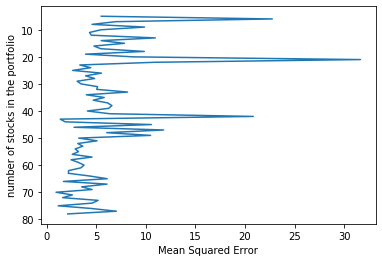

In [13]:
# Plot Efficient Deep Frontier

mse = [e/len(ibb['validate']['lp']) for e in error] # mse = sum of 2 norm difference/ # of test dates
plt.gca().invert_yaxis()
plt.plot(mse, list(range(5,79,1)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio') 